<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
# Data modules
import numpy as np
import scipy.stats as stats
import pandas as pd

# Plotting modules
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

# Make sure charts appear in the notebook
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Stats/regressions packages
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, roc_curve, auc, classification_report
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Enable viewing of all columns for DataFrames
pd.set_option('display.max_columns', None)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
house.shape

(1460, 81)

In [4]:
house.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [5]:
# Check zoning of the houses in the dataset
# MSZoning: Identifies the general zoning classification of the sale.
#       A	Agriculture
#       C	Commercial
#       FV	Floating Village Residential
#       I	Industrial
#       RH	Residential High Density
#       RL	Residential Low Density
#       RP	Residential Low Density Park 
#       RM	Residential Medium Density
house['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [6]:
# Dropping 10 rows where the houses are classified as C (all)
# FV, floating village residential, are still residential housing although they are constructed on water bodies
house = house[house['MSZoning'] != 'C (all)']
house.shape

(1450, 81)

In [7]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 81 columns):
Id               1450 non-null int64
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            89 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-n

In [8]:
# Categorizing fixed, renovate-able and other features (target variable: SalePrice is excluded)
# Renovate-able features classified as those that can be altered without tearing down the whole house

# Fixed examples: The neighborhood, Square feet, Bedrooms, bathrooms, Basement and garage space
fixed = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour',
         'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
         'YearBuilt', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
         'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
         'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageType', 'GarageYrBlt',
         'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
         'PoolArea']

# Renovate-able examples: Roof and exterior features, "Quality" metrics, "Condition" metrics,
# Heating and electrical components
reno = ['Utilities', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
        'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2',
        'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'Fireplaces',
        'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
        'MiscFeature', 'MiscVal']

other = ['Id', 'YearRemodAdd', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']

In [9]:
house.isnull().sum().sort_values(ascending=False)

PoolQC           1443
MiscFeature      1398
Alley            1361
Fence            1172
FireplaceQu       681
LotFrontage       259
GarageCond         79
GarageType         79
GarageYrBlt        79
GarageFinish       79
GarageQual         79
BsmtExposure       38
BsmtFinType2       38
BsmtFinType1       37
BsmtCond           37
BsmtQual           37
MasVnrArea          8
MasVnrType          8
Electrical          1
Utilities           0
YearRemodAdd        0
MSSubClass          0
Foundation          0
ExterCond           0
ExterQual           0
Exterior2nd         0
Exterior1st         0
RoofMatl            0
RoofStyle           0
YearBuilt           0
                 ... 
GarageArea          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
3SsnPorch           0
BsmtUnfSF           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
Functional          0
TotRmsAbvGrd        0
KitchenQua

In [10]:
# Definining a function to automatically replace Null values in the DataFrame column
def dfnullrep(column, value, df=house):
    '''
    Function to fill null values of a column in a DataFrame with another value
    column = column name of the DataFrame with null values to be replaced
    value = value to replace the null values with
    df = DataFrame, default is house
    '''
    house[column].fillna(value,inplace=True)

In [11]:
# Checking if Null values in PoolQC is due to having no PoolArea
house[house['PoolQC'].isnull()][['PoolQC', 'PoolArea']].sum()

PoolQC      0.0
PoolArea    0.0
dtype: float64

In [12]:
# Replacing the Null values in PoolQC with NA to signify 'Not Applicable'
dfnullrep('PoolQC', 'NA')

In [13]:
# Checking if Null values in MiscFeature is due to having nothing
print(house['MiscFeature'].unique())
house[house['MiscFeature'].isnull()][['MiscFeature', 'MiscVal']].sum()

[nan 'Shed' 'Gar2' 'Othr' 'TenC']


MiscFeature    0.0
MiscVal        0.0
dtype: float64

In [14]:
# MiscFeature is missing the 'NA' representing None and it corresponds with MiscVal being zero
# Replacing the Null values in MiscFeature with NA to signify 'None'
dfnullrep('MiscFeature', 'NA')

In [15]:
# Checking if Alley and Fence are also facing the same issue as MiscFeature
# ie, Null values are actually NA for 'No alley access' and 'No Fence'
print(house['Alley'].unique())
print(house['Fence'].unique())

[nan 'Grvl' 'Pave']
[nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']


In [16]:
# Replacing the Null values in Alley and Fence with NA as they seem to be missing values
# NA to signify No alley access' for Alley and 'No Fence' for Fence
dfnullrep('Alley', 'NA')
dfnullrep('Fence', 'NA')

In [17]:
# Checking if Null values in FireplaceQu is due to having no Fireplaces
house[house['FireplaceQu'].isnull()][['FireplaceQu', 'Fireplaces']].sum()

FireplaceQu    0.0
Fireplaces     0.0
dtype: float64

In [18]:
# Replacing the Null values in FireplaceQu with NA to signify 'Not Applicable'
dfnullrep('FireplaceQu', 'NA')

<div class="alert alert-info">

### Lot Frontage
In real estate, frontage is the width of a lot, measured at the front part of the lot.

Exploring the LotFrontage Null values to see if there are any connections and/or reasons that can help fill in the Null values.

Potentially could be affected by the LotConfig, LotShape or LotArea

</div>

In [19]:
house[house['LotFrontage'].isnull()]['LotConfig'].value_counts()

Inside     134
Corner      62
CulDSac     49
FR2         14
Name: LotConfig, dtype: int64

In [20]:
house[house['LotFrontage'].isnull() == False]['LotConfig'].value_counts()

Inside     910
Corner     199
CulDSac     45
FR2         33
FR3          4
Name: LotConfig, dtype: int64

In [21]:
house[house['LotFrontage'].isnull()]['LotShape'].value_counts()

IR1    167
Reg     74
IR2     15
IR3      3
Name: LotShape, dtype: int64

In [22]:
house[house['LotFrontage'].isnull() == False]['LotShape'].value_counts()

Reg    842
IR1    316
IR2     26
IR3      7
Name: LotShape, dtype: int64

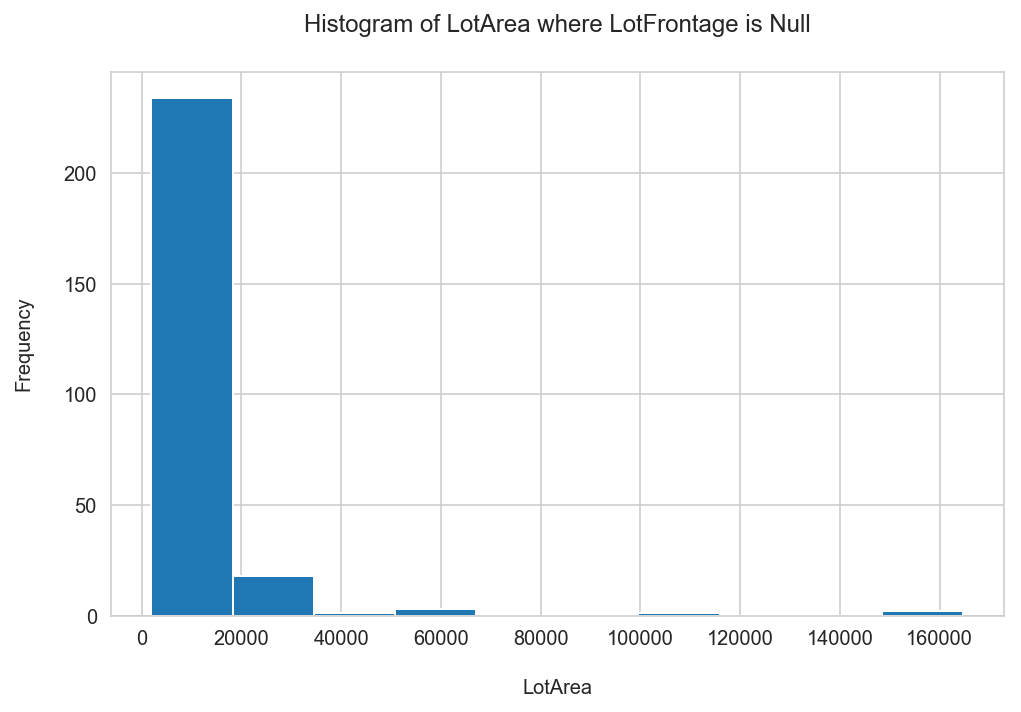

In [23]:
plt.figure(figsize=(8,5))
house[house['LotFrontage'].isnull()]['LotArea'].hist()
plt.title('Histogram of LotArea where LotFrontage is Null', pad=20)
plt.ylabel('Frequency', labelpad=15)
plt.xlabel('LotArea', labelpad=15)
plt.show()

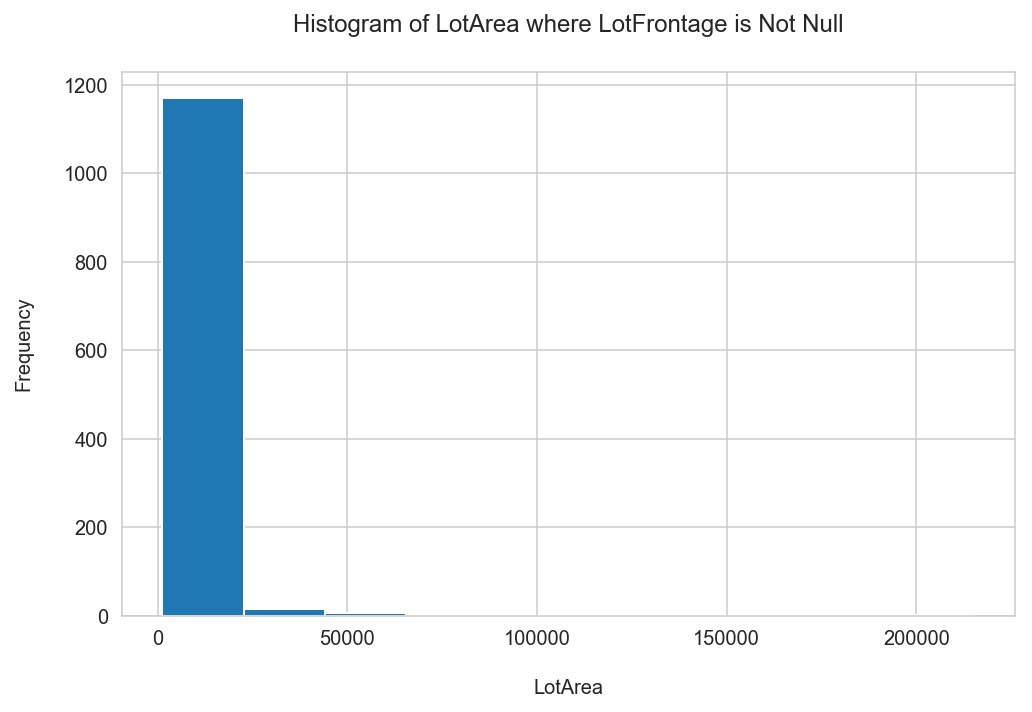

In [24]:
plt.figure(figsize=(8,5))
house[house['LotFrontage'].isnull() == False]['LotArea'].hist()
plt.title('Histogram of LotArea where LotFrontage is Not Null', pad=20)
plt.ylabel('Frequency', labelpad=15)
plt.xlabel('LotArea', labelpad=15)
plt.show()

In [25]:
# No clear reason for Null values in LotFrontage
# However, there seems to be more with LotShape IR1 as compared to those with LotFrontage
# Viewing the average LotFrontage for the various LotShape
house[['LotFrontage', 'LotShape']].groupby('LotShape').mean()

LotFrontage
LotShape             
IR1         76.003165
IR2         76.500000
IR3        138.428571
Reg         67.052257

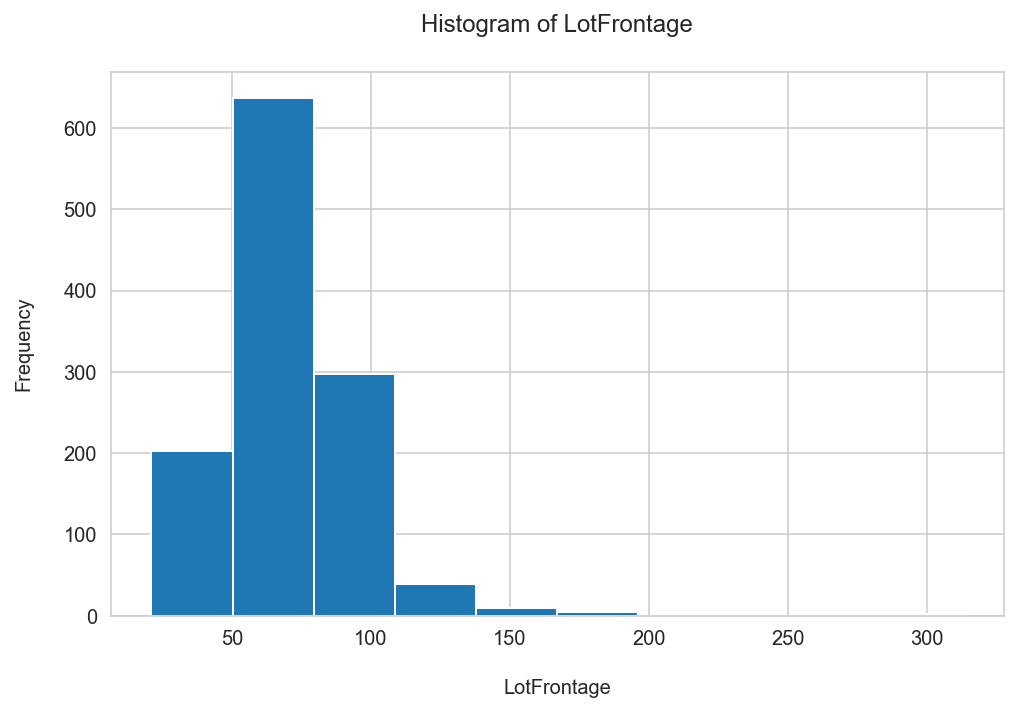

In [26]:
# Values of IR1, IR2 and Reg are relatively close and even though IR3 is significantly higher
# The total number of IR3 LotShape with Null values in LotFrontage constitutes quite a large percentage
# Viewing the histogram of LotFrontage
plt.figure(figsize=(8,5))
house['LotFrontage'].hist()
plt.title('Histogram of LotFrontage', pad=20)
plt.ylabel('Frequency', labelpad=15)
plt.xlabel('LotFrontage', labelpad=15)
plt.show()

In [27]:
# LotFrontage distribution is right-skewed thus applying mean might skew the data (possibly due to IR3)
# Replacing Null values in LotFrontage with the Median values of LotFrontage
dfnullrep('LotFrontage', house['LotFrontage'].median())

In [28]:
# Checking if Null values in Garage___ features is due to having no garage
# Based on checking if GarageType is missing NA which represents 'No Garage'

print(house['GarageType'].unique())
house[house['GarageType'].isnull()][['GarageType', 'GarageCond', 'GarageYrBlt', 'GarageFinish', 'GarageQual']].sum()

['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']


GarageType      0.0
GarageCond      0.0
GarageYrBlt     0.0
GarageFinish    0.0
GarageQual      0.0
dtype: float64

In [29]:
# Replacing the Null values in GarageType, GarageFinish, GarageQual and GarageCond with NA to signify 'No Garage'
dfnullrep('GarageType', 'NA')
dfnullrep('GarageFinish', 'NA')
dfnullrep('GarageQual', 'NA')
dfnullrep('GarageCond', 'NA')

# Replacing the Null values in GarageYrBlt with 0 to maintain dtype int64 & signify no garage built
dfnullrep('GarageYrBlt', 0)

In [30]:
# Checking if the Bsmt__ features with null values are from the observations,
# other than 1 observation. Filter based on BsmtExposure
print(house[house['BsmtExposure'].isnull()][['BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual']].shape)
house[house['BsmtExposure'].isnull()][['BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual']]

(38, 5)


BsmtExposure BsmtFinType2 BsmtFinType1 BsmtCond BsmtQual
17            NaN          NaN          NaN      NaN      NaN
39            NaN          NaN          NaN      NaN      NaN
90            NaN          NaN          NaN      NaN      NaN
102           NaN          NaN          NaN      NaN      NaN
156           NaN          NaN          NaN      NaN      NaN
182           NaN          NaN          NaN      NaN      NaN
259           NaN          NaN          NaN      NaN      NaN
342           NaN          NaN          NaN      NaN      NaN
362           NaN          NaN          NaN      NaN      NaN
371           NaN          NaN          NaN      NaN      NaN
392           NaN          NaN          NaN      NaN      NaN
520           NaN          NaN          NaN      NaN      NaN
532           NaN          NaN          NaN      NaN      NaN
533           NaN          NaN          NaN      NaN      NaN
553           NaN          NaN          NaN      NaN      NaN
646           NaN          NaN          NaN      NaN      NaN
705           NaN          NaN          NaN      NaN      NaN
736           NaN          NaN          NaN      NaN      NaN
749           NaN          NaN          NaN      NaN      NaN
778           NaN          NaN          NaN      NaN      NaN
868           NaN          NaN          NaN      NaN      NaN
894           NaN          NaN          NaN      NaN      NaN
897           NaN          NaN          NaN      NaN      NaN
948           NaN          Unf          Unf       TA       Gd
984           NaN          NaN          NaN      NaN      NaN
1000          NaN          NaN          NaN      NaN      NaN
1011          NaN          NaN          NaN      NaN      NaN
1035          NaN          NaN          NaN      NaN      NaN
1045          NaN          NaN          NaN      NaN      NaN
1048          NaN          NaN          NaN      NaN      NaN
1049          NaN          NaN          NaN      NaN      NaN
1090          NaN          NaN          NaN      NaN      NaN
1179          NaN          NaN          NaN      NaN      NaN
1216          NaN          NaN          NaN      NaN      NaN
1218          NaN          NaN          NaN      NaN      NaN
1232          NaN          NaN          NaN      NaN      NaN
1321          NaN          NaN          NaN      NaN      NaN
1412          NaN          NaN          NaN      NaN      NaN

In [31]:
# The 38 Null values in BsmtExposure are not the same as the 38 Null values in BsmtFinType2
# Checking Bsmt__ features now filtering based on BsmtFinType2.
# BsmtFinSF2 included to check if there is any Square Feet for basement2
house[house['BsmtFinType2'].isnull()][['BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual', 'BsmtFinSF2']]

BsmtExposure BsmtFinType2 BsmtFinType1 BsmtCond BsmtQual  BsmtFinSF2
17            NaN          NaN          NaN      NaN      NaN           0
39            NaN          NaN          NaN      NaN      NaN           0
90            NaN          NaN          NaN      NaN      NaN           0
102           NaN          NaN          NaN      NaN      NaN           0
156           NaN          NaN          NaN      NaN      NaN           0
182           NaN          NaN          NaN      NaN      NaN           0
259           NaN          NaN          NaN      NaN      NaN           0
332            No          NaN          GLQ       TA       Gd         479
342           NaN          NaN          NaN      NaN      NaN           0
362           NaN          NaN          NaN      NaN      NaN           0
371           NaN          NaN          NaN      NaN      NaN           0
392           NaN          NaN          NaN      NaN      NaN           0
520           NaN          NaN          NaN      NaN      NaN           0
532           NaN          NaN          NaN      NaN      NaN           0
533           NaN          NaN          NaN      NaN      NaN           0
553           NaN          NaN          NaN      NaN      NaN           0
646           NaN          NaN          NaN      NaN      NaN           0
705           NaN          NaN          NaN      NaN      NaN           0
736           NaN          NaN          NaN      NaN      NaN           0
749           NaN          NaN          NaN      NaN      NaN           0
778           NaN          NaN          NaN      NaN      NaN           0
868           NaN          NaN          NaN      NaN      NaN           0
894           NaN          NaN          NaN      NaN      NaN           0
897           NaN          NaN          NaN      NaN      NaN           0
984           NaN          NaN          NaN      NaN      NaN           0
1000          NaN          NaN          NaN      NaN      NaN           0
1011          NaN          NaN          NaN      NaN      NaN           0
1035          NaN          NaN          NaN      NaN      NaN           0
1045          NaN          NaN          NaN      NaN      NaN           0
1048          NaN          NaN          NaN      NaN      NaN           0
1049          NaN          NaN          NaN      NaN      NaN           0
1090          NaN          NaN          NaN      NaN      NaN           0
1179          NaN          NaN          NaN      NaN      NaN           0
1216          NaN          NaN          NaN      NaN      NaN           0
1218          NaN          NaN          NaN      NaN      NaN           0
1232          NaN          NaN          NaN      NaN      NaN           0
1321          NaN          NaN          NaN      NaN      NaN           0
1412          NaN          NaN          NaN      NaN      NaN           0

In [32]:
# Seems like these 2 rows (332 & 948) should have some sort of values in the BsmtExposure & BsmtFinType2 columns
# No clear reason for the Null values in these 2 rows, thus, will drop them
house.drop(332,inplace=True)
house.drop(948,inplace=True)

In [33]:
# Checking if remaining Null values in Bsmt___ features is due to having no basement
# Based on checking if BsmtQual is missing NA which represents 'No Basement'

print(house['BsmtQual'].unique())
house[house['BsmtQual'].isnull()][['BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual']].sum()

['Gd' 'TA' 'Ex' nan 'Fa']


BsmtExposure    0.0
BsmtFinType2    0.0
BsmtFinType1    0.0
BsmtCond        0.0
BsmtQual        0.0
dtype: float64

In [34]:
# Replacing the Null values in BsmtExposure, BsmtFinType2, BsmtFinType1,
# BsmtCond and BsmtQual with NA to signify 'No Basement'
dfnullrep('BsmtExposure', 'NA')
dfnullrep('BsmtFinType2', 'NA')
dfnullrep('BsmtFinType1', 'NA')
dfnullrep('BsmtCond', 'NA')
dfnullrep('BsmtQual', 'NA')

In [35]:
# No clear reason for Null value in Electrical feature
# Dropping the row where Electrical feature has null value
house.drop(house[house['Electrical'].isnull()].index, inplace=True)

In [36]:
# Checking if the MasVnr__ features with null values are from the observations
house[house['MasVnrArea'].isnull()][['MasVnrArea','MasVnrType']].sum()

MasVnrArea    0.0
MasVnrType    0.0
dtype: float64

In [37]:
# Sampling MasVnr__ features with target variable (SalePrice)
# To see if there are any trends that can be applied to the Null values
house[['MasVnrArea','MasVnrType','SalePrice']].head(10)

MasVnrArea MasVnrType  SalePrice
0       196.0    BrkFace     208500
1         0.0       None     181500
2       162.0    BrkFace     223500
3         0.0       None     140000
4       350.0    BrkFace     250000
5         0.0       None     143000
6       186.0      Stone     307000
7       240.0      Stone     200000
8         0.0       None     129900
9         0.0       None     118000

In [38]:
# No clear reason for Null values but there seems to be a trend of MasVnrArea is 0 & MasVnrType is None
# Replace MasVnrArea with null values as Zero and MasVnrType with null values as None
house['MasVnrArea'].fillna(0, inplace=True)
house['MasVnrType'].fillna('None', inplace=True)

In [39]:
house.isnull().sum().sort_values(ascending=False)

SalePrice       0
Heating         0
RoofStyle       0
RoofMatl        0
Exterior1st     0
Exterior2nd     0
MasVnrType      0
MasVnrArea      0
ExterQual       0
ExterCond       0
Foundation      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinSF1      0
BsmtFinType2    0
BsmtFinSF2      0
BsmtUnfSF       0
YearRemodAdd    0
YearBuilt       0
OverallCond     0
LandContour     0
MSSubClass      0
MSZoning        0
LotFrontage     0
LotArea         0
Street          0
Alley           0
LotShape        0
               ..
ScreenPorch     0
PoolArea        0
PoolQC          0
Fence           0
MiscFeature     0
MiscVal         0
MoSold          0
YrSold          0
SaleType        0
GarageCars      0
GarageFinish    0
GarageYrBlt     0
FullBath        0
Electrical      0
1stFlrSF        0
2ndFlrSF        0
LowQualFinSF    0
GrLivArea       0
BsmtFullBath    0
BsmtHalfBath    0
HalfBath        0
GarageType      0
BedroomAbvGr    0
KitchenAbvGr    0
KitchenQua

In [40]:
house.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1447.000000  1447.000000  1447.000000    1447.000000  1447.000000   
mean    731.040774    56.910850    70.034554   10521.879751     6.113338   
std     421.477386    42.293281    22.041145   10022.125463     1.372878   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     366.500000    20.000000    60.000000    7537.500000     5.000000   
50%     731.000000    50.000000    70.000000    9490.000000     6.000000   
75%    1096.500000    70.000000    79.000000   11611.000000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1447.000000  1447.000000   1447.000000  1447.000000  1447.000000   
mean      5.583276  1971.526607   1985.009675   103.739461   445.308915   
std       1.108160    30.018122     20.554617   181.243833   456.177736   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1994.000000     0.000000   384.000000   
75%       6.000000  2000.000000   2004.000000   166.000000   713.500000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

        BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  \
count  1447.000000  1447.000000  1447.000000  1447.000000  1447.000000   
mean     46.636489   566.532135  1058.477540  1164.894264   347.091914   
std     161.587591   442.072622   435.648699   386.656724   437.192393   
min       0.000000     0.000000     0.000000   334.000000     0.000000   
25%       0.000000   222.000000   796.000000   883.000000     0.000000   
50%       0.000000   474.000000   992.000000  1088.000000     0.000000   
75%       0.000000   807.000000  1301.000000  1392.000000   728.000000   
max    1474.000000  2336.000000  6110.000000  4692.000000  2065.000000   

       LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath  \
count   1447.000000  1447.000000   1447.000000   1447.000000  1447.000000   
mean       5.542502  1517.528680      0.427782      0.057360     1.568072   
std       46.980950   525.636561      0.519471      0.238482     0.549767   
min        0.000000   334.000000      0.000000      0.000000     0.000000   
25%        0.000000  1131.000000      0.000000      0.000000     1.000000   
50%        0.000000  1466.000000      0.000000      0.000000     2.000000   
75%        0.000000  1781.500000      1.000000      0.000000     2.000000   
max      572.000000  5642.000000      3.000000      2.000000     3.000000   

          HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  \
count  1447.000000   1447.000000   1447.000000   1447.000000  1447.000000   
mean      0.384243      2.870076      1.046303      6.521078     0.616448   
std       0.503350      0.815469      0.219861      1.626864     0.645298   
min       0.000000      0.000000      0.000000      2.000000     0.000000   
25%       0.000000      2.000000      1.000000      5.000000     0.000000   
50%       0.000000      3.000000      1.000000      6.000000     1.000000   
75%       1.000000      3.000000      1.000000      7.000000     1.000000   
max       2.000000      8.000000      3.000000     14.000000     3.000000   

       GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  \
count  1447.000000  1447.000000  1447.000000  1447.000000  1447.000000   
mean   1870.550104     1.769178   473.046994    94.854872    46.568072   
std     450.301118     0.745157   212.630448   125.659575    65.254471   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%    1958.000000     1.000000   336.000000     0.000000     0.000000   
50%    1977.000000     2.000000   480.000000     0.000000    25.000000   
75%    2001.000000     2.000000   576.000000   168.000000    68.000000   
max    2

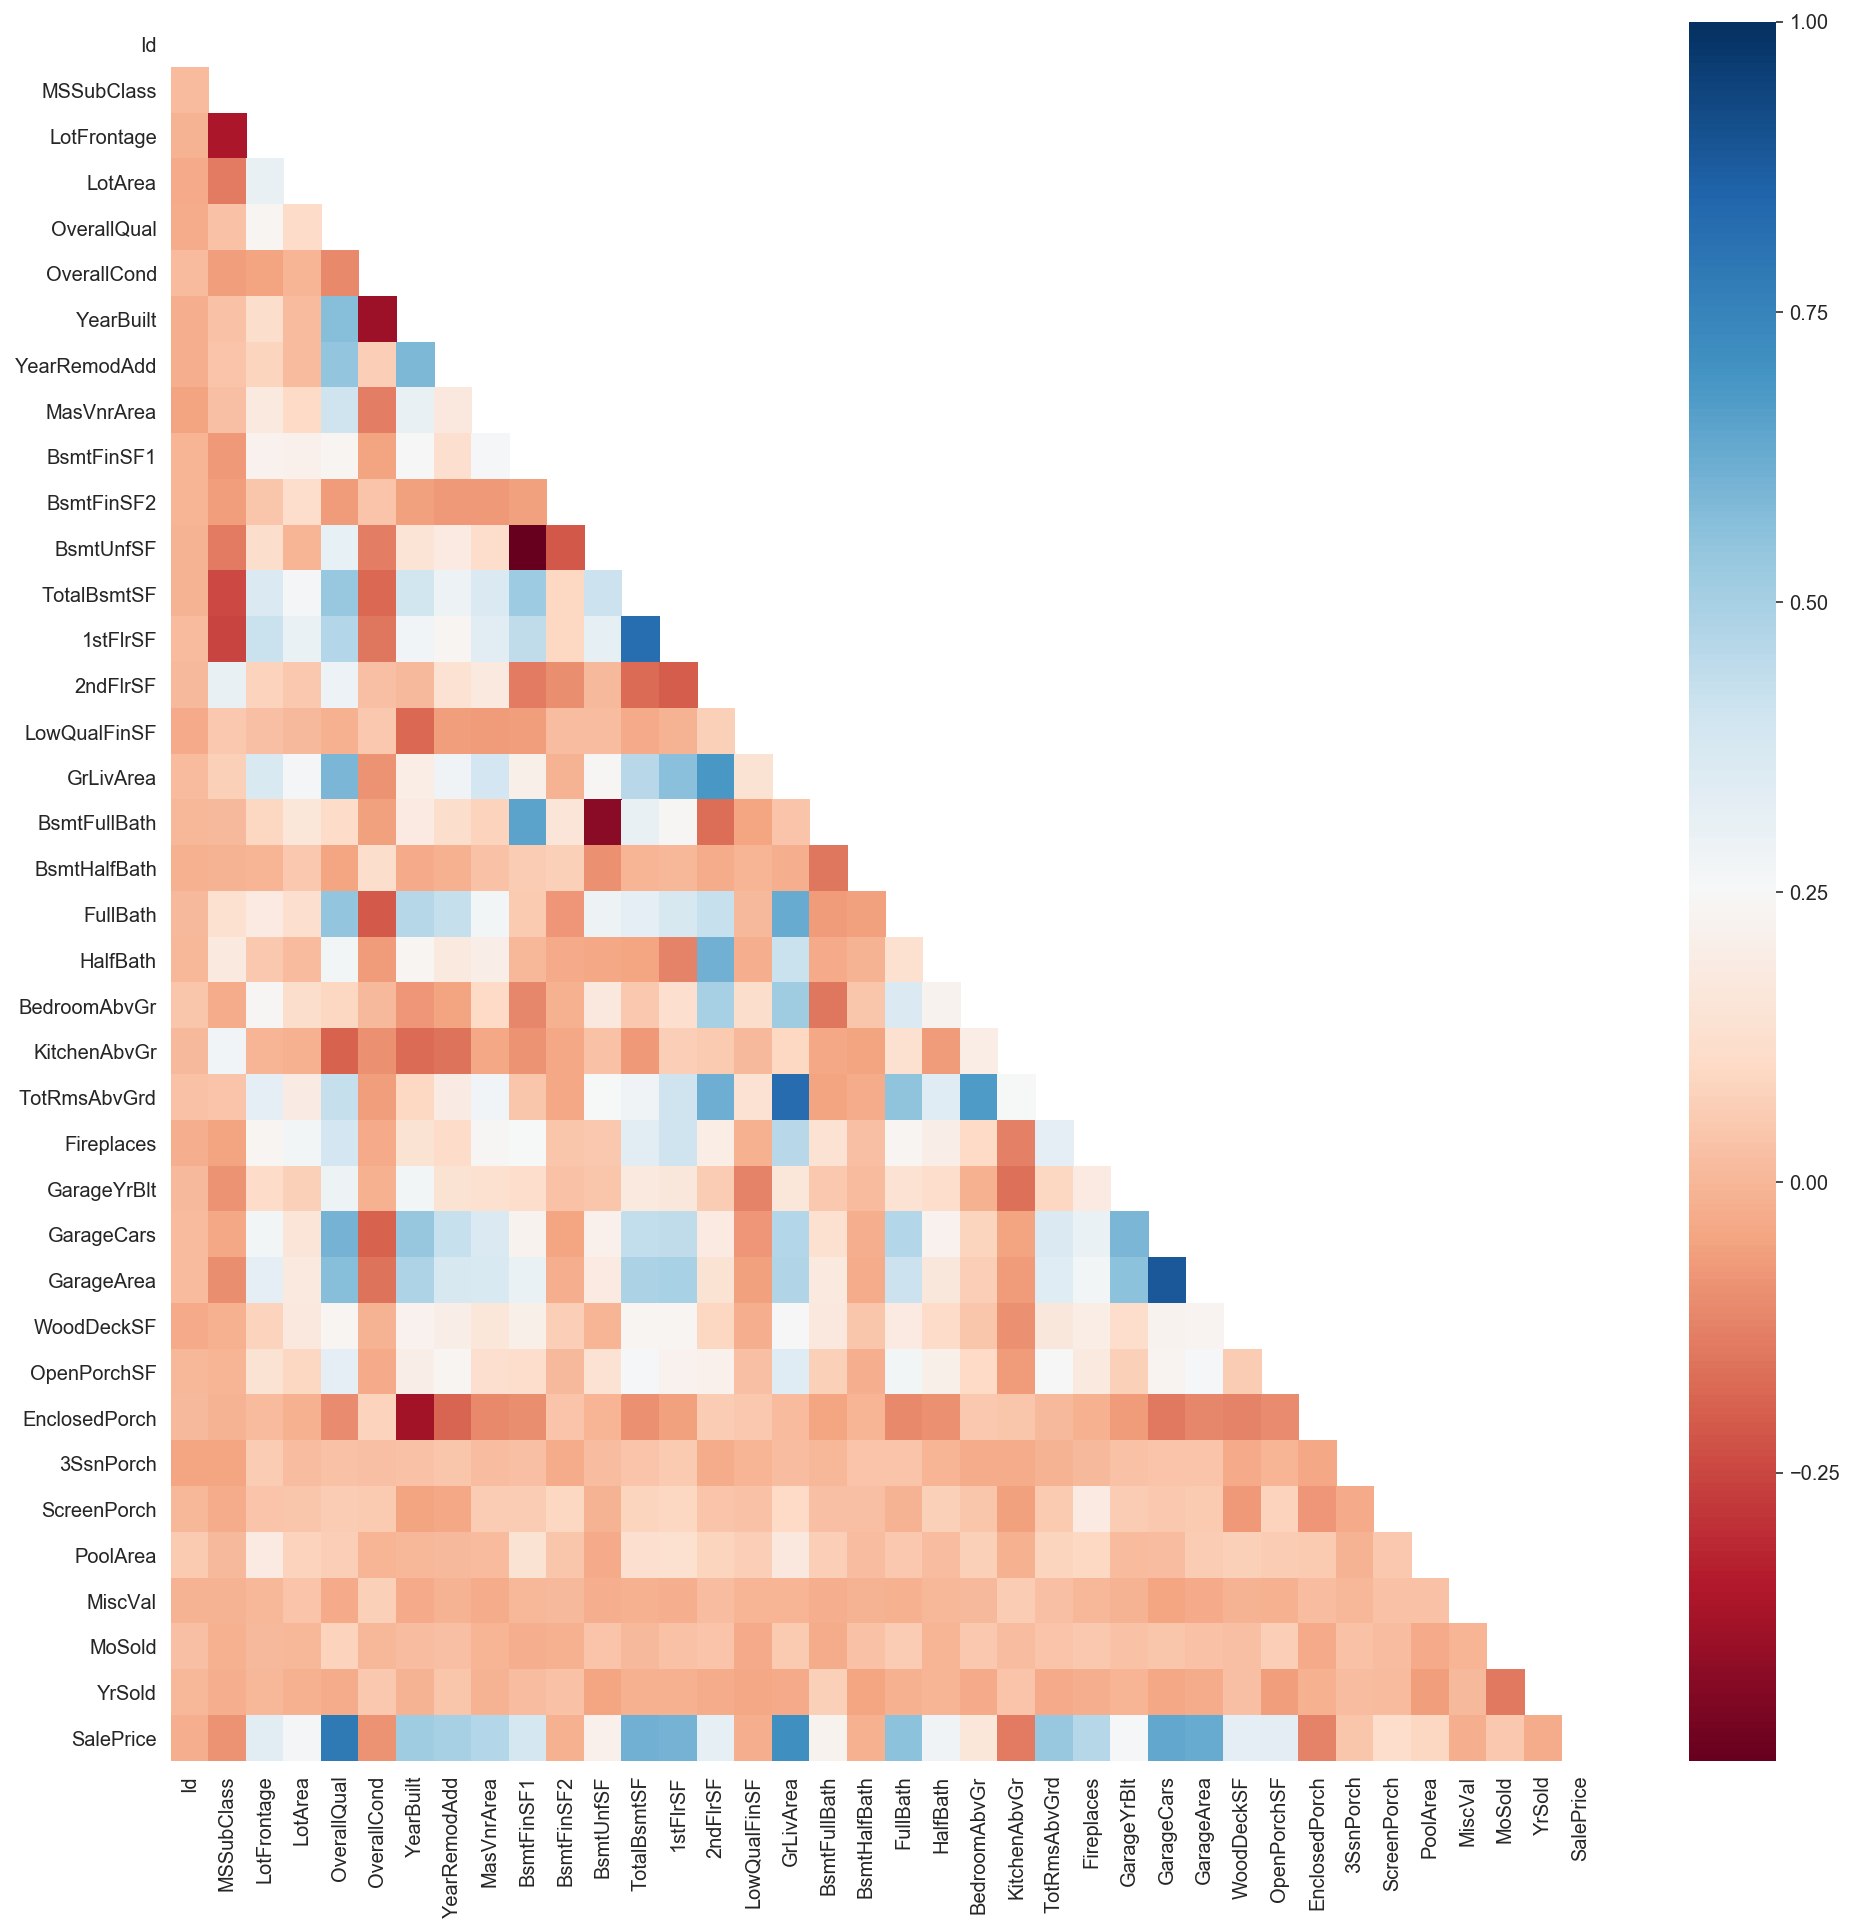

In [41]:
# Look at correlation between the variables.
df_corr = house.corr()

# Setting figure plotsize
fix, ax = plt.subplots(figsize=(16,16))

# Generate a mask for the upper triangle (taken from Seaborn's example gallery).
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with Seaborn.
ax = sns.heatmap(df_corr, cmap='RdBu', mask=mask, ax=ax)

plt.show()

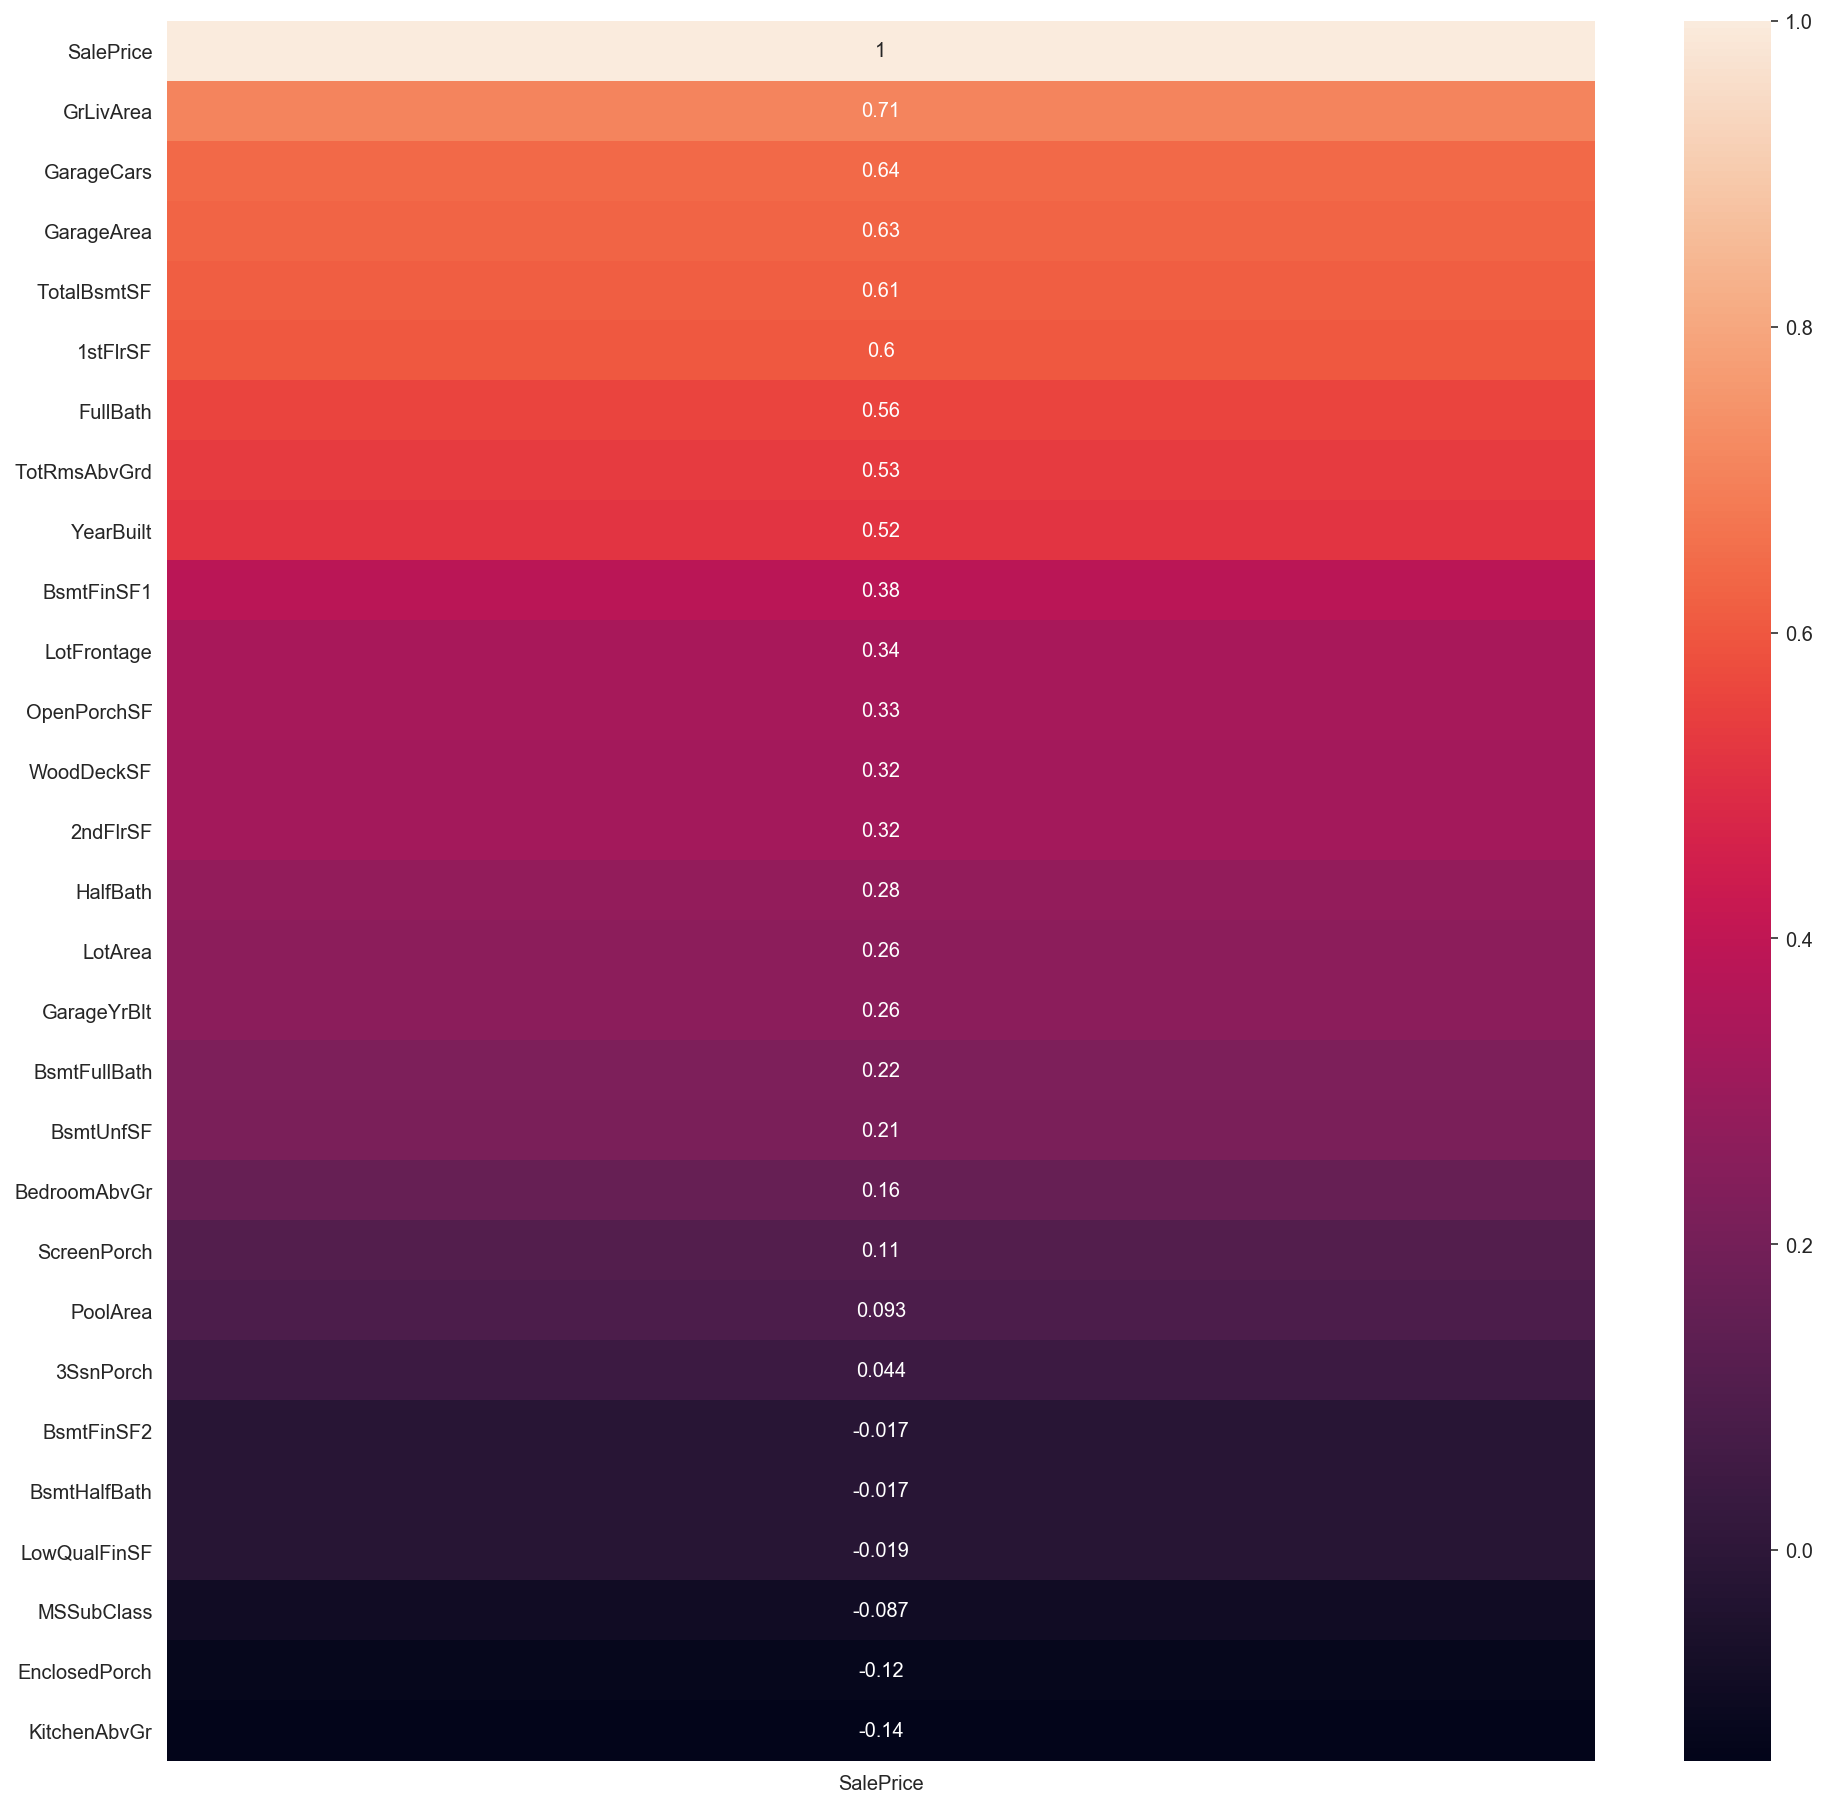

In [42]:
# Generate a heatmap to see which of the fixed features are most strongly correlated with the target variable (SalePrice)

fix, ax = plt.subplots(figsize=(16,16))

sns.heatmap(house[fixed + ['SalePrice']].corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False), annot=True)
plt.show()

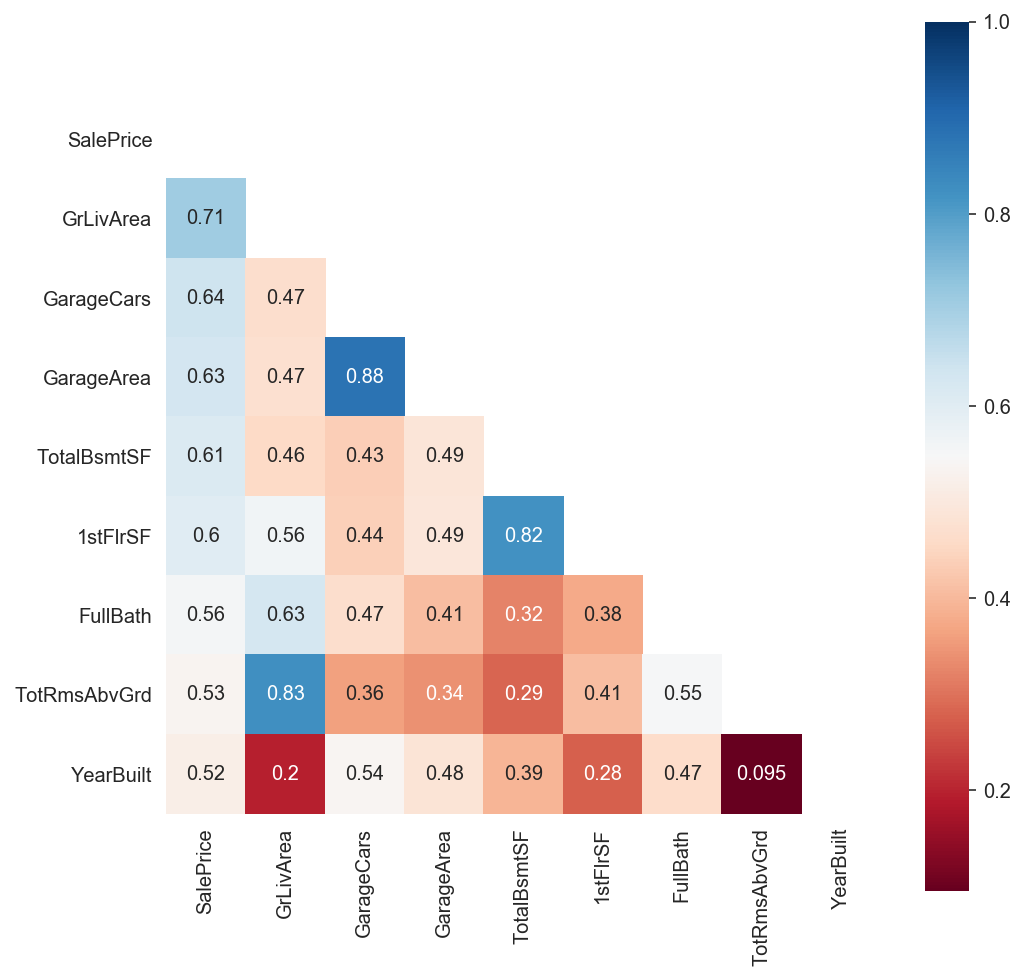

In [43]:
# Looking at the correlation of the top 8 correlated fixed features with SalePrice
top8 = ['SalePrice', 'GrLivArea', 'GarageCars', 'GarageArea',
        'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']

df_corr = house[top8].corr()

# Setting figure plotsize
fix, ax = plt.subplots(figsize=(8,8))

# Generate a mask for the upper triangle (taken from Seaborn's example gallery).
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with Seaborn.
ax = sns.heatmap(df_corr, annot=True, square=True, cmap='RdBu', mask=mask, ax=ax)

plt.show()

<div class="alert alert-info">
    
### 3 pairs of features that are highly correlated with each other (correlation > 0.8)

#### - GarageArea & GarageCars
Expected as both of them are just different measures of the garage size. 

Will continue analysis with GarageCars instead of GarageArea as GarageCars is slightly more correlated with SalePrice

#### - 1stFlrSF & TotalBsmtSF
Somewhat expected as the basement is just technically beneath the 1st floor. Unless expansion was done for the basement to make it bigger than the actual 1st floor of the house. (ie, Secret laboratory).

Will continue analysis with TotalBsmtSF instead of 1stFlrSF as it is more correlated with SalePrice

#### - TotRmsAbvGrd & GrLivArea
Also expected as one is just measuring the rooms vs the area in square feet.

Will continue analysis with GrLivArea instead of TotRmsAbvGrd as it is more correlated with SalePrice

</div>

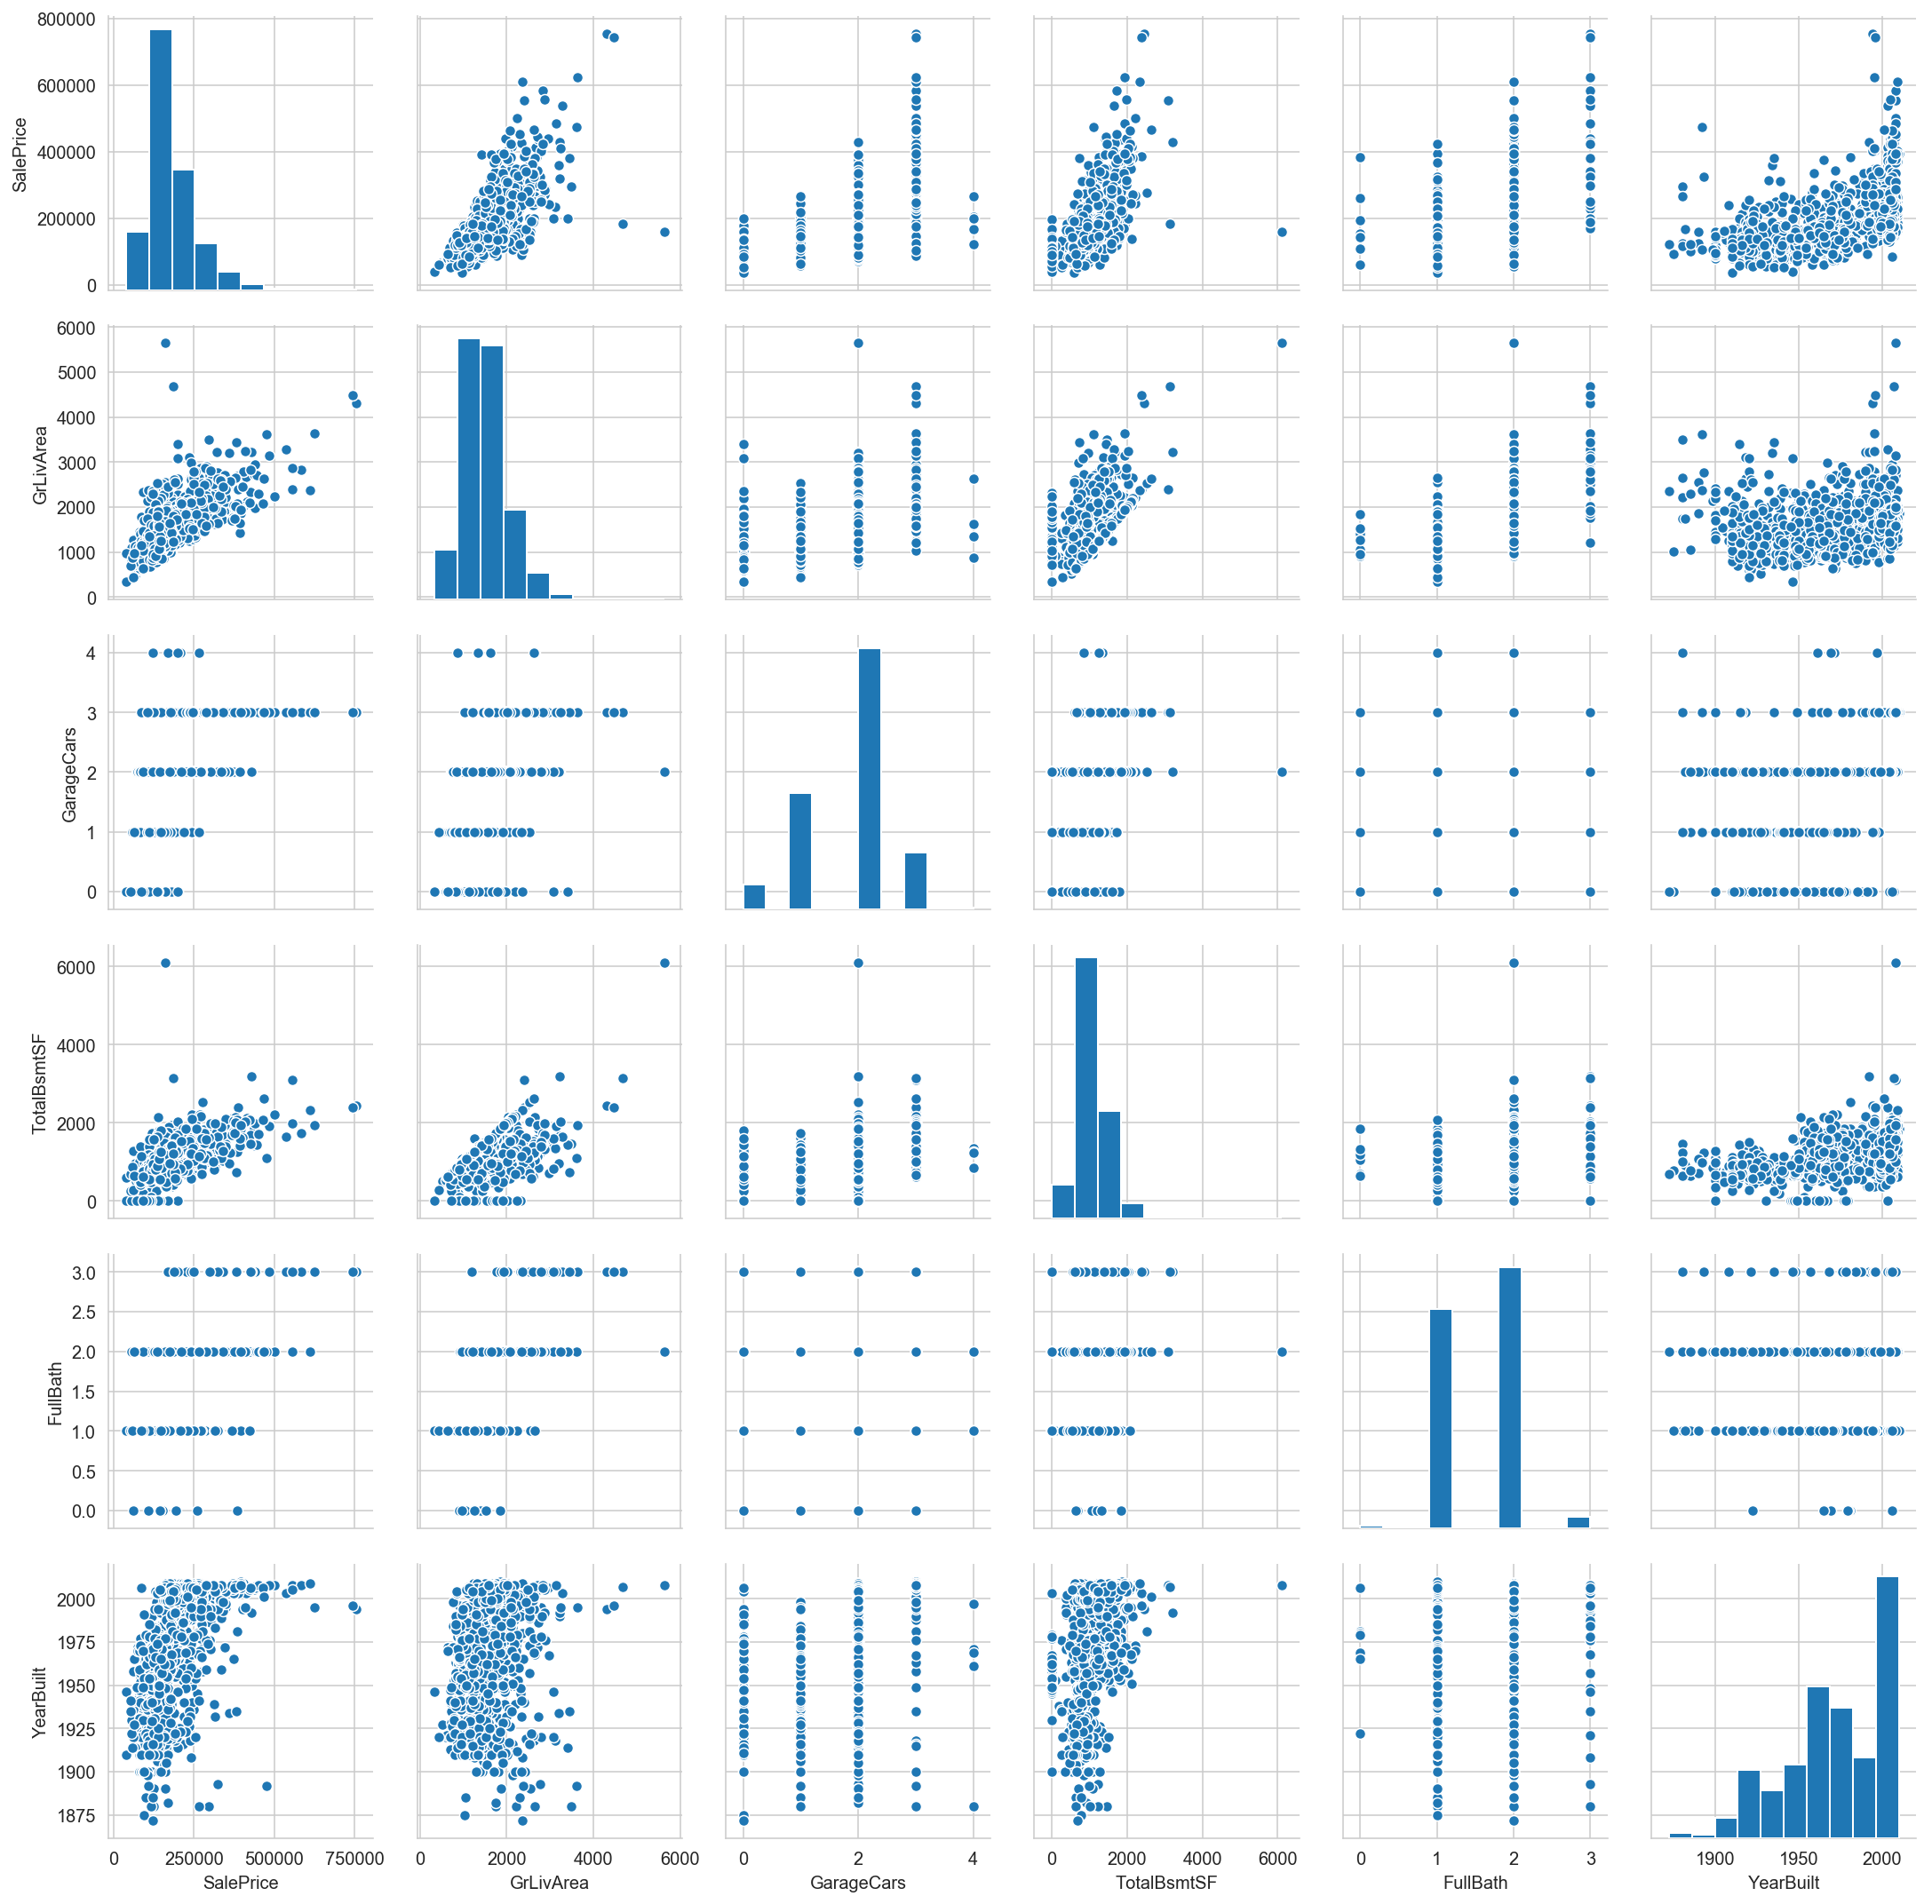

In [44]:
# Looking at the pairplot of the top correlated fixed features with SalePrice
cols = ['SalePrice', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(house[cols])
plt.show()

In [45]:
# Feature engineering with one-hot encoding for fixed features that are categorical
dummy = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape','LandContour', 'LotConfig',
         'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
         'Foundation', 'BsmtQual', 'BsmtExposure', 'GarageType']

# Converting MSSubClass to object dtype from int64 dtype in order to apply get.dummies
house['MSSubClass'] = house['MSSubClass'].apply(str)

df_fix = pd.concat([house[fixed], pd.get_dummies(house[dummy], drop_first=True), house[['YrSold', 'SalePrice']]], axis=1)
df_fix.drop(columns=dummy, inplace=True)

In [46]:
df_fix.shape

(1447, 130)

In [47]:
# Train-Test split based on YrSold of 2010: pre-2010 as train & 2010 as test
y_train = df_fix[df_fix['YrSold'] < 2010]['SalePrice']
y_test = df_fix[df_fix['YrSold'] == 2010]['SalePrice']
X_train = df_fix[df_fix['YrSold'] < 2010].drop(columns=['SalePrice', 'YrSold'])
X_test = df_fix[df_fix['YrSold'] == 2010].drop(columns=['SalePrice', 'YrSold'])

In [48]:
# Since means of all the features are quite different from each other, transform to standard scale
ss = StandardScaler()

# Only fit to train dataset but scale/transform both train & test
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

Xs_train = pd.DataFrame(Xs_train, columns=X_train.columns)
Xs_test = pd.DataFrame(Xs_test, columns=X_test.columns)

In [49]:
# Applying Linear Regression model with the 5 fixed features selected via EDA
lm = LinearRegression()

X5s_train = Xs_train[cols[1:]]
X5s_test = Xs_test[cols[1:]]

scores = cross_val_score(lm, X5s_train, y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

Cross-validated scores: [0.76675203 0.76016295 0.79704631 0.62882992 0.73353219 0.75746567
 0.73207605 0.73186379 0.36464101 0.76855551]
Mean Cross-validated scores: 0.7040925433390408
Std Cross-validated scores: 0.12084183203444372


In [50]:
model = lm.fit(X5s_train, y_train)
print("Train score:", model.score(X5s_train, y_train))
print("Test score:", model.score(X5s_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, model.predict(X5s_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, model.predict(X5s_test)))

Train score: 0.7102434062178622
Test score: 0.7616201548131842
Train Mean Squared Error: 1813136406.5161228
Train Mean Squared Error: 1515475813.7726827


<div class="alert alert-warning">
    
### Initial Linear regression model with 5 features from EDA

Using the 5 selected features via EDA to construct a Linear Regression shows decent results.

- Mean CV $R^2$: 0.7041
- Std CV $R^2$: 0.1208
- Train $R^2$: 0.7102
- Test $R^2$: 0.7616

However, there is 1 fold where $R^2$ is 0.3646.

</div>

In [51]:
# Applying Linear Regression model with all features
scores = cross_val_score(lm, X_train, y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

Cross-validated scores: [0.86943988 0.81083683 0.85318239 0.70420043 0.85520869 0.64788996
 0.86515613 0.80564363 0.52607104 0.81890003]
Mean Cross-validated scores: 0.7756529008267747
Std Cross-validated scores: 0.10810845039072117


In [52]:
model = lm.fit(Xs_train, y_train)
print("Train score:", model.score(Xs_train, y_train))
print("Test score:", model.score(Xs_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, model.predict(Xs_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, model.predict(Xs_test)))

Train score: 0.8643197432213484
Test score: 0.8756688859249667
Train Mean Squared Error: 849011958.622749
Train Mean Squared Error: 790422512.9958533


<div class="alert alert-warning">
    
### Linear regression model with All features

Applying the all the fixed features into the linear regression model yields very poor CV scores. However, the train and test $R^2$ scores perform better than the previous model of using 5 features.

Proceeding to apply Lasso to see what features have their coefficients zero-ed.

</div>

In [53]:
# Applying Lasso Regularized Linear Regression model for forced feature selection
# Finding optimal alpha with LassoCV

optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs_train, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

542.6292132002492


...............................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.5s finished


In [54]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

scores = cross_val_score(lasso, Xs_train, y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

Cross-validated scores: [0.9009377  0.83717599 0.86183862 0.73814947 0.8426154  0.69354113
 0.88822815 0.81299613 0.50074972 0.85668356]
Mean Cross-validated scores: 0.7932915878462421
Std Cross-validated scores: 0.11516786620167489


In [55]:
model = lasso.fit(Xs_train, y_train)
print("Train score:", model.score(Xs_train, y_train))
print("Test score:", model.score(Xs_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, model.predict(Xs_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, model.predict(Xs_test)))

Train score: 0.8558706766946091
Test score: 0.8761095104461901
Train Mean Squared Error: 901881541.0565698
Train Mean Squared Error: 787621287.0602213


In [56]:
# Print the coefficients for the Lasso Regularized Linear Regression Model
df_coef = pd.DataFrame(lasso.coef_, columns=['coef'])

df_coef['names'] = X_train.columns
df_coef['abs coef'] = np.abs(df_coef['coef'])

df_coef.sort_values('abs coef',ascending=False)

coef                 names      abs coef
10   32175.681098             GrLivArea  32175.681098
115 -16029.593032           BsmtQual_Gd  16029.593032
117 -14737.494551           BsmtQual_TA  14737.494551
74   12340.716837  Neighborhood_NridgHt  12340.716837
73    9622.473090  Neighborhood_NoRidge   9622.473090
19    9518.367964            GarageCars   9518.367964
2     9337.598448             YearBuilt   9337.598448
80    7497.598309  Neighborhood_StoneBr   7497.598309
79    6319.871080  Neighborhood_Somerst   6319.871080
16   -6113.508546          KitchenAbvGr   6113.508546
118   5363.185537       BsmtExposure_Gd   5363.185537
30    5330.002841         MSSubClass_20   5330.002841
94   -4938.664390       Condition2_PosN   4938.664390
116  -4935.380329           BsmtQual_NA   4935.380329
114  -4857.234662           BsmtQual_Fa   4857.234662
15   -4710.735890          BedroomAbvGr   4710.735890
64    4682.385380  Neighborhood_Crawfor   4682.385380
1     4555.183847               LotArea   4555.183847
13    4185.782194              FullBath   4185.782194
65   -4167.369120  Neighborhood_Edwards   4167.369120
121  -4160.188154       BsmtExposure_No   4160.188154
17    3779.599243          TotRmsAbvGrd   3779.599243
27   -3313.435126        MSSubClass_160   3313.435126
11    3211.970314          BsmtFullBath   3211.970314
25    3114.348828           ScreenPorch   3114.348828
3     2727.589275            BsmtFinSF1   2727.589275
48   -2703.817951          LotShape_IR3   2703.817951
69   -2608.218412  Neighborhood_Mitchel   2608.218412
101  -2602.165039       BldgType_TwnhsE   2602.165039
6     2586.759581           TotalBsmtSF   2586.759581
..            ...                   ...           ...
20       0.000000            GarageArea      0.000000
36       0.000000         MSSubClass_70      0.000000
98      -0.000000       BldgType_2fmCon      0.000000
97       0.000000       Condition2_RRNn      0.000000
37       0.000000         MSSubClass_75      0.000000
56       0.000000      LotConfig_Inside      0.000000
57      -0.000000         LandSlope_Mod      0.000000
49      -0.000000          LotShape_Reg      0.000000
59       0.000000  Neighborhood_Blueste      0.000000
35      -0.000000         MSSubClass_60      0.000000
34      -0.000000         MSSubClass_50      0.000000
67       0.000000   Neighborhood_IDOTRR      0.000000
33       0.000000         MSSubClass_45      0.000000
32       0.000000         MSSubClass_40      0.000000
29      -0.000000        MSSubClass_190      0.000000
28      -0.000000        MSSubClass_180      0.000000
81       0.000000   Neighborhood_Timber      0.000000
26       0.000000              PoolArea      0.000000
85      -0.000000       Condition1_PosA      0.000000
86       0.000000       Condition1_PosN      0.000000
46       0.000000            Alley_Pave      0.000000
88       0.000000       Condition1_RRAn      0.000000
89      -0.000000       Condition1_RRNe      0.000000
51      -0.000000       LandContour_Low      0.000000
91      -0.000000      Condition2_Feedr      0.000000
92       0.000000       Condition2_Norm      0.000000
23      -0.000000         EnclosedPorch      0.000000
22       0.000000           OpenPorchSF      0.000000
96       0.000000       Condition2_RRAn      0.000000
90       0.000000       Condition1_RRNn      0.000000

[128 rows x 3 columns]

In [57]:
# Printing out the number of selected features, the percentage of features removed and the selected features
print('Percent features removed:', np.sum((lasso.coef_ == 0))/float(len(lasso.coef_)))
fix_features = list(df_coef[df_coef['coef']!=0]['names'])
print('Number of selected features:', len(fix_features))
print()
print(fix_features)

Percent features removed: 0.3828125
Number of selected features: 79

['LotFrontage', 'LotArea', 'YearBuilt', 'BsmtFinSF1', 'TotalBsmtSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageCars', 'WoodDeckSF', '3SsnPorch', 'ScreenPorch', 'MSSubClass_160', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSZoning_RM', 'Street_Pave', 'Alley_NA', 'LotShape_IR2', 'LotShape_IR3', 'LandContour_HLS', 'LandContour_Lvl', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LandSlope_Sev', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighbo

<div class="alert alert-warning">
    
### Lasso Regularized Linear Regression

Performed better than the previous two models with 38.28% of the features with coefficients of 0.

- Mean CV $R^2$: 0.7933
- Std CV $R^2$: 0.1152
- Train $R^2$: 0.8559
- Test $R^2$: 0.8761

Proceeding to use Stats Model to view the p-values of the coefficients to see if further feature selection can be done. And to also view of there are any outliers in the selected features that need to be handled.

In [58]:
# Checking summary of the Linear Model using statsmodel
model = sm.OLS(y_train.values, sm.add_constant(Xs_train[fix_features]).values)
model = model.fit()
model.summary(xname=['Constant'] + fix_features)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     96.49
Date:                Wed, 16 Jan 2019   Prob (F-statistic):               0.00
Time:                        16:35:54   Log-Likelihood:                -14930.
No. Observations:                1275   AIC:                         3.002e+04
Df Residuals:                    1197   BIC:                         3.042e+04
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Constant              1.819e+05    851.675    213.594      0.000     1.8e+05    1.84e+05
LotFrontage          -3664.6165   1196.354     -3.063      0.002   -6011.800   -1317.433
LotArea               7005.0601   1305.556      5.366      0.000    4443.627    9566.493
YearBuilt             7729.0618   2397.515      3.224      0.001    3025.263    1.24e+04
BsmtFinSF1            2815.9081   1395.116      2.018      0.044      78.764    5553.052
TotalBsmtSF           -400.5966   1932.836     -0.207      0.836   -4192.720    3391.526
LowQualFinSF         -1705.9661    959.079     -1.779      0.076   -3587.628     175.696
GrLivArea             3.413e+04   2635.437     12.951      0.000     2.9e+04    3.93e+04
BsmtFullBath          3642.9581   1254.198      2.905      0.004    1182.287    6103.630
BsmtHalfBath          1221.2782    938.942      1.301      0.194    -620.876    3063.432
FullBath              4803.6395   1584.246      3.032      0.002    1695.432    7911.847
HalfBath              2683.3851   1358.625      1.975      0.048      17.833    5348.937
BedroomAbvGr         -5713.3403   1433.134     -3.987      0.000   -8525.075   -2901.606
KitchenAbvGr         -6266.3665   1329.001     -4.715      0.000   -8873.797   -3658.936
TotRmsAbvGrd          4497.5651   1990.613      2.259      0.024     592.087    8403.044
GarageCars            9209.6250   1509.323      6.102      0.000    6248.413    1.22e+04
WoodDeckSF            1873.2502    973.034      1.925      0.054     -35.793    3782.293
3SsnPorch             1863.4876    874.095      2.132      0.033     148.559    3578.416
ScreenPorch           3632.8268    906.702      4.007      0.000    1853.925    5411.728
MSSubClass_160       -4635.7483   1473.766     -3.146      0.002   -7527.199   -1744.297
MSSubClass_20         9076.1207   1778.931      5.102      0.000    5585.950    1.26e+04
MSSubClass_30         1602.5941   1110.956      1.443      0.149    -577.044    3782.233
MSSubClass_80         1661.9148   1037.479      1.602      0.109    -373.566    3697.395
MSSubClass_85         1373.8341    987.854      1.391      0.165    -564.285    3311.953
MSSubClass_90          487.6446    704.037      0.693      0.489    -893.639    1868.928
MSZoning_RM          -1016.8182   1454.619     -0.699      0.485   -3870.704    1837.068
Street_Pave           2410.3924    939.231      2.566      0.010     567.669    4253.115
Alley_NA               467.8150   1059.122      0.442      0.659   -1610.127    2545.757
LotShape_IR2          1703.4032    928.378      1.835      0.067    -118.025    3524.832
LotShape_IR3         -3149.3714    962.635     -3.272      0.001   -5038.010   -1260.733
LandContour_HLS       3239.5105   1133.047      2.859      0.004    1016.531    5462.490
LandContour_Lvl       3450.8146   1214.237      2.842    

In [59]:
# Creating a DataFrame of the features and their respective p-values
df_pvalue = pd.DataFrame(['Constant'] + fix_features, columns=['names'])
df_pvalue['p-value'] = model.pvalues

# Identifying features which have p-value > 0.05 for removal
pvalue_remove = list(df_pvalue[df_pvalue['p-value'] > 0.05]['names'])

pvalue_remove

['TotalBsmtSF',
 'LowQualFinSF',
 'BsmtHalfBath',
 'WoodDeckSF',
 'MSSubClass_30',
 'MSSubClass_80',
 'MSSubClass_85',
 'MSSubClass_90',
 'MSZoning_RM',
 'Alley_NA',
 'LotShape_IR2',
 'LotConfig_CulDSac',
 'LotConfig_FR3',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Gilbert',
 'Neighborhood_MeadowV',
 'Neighborhood_NAmes',
 'Neighborhood_NPkVill',
 'Neighborhood_NWAmes',
 'Neighborhood_OldTown',
 'Neighborhood_SWISU',
 'Neighborhood_Sawyer',
 'Neighborhood_SawyerW',
 'Condition1_Norm',
 'Condition2_RRAe',
 'BldgType_Duplex',
 'BldgType_Twnhs',
 'BldgType_TwnhsE',
 'HouseStyle_1.5Unf',
 'Foundation_PConc',
 'Foundation_Slab',
 'BsmtExposure_Mn',
 'GarageType_BuiltIn',
 'GarageType_CarPort']

In [60]:
# Removing the features with p-value > 0.05 from the selected features from Lasso
fix_features = list(set(fix_features) - set(pvalue_remove))

fix_features

['Condition1_Feedr',
 'BsmtExposure_NA',
 'MSSubClass_20',
 'LandContour_Lvl',
 'ScreenPorch',
 'Condition2_PosA',
 'BedroomAbvGr',
 'BsmtQual_TA',
 'GrLivArea',
 'LotArea',
 'LandSlope_Sev',
 'Neighborhood_Crawfor',
 'KitchenAbvGr',
 'LandContour_HLS',
 'Neighborhood_Veenker',
 'FullBath',
 'Condition2_PosN',
 'Neighborhood_NoRidge',
 'YearBuilt',
 'BsmtFullBath',
 'Condition1_RRAe',
 'Neighborhood_Mitchel',
 'Neighborhood_Edwards',
 'LotConfig_FR2',
 'Street_Pave',
 'BsmtQual_NA',
 'Neighborhood_StoneBr',
 'LotShape_IR3',
 'GarageType_NA',
 'GarageCars',
 'BsmtFinSF1',
 '3SsnPorch',
 'BsmtQual_Gd',
 'Neighborhood_NridgHt',
 'TotRmsAbvGrd',
 'HalfBath',
 'LotFrontage',
 'MSSubClass_160',
 'BsmtExposure_No',
 'BsmtQual_Fa',
 'Neighborhood_Somerst',
 'BsmtExposure_Gd']

In [61]:
# Checking if the selected features have any outliers

# Removing the 1-hot encoded features in the selected features list before further analysis
dummy_check = []

for i in dummy:
    for f in fix_features:
        if i in f:
            dummy_check.append(f)
            
feature_check = list(set(fix_features) - set(dummy_check))
print(len(feature_check))
print(feature_check)

14
['FullBath', 'GarageCars', 'BsmtFinSF1', '3SsnPorch', 'ScreenPorch', 'TotRmsAbvGrd', 'BedroomAbvGr', 'YearBuilt', 'BsmtFullBath', 'GrLivArea', 'LotArea', 'LotFrontage', 'KitchenAbvGr', 'HalfBath']


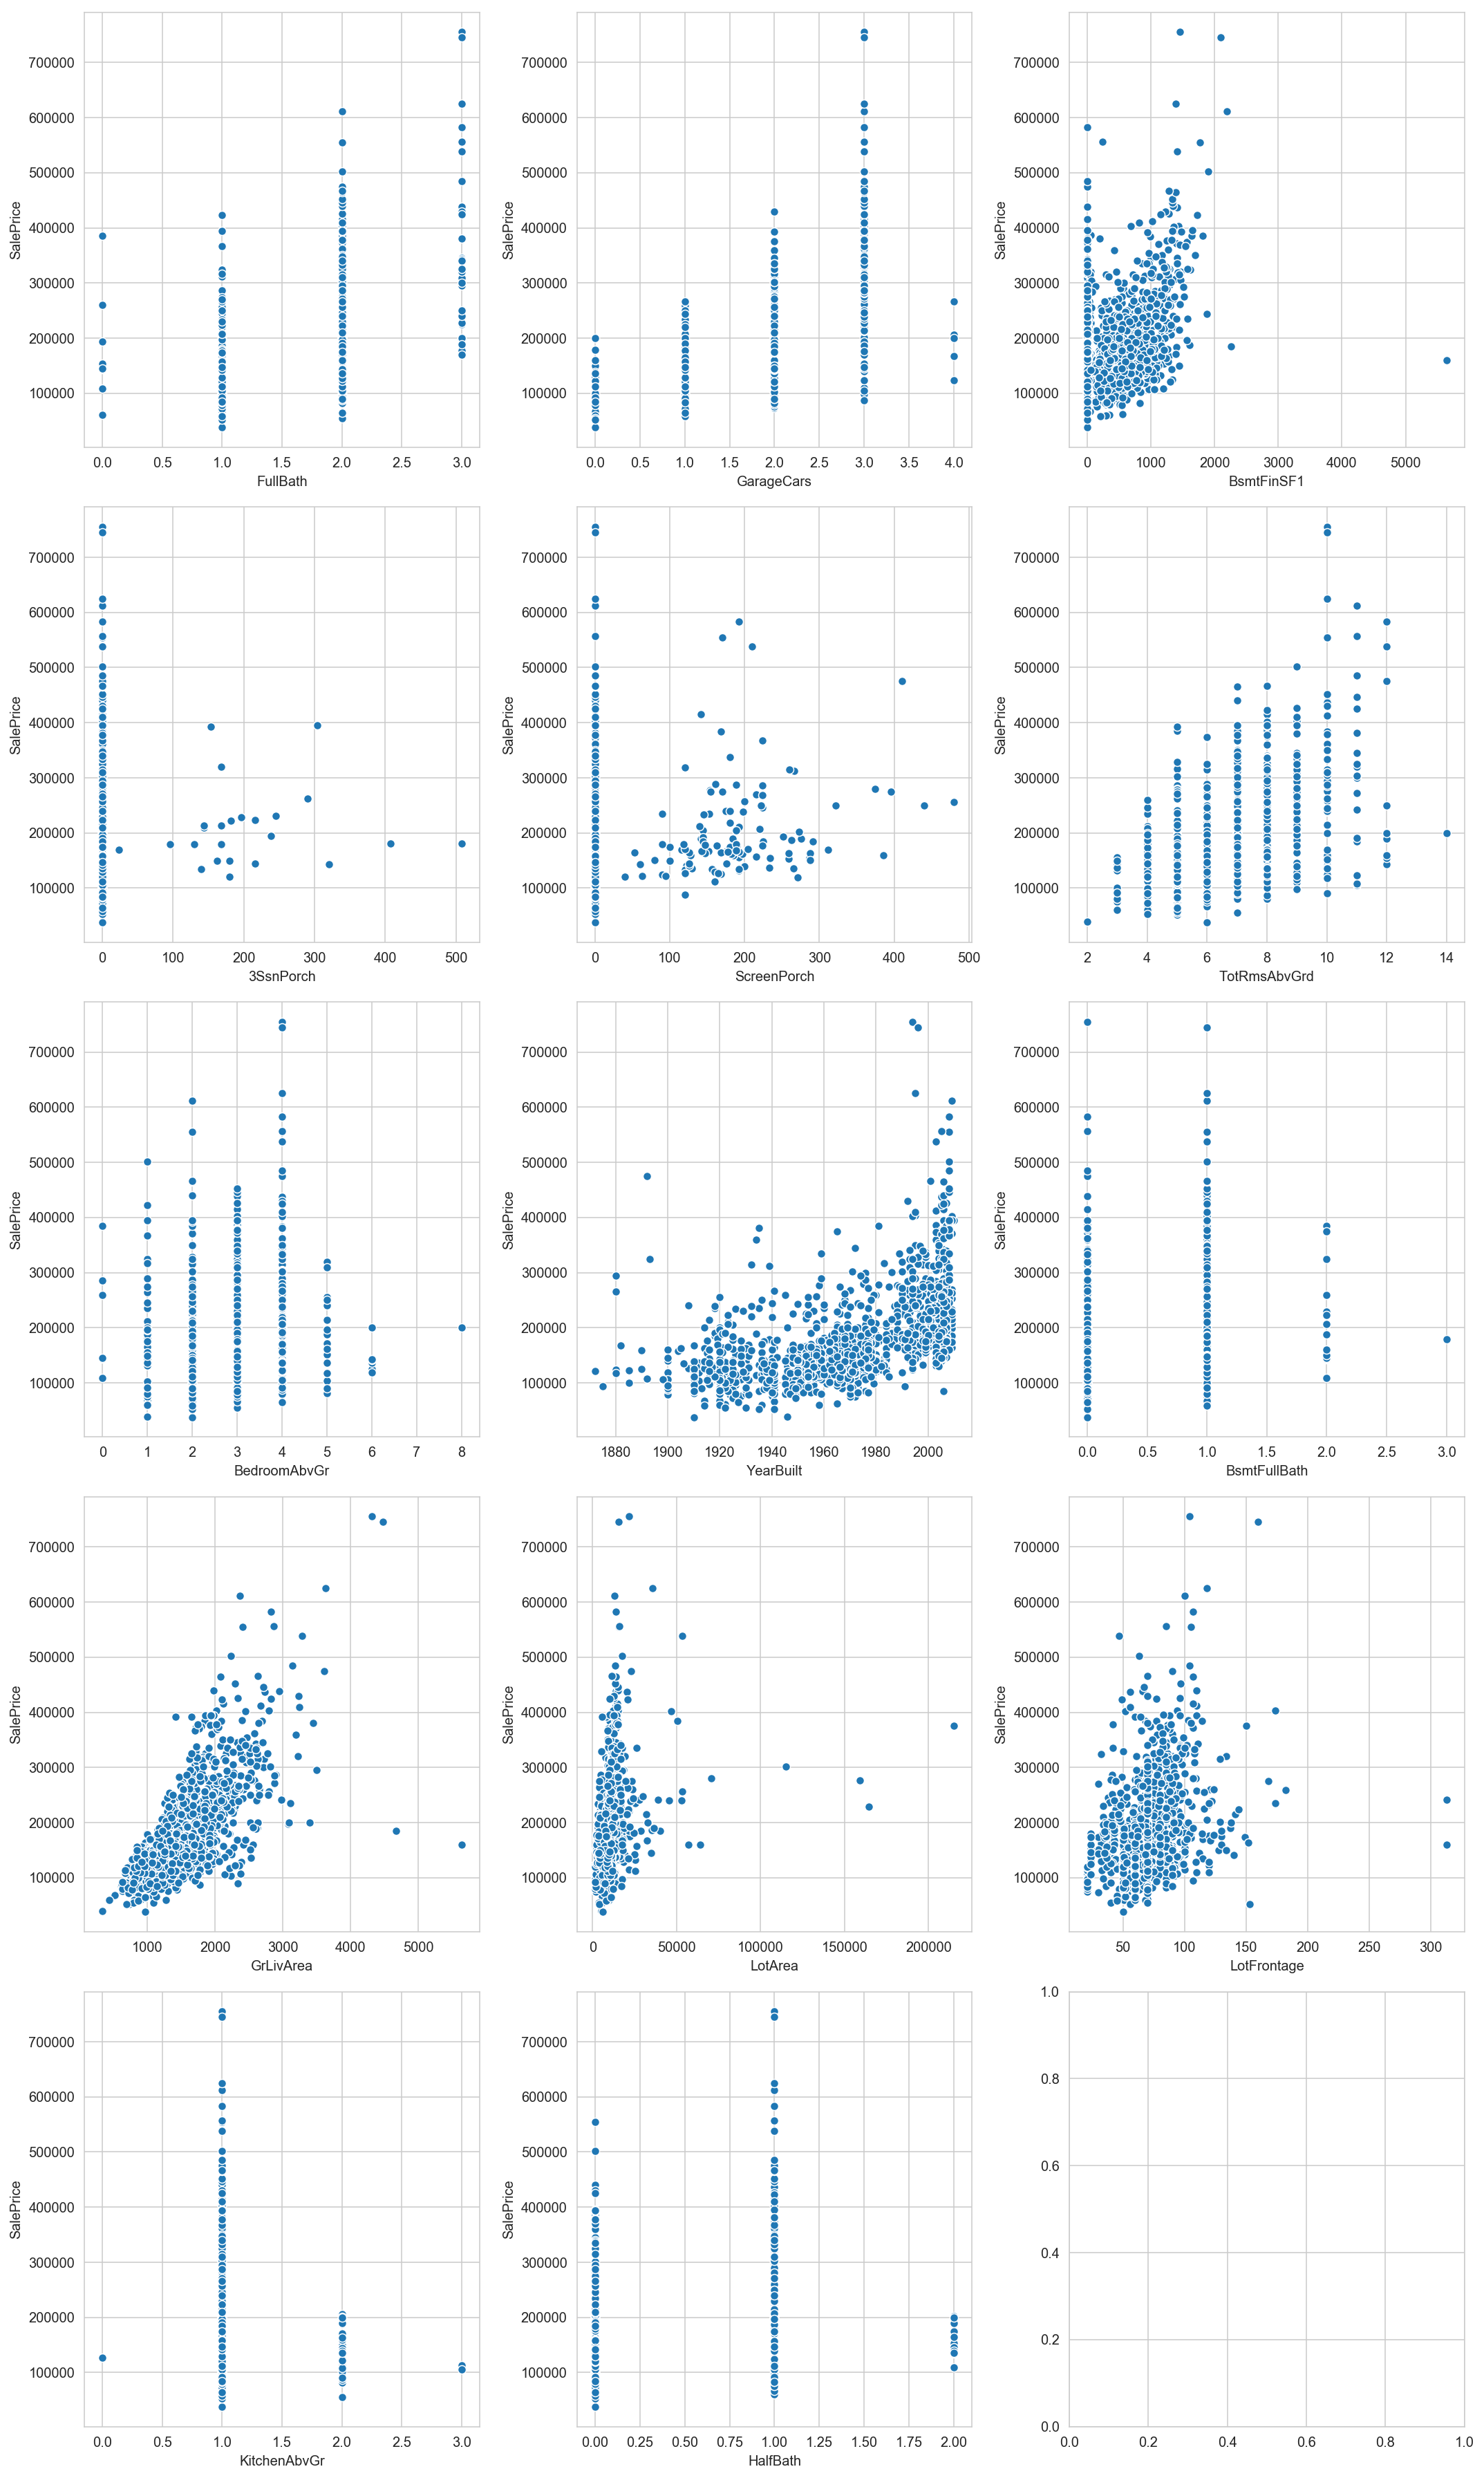

In [62]:
# Creating scatterplot of the 14 fixed features to check for potential outliers
fig, axes = plt.subplots(nrows=5,ncols=3,figsize=(15,25))

for r in range(5):
    for c in range(3):
        try:
            sns.scatterplot(x=feature_check[r*3+c],y='SalePrice',data=house,ax=axes[r][c])
        except IndexError:
            None

plt.tight_layout() 
plt.show()

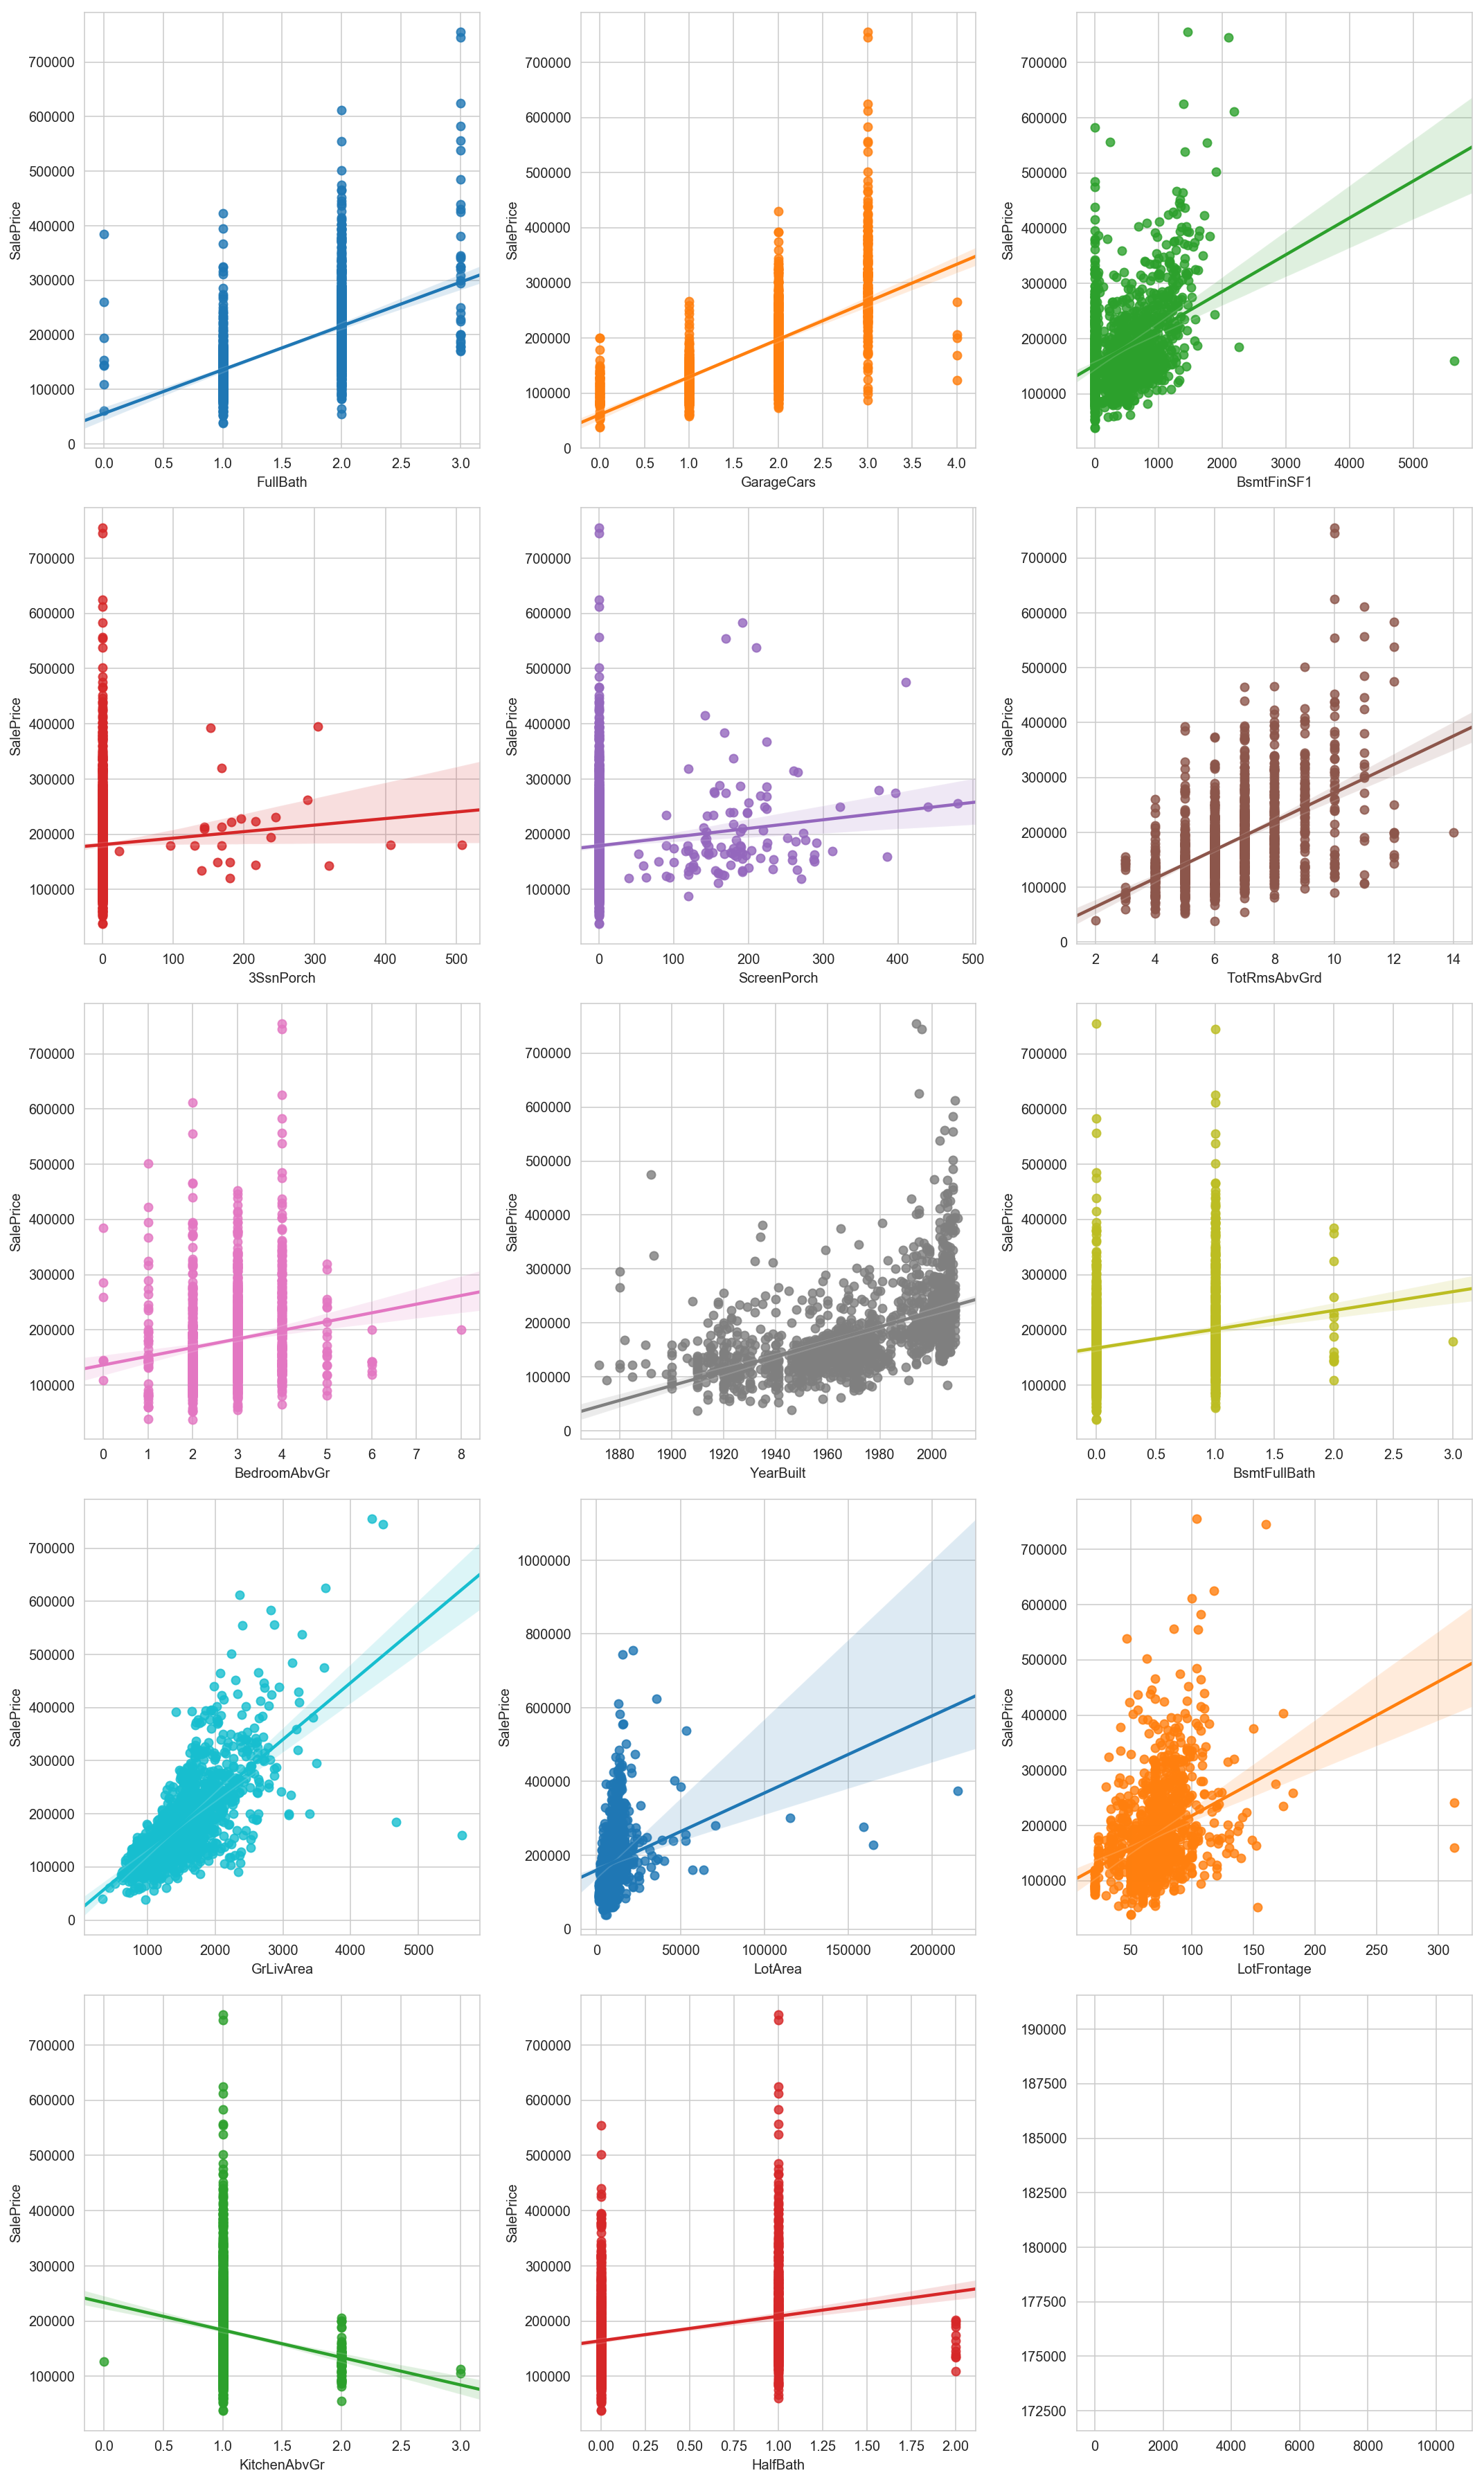

In [63]:
# Creating regression plot of the 14 fixed features to check for potential outliers
fig, axes = plt.subplots(nrows=5,ncols=3,figsize=(15,25))

for r in range(5):
    for c in range(3):
        try:
            sns.regplot(x=feature_check[r*3+c],y='SalePrice',data=house,ax=axes[r][c])
        except IndexError:
            None

plt.tight_layout() 
plt.show()

In [64]:
# Removing outliers from GrLivArea, LotFrontage, LotArea and BsmtFinSF1

# Dropping outliers from GrLivArea
house.drop(house[(house['SalePrice'] < 200000) & (house['GrLivArea'] > 4000)].index, inplace=True)

# Dropping outliers from LotFrontage
house.drop(house[house['LotFrontage'] > 300].index, inplace=True)

# Dropping outliers from LotArea
house.drop(house[house['LotArea'] > 100000].index, inplace=True)

# Dropping outliers from BsmtFinSF1
house.drop(house[house['BsmtFinSF1'] > 5000].index, inplace=True)

house.shape

(1440, 81)

<div class="alert alert-warning">
    
Now that features have been selected and outliers have been handled.

Proceeding to attempt to try out various regression models to see which performs best.

</div>

In [65]:
# Feature engineering with one-hot encoding for fixed features that are categorical
df_fix = pd.concat([house[fixed], pd.get_dummies(house[dummy], drop_first=True), house[['YrSold', 'SalePrice']]], axis=1)

# Reducing columns down to the selected features
df_fix = df_fix[fix_features + ['YrSold', 'SalePrice']]

# Train-Test split based on YrSold of 2010: pre-2010 as train & 2010 as test
y_train = df_fix[df_fix['YrSold'] < 2010]['SalePrice']
y_test = df_fix[df_fix['YrSold'] == 2010]['SalePrice']
X_train = df_fix[df_fix['YrSold'] < 2010].drop(columns=['SalePrice', 'YrSold'])
X_test = df_fix[df_fix['YrSold'] == 2010].drop(columns=['SalePrice', 'YrSold'])

# Converting data to standard scale, only fit to train dataset but scale/transform both train & test
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

Xs_train = pd.DataFrame(Xs_train, columns=X_train.columns)
Xs_test = pd.DataFrame(Xs_test, columns=X_test.columns)

In [66]:
# Applying Linear Regression with the selected features and outliers removed
scores = cross_val_score(lm, X_train, y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

Cross-validated scores: [0.87936108 0.86302697 0.89772919 0.87269663 0.87560945 0.8441379
 0.88474275 0.83885169 0.8613013  0.83660658]
Mean Cross-validated scores: 0.8654063536836027
Std Cross-validated scores: 0.019442440658564507


In [67]:
lm.fit(Xs_train, y_train)

print("Train score:", lm.score(Xs_train, y_train))
print("Test score:", lm.score(Xs_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, lm.predict(Xs_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, lm.predict(Xs_test)))

Train score: 0.8826044234828465
Test score: 0.8835980115630497
Train Mean Squared Error: 732425618.5101471
Train Mean Squared Error: 740013896.7830914


In [68]:
# Applying Ridge Regularized Linear Regression with the selected features and outliers removed

# Finding an optimal value for the ridge regression alpha using RidgeCV
ridge_alphas = np.logspace(-2, 7, 50)

clf = RidgeCV(alphas=ridge_alphas).fit(Xs_train, y_train)

ridge_reg = Ridge()

ridge_reg.set_params(alpha=clf.alpha_)

scores = cross_val_score(ridge_reg, Xs_train, y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

Cross-validated scores: [0.88123647 0.86354297 0.89761686 0.87391198 0.87463293 0.84457433
 0.88484656 0.8380162  0.85933234 0.83859944]
Mean Cross-validated scores: 0.8656310071820666
Std Cross-validated scores: 0.019406625449248333


In [69]:
ridge_reg.fit(Xs_train, y_train)

print("Train score:", ridge_reg.score(Xs_train, y_train))
print("Test score:", ridge_reg.score(Xs_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, ridge_reg.predict(Xs_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, ridge_reg.predict(Xs_test)))

Train score: 0.8825591792040627
Test score: 0.8837790563422344
Train Mean Squared Error: 732707895.4907236
Train Mean Squared Error: 738862922.8664453


In [70]:
# Applying Lasso Regularized Linear Regression with the selected features and outliers removed
# Finding optimal alpha with LassoCV

optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs_train, y_train)

lasso = Lasso(alpha=optimal_lasso.alpha_)

scores = cross_val_score(lasso, Xs_train, y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Cross-validated scores: [0.88201072 0.86408256 0.89721063 0.8758041  0.87397391 0.84189534
 0.8851958  0.83732493 0.86130891 0.84068753]
Mean Cross-validated scores: 0.8659494425952989
Std Cross-validated scores: 0.019566046047010805


..................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished


In [71]:
model = lasso.fit(Xs_train, y_train)
print("Train score:", model.score(Xs_train, y_train))
print("Test score:", model.score(Xs_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, model.predict(Xs_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, model.predict(Xs_test)))

Train score: 0.882453185059842
Test score: 0.88336054070756
Train Mean Squared Error: 733369188.0959686
Train Mean Squared Error: 741523593.7865807


In [72]:
# Applying KNN regressor on various N-Neighbours

n_neighbour = [1, 3, 5, 7, 10, 20]

for n in n_neighbour:    
    knnreg = KNeighborsRegressor(n_neighbors=n)
    knnreg.fit(Xs_train, y_train)

    scores = cross_val_score(knnreg, Xs_train, y_train, cv=10)

    print("N-Neighbours:", n)
    print()
    print("Cross-validated scores:", scores)
    print("Mean Cross-validated scores:", np.mean(scores))
    print("Std Cross-validated scores:", np.std(scores))
    print()
    print("Train score:", knnreg.score(Xs_train, y_train))
    print("Test score:", knnreg.score(Xs_test, y_test))
    print("Train Mean Squared Error:", mean_squared_error(y_train, knnreg.predict(Xs_train)))
    print("Train Mean Squared Error:", mean_squared_error(y_test, knnreg.predict(Xs_test)))
    print("=="*20)

N-Neighbours: 1

Cross-validated scores: [0.7614332  0.59671665 0.75578052 0.79318287 0.71900777 0.70765579
 0.73294842 0.67163928 0.8357873  0.6651408 ]
Mean Cross-validated scores: 0.7239292602386862
Std Cross-validated scores: 0.06517138763589489

Train score: 0.9999848923735486
Test score: 0.7260617910431004
Train Mean Squared Error: 94255.78864353312
Train Mean Squared Error: 1741534523.6802325
N-Neighbours: 3

Cross-validated scores: [0.79872219 0.66053665 0.78940358 0.80689645 0.79116242 0.67582179
 0.77007744 0.75026713 0.80249946 0.69839831]
Mean Cross-validated scores: 0.7543785410712764
Std Cross-validated scores: 0.05290985695894422

Train score: 0.8973814714576254
Test score: 0.8054549187875583
Train Mean Squared Error: 640232293.8229934
Train Mean Squared Error: 1236800724.636951
N-Neighbours: 5

Cross-validated scores: [0.78376491 0.63878718 0.78707108 0.79682702 0.76436588 0.68540018
 0.78148494 0.70736553 0.7914402  0.70986124]
Mean Cross-validated scores: 0.7446368153

In [73]:
# Applying Random Forest Regressor
rfreg = RandomForestRegressor(n_estimators=1000, random_state=42)

scores = cross_val_score(rfreg, Xs_train, y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

Cross-validated scores: [0.9082313  0.82754833 0.86408283 0.86254216 0.86731215 0.86062785
 0.88402125 0.8550722  0.88800745 0.84417633]
Mean Cross-validated scores: 0.8661621854356941
Std Cross-validated scores: 0.021708863138299995


In [74]:
rfreg.fit(Xs_train, y_train)

print("Train score:", rfreg.score(Xs_train, y_train))
print("Test score:", rfreg.score(Xs_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, rfreg.predict(Xs_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, rfreg.predict(Xs_test)))

Train score: 0.9829822747390256
Test score: 0.8710381162793384
Train Mean Squared Error: 106172807.52553518
Train Mean Squared Error: 819862163.7834549


In [75]:
# Applying Supervised Neural Network MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(42,42,42),max_iter=500)

scores = cross_val_score(mlp, Xs_train, y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

Cross-validated scores: [0.87356844 0.83981647 0.89751098 0.75095511 0.89670982 0.64651862
 0.82184914 0.85839028 0.90735486 0.79911768]
Mean Cross-validated scores: 0.8291791411651748
Std Cross-validated scores: 0.07662846524148452


In [76]:
mlp.fit(Xs_train, y_train)

print("Train score:", mlp.score(Xs_train, y_train))
print("Test score:", mlp.score(Xs_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, mlp.predict(Xs_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, mlp.predict(Xs_test)))

Train score: 0.9183531321574016
Test score: 0.8897176700017385
Train Mean Squared Error: 509391064.40942913
Train Mean Squared Error: 701108785.7192153


<div class="alert alert-warning">
    
### Ridge Regularized Linear Regression is the best model

Although the Lasso model also had a similar mean cross-validated $R^2$ score as the Ridge model, the Lasso model had a slightly higher standard deviation.

The model with the highest mean cross-validated $R^2$ score is the Random Forest regressor model, but the train/test scores are highly in favour of the train score (0.9830 vs 0.8706) which might suggest that the model is overfit.

Thus, the Ridge model was selected.

</div>

In [77]:
# Creating DataFrame of actual y & predicted y to evaluate the model
df = pd.DataFrame({'y': y_test, 'y_pred': ridge_reg.predict(Xs_test)})
df['residuals'] = df['y'] - df['y_pred']
df.head()

y         y_pred     residuals
16  149000  146183.392019   2816.607981
24  154000  130635.479295  23364.520705
26  134800  118645.759782  16154.240218
27  306000  323250.390239 -17250.390239
33  165500  186452.852901 -20952.852901

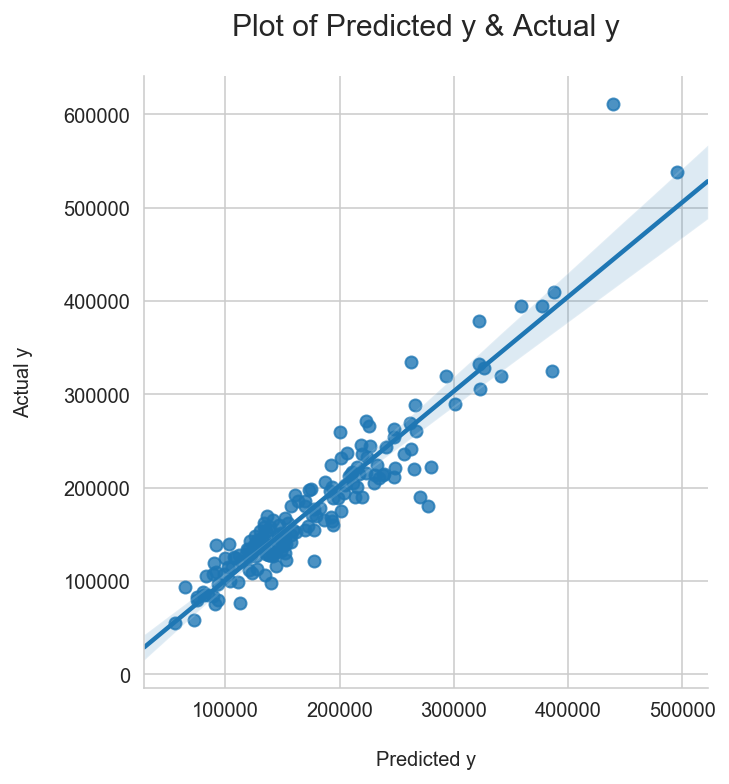

In [78]:
sns.lmplot(x='y_pred', y='y',data=df)
plt.title('Plot of Predicted y & Actual y',fontsize=15, pad=20)
plt.ylabel('Actual y', labelpad=15)
plt.xlabel('Predicted y', labelpad=15)
plt.show()

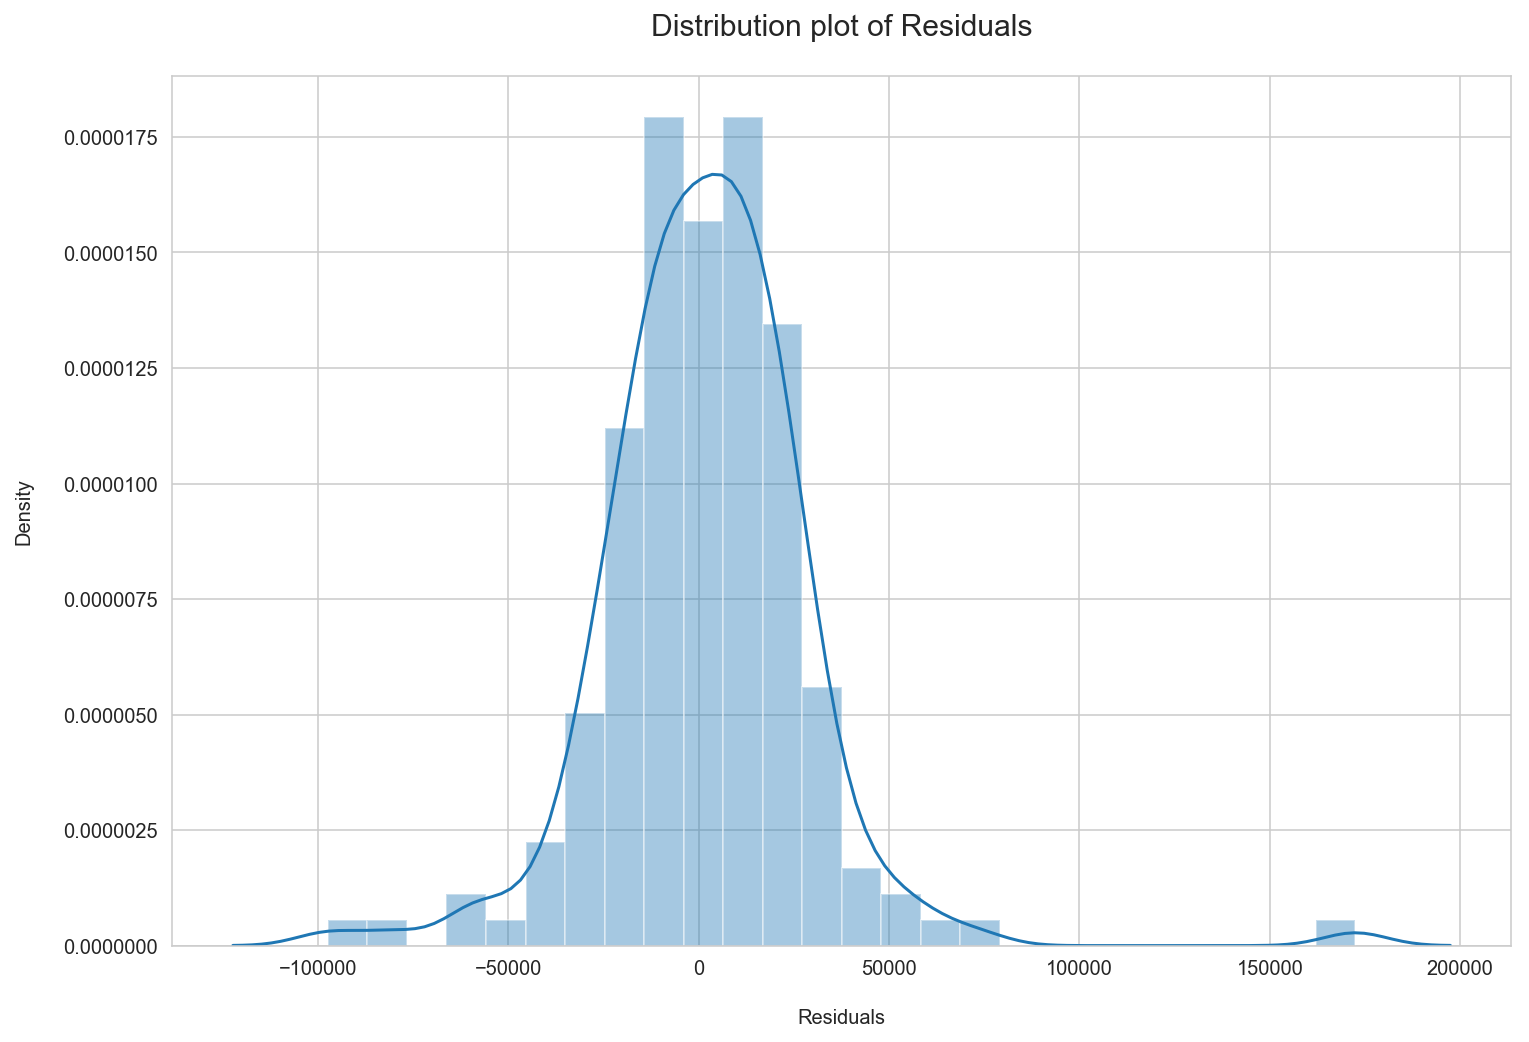

In [79]:
# Plotting the distribution of the residuals
plt.figure(figsize=(12,8))
sns.distplot(df['residuals'])
plt.title('Distribution plot of Residuals',fontsize=15, pad=20)
plt.ylabel('Density', labelpad=15)
plt.xlabel('Residuals', labelpad=15)
plt.show()

<div class="alert alert-warning">

### How well does the model perform?

The ridge regularized linear regression model has the following $R^2$ scores:

| Header | Value|
| --- | ---|
Cross-validated scores: | [0.88123647 0.86354297 0.89761686 0.87391198 0.87463293 0.84457433 0.88484656 0.8380162  0.85933234 0.83859944]
Mean Cross-validated scores: | 0.8656310071820666
Std Cross-validated scores: | 0.01940662544924838
Train score: | 0.8825591792040627
Test score: | 0.8837790563422345

The cross-validated $R^2$ scores are performing relatively well, without any fold which are too far apart from the others.

Although the residuals is quite normally distributed, there seems to be a slight skew to the right. Thus, further tuning of the model is required.

</div>

In [80]:
# Creating DatFrame of the coefficients of the features from the Ridge Regression Model

df_impt = pd.DataFrame(Xs_train.columns, columns=['Name'])
df_impt['Coefficient'] = [round(num,4) for num in ridge_reg.coef_]
df_impt['Abs Coefficient'] = np.abs(df_impt['Coefficient'])

df_impt.sort_values('Abs Coefficient',ascending=False)

Name  Coefficient  Abs Coefficient
8              GrLivArea   38109.1806       38109.1806
32           BsmtQual_Gd  -21487.6799       21487.6799
7            BsmtQual_TA  -20612.8041       20612.8041
18             YearBuilt   12949.3648       12949.3648
33  Neighborhood_NridgHt    9949.3234        9949.3234
17  Neighborhood_NoRidge    8552.4053        8552.4053
30            BsmtFinSF1    7972.5639        7972.5639
29            GarageCars    7650.0846        7650.0846
6           BedroomAbvGr   -7160.4328        7160.4328
26  Neighborhood_StoneBr    7135.0074        7135.0074
40  Neighborhood_Somerst    7092.7588        7092.7588
12          KitchenAbvGr   -6988.3588        6988.3588
39           BsmtQual_Fa   -6796.0710        6796.0710
41       BsmtExposure_Gd    5624.4062        5624.4062
9                LotArea    5525.4968        5525.4968
37        MSSubClass_160   -4953.7272        4953.7272
2          MSSubClass_20    4916.6326        4916.6326
1        BsmtExposure_NA   -4837.0971        4837.0971
25           BsmtQual_NA   -4837.0971        4837.0971
11  Neighborhood_Crawfor    4749.6395        4749.6395
38       BsmtExposure_No   -3923.4751        3923.4751
34          TotRmsAbvGrd    3478.9828        3478.9828
21  Neighborhood_Mitchel   -3095.0922        3095.0922
28         GarageType_NA    2603.3071        2603.3071
10         LandSlope_Sev   -2586.7229        2586.7229
15              FullBath    2454.5804        2454.5804
5        Condition2_PosA    2454.4935        2454.4935
13       LandContour_HLS    2400.4870        2400.4870
14  Neighborhood_Veenker    2389.6530        2389.6530
4            ScreenPorch    2303.9069        2303.9069
23         LotConfig_FR2   -2203.9090        2203.9090
22  Neighborhood_Edwards   -2014.3314        2014.3314
3        LandContour_Lvl    1974.4190        1974.4190
0       Condition1_Feedr   -1955.1537        1955.1537
20       Condition1_RRAe   -1719.7947        1719.7947
24           Street_Pave    1444.5131        1444.5131
31             3SsnPorch    1170.0765        1170.0765
27          LotShape_IR3    -720.7666         720.7666
36           LotFrontage     605.3971         605.3971
35              HalfBath     518.1363         518.1363
16       Condition2_PosN     127.9094         127.9094
19          BsmtFullBath     118.5903         118.5903

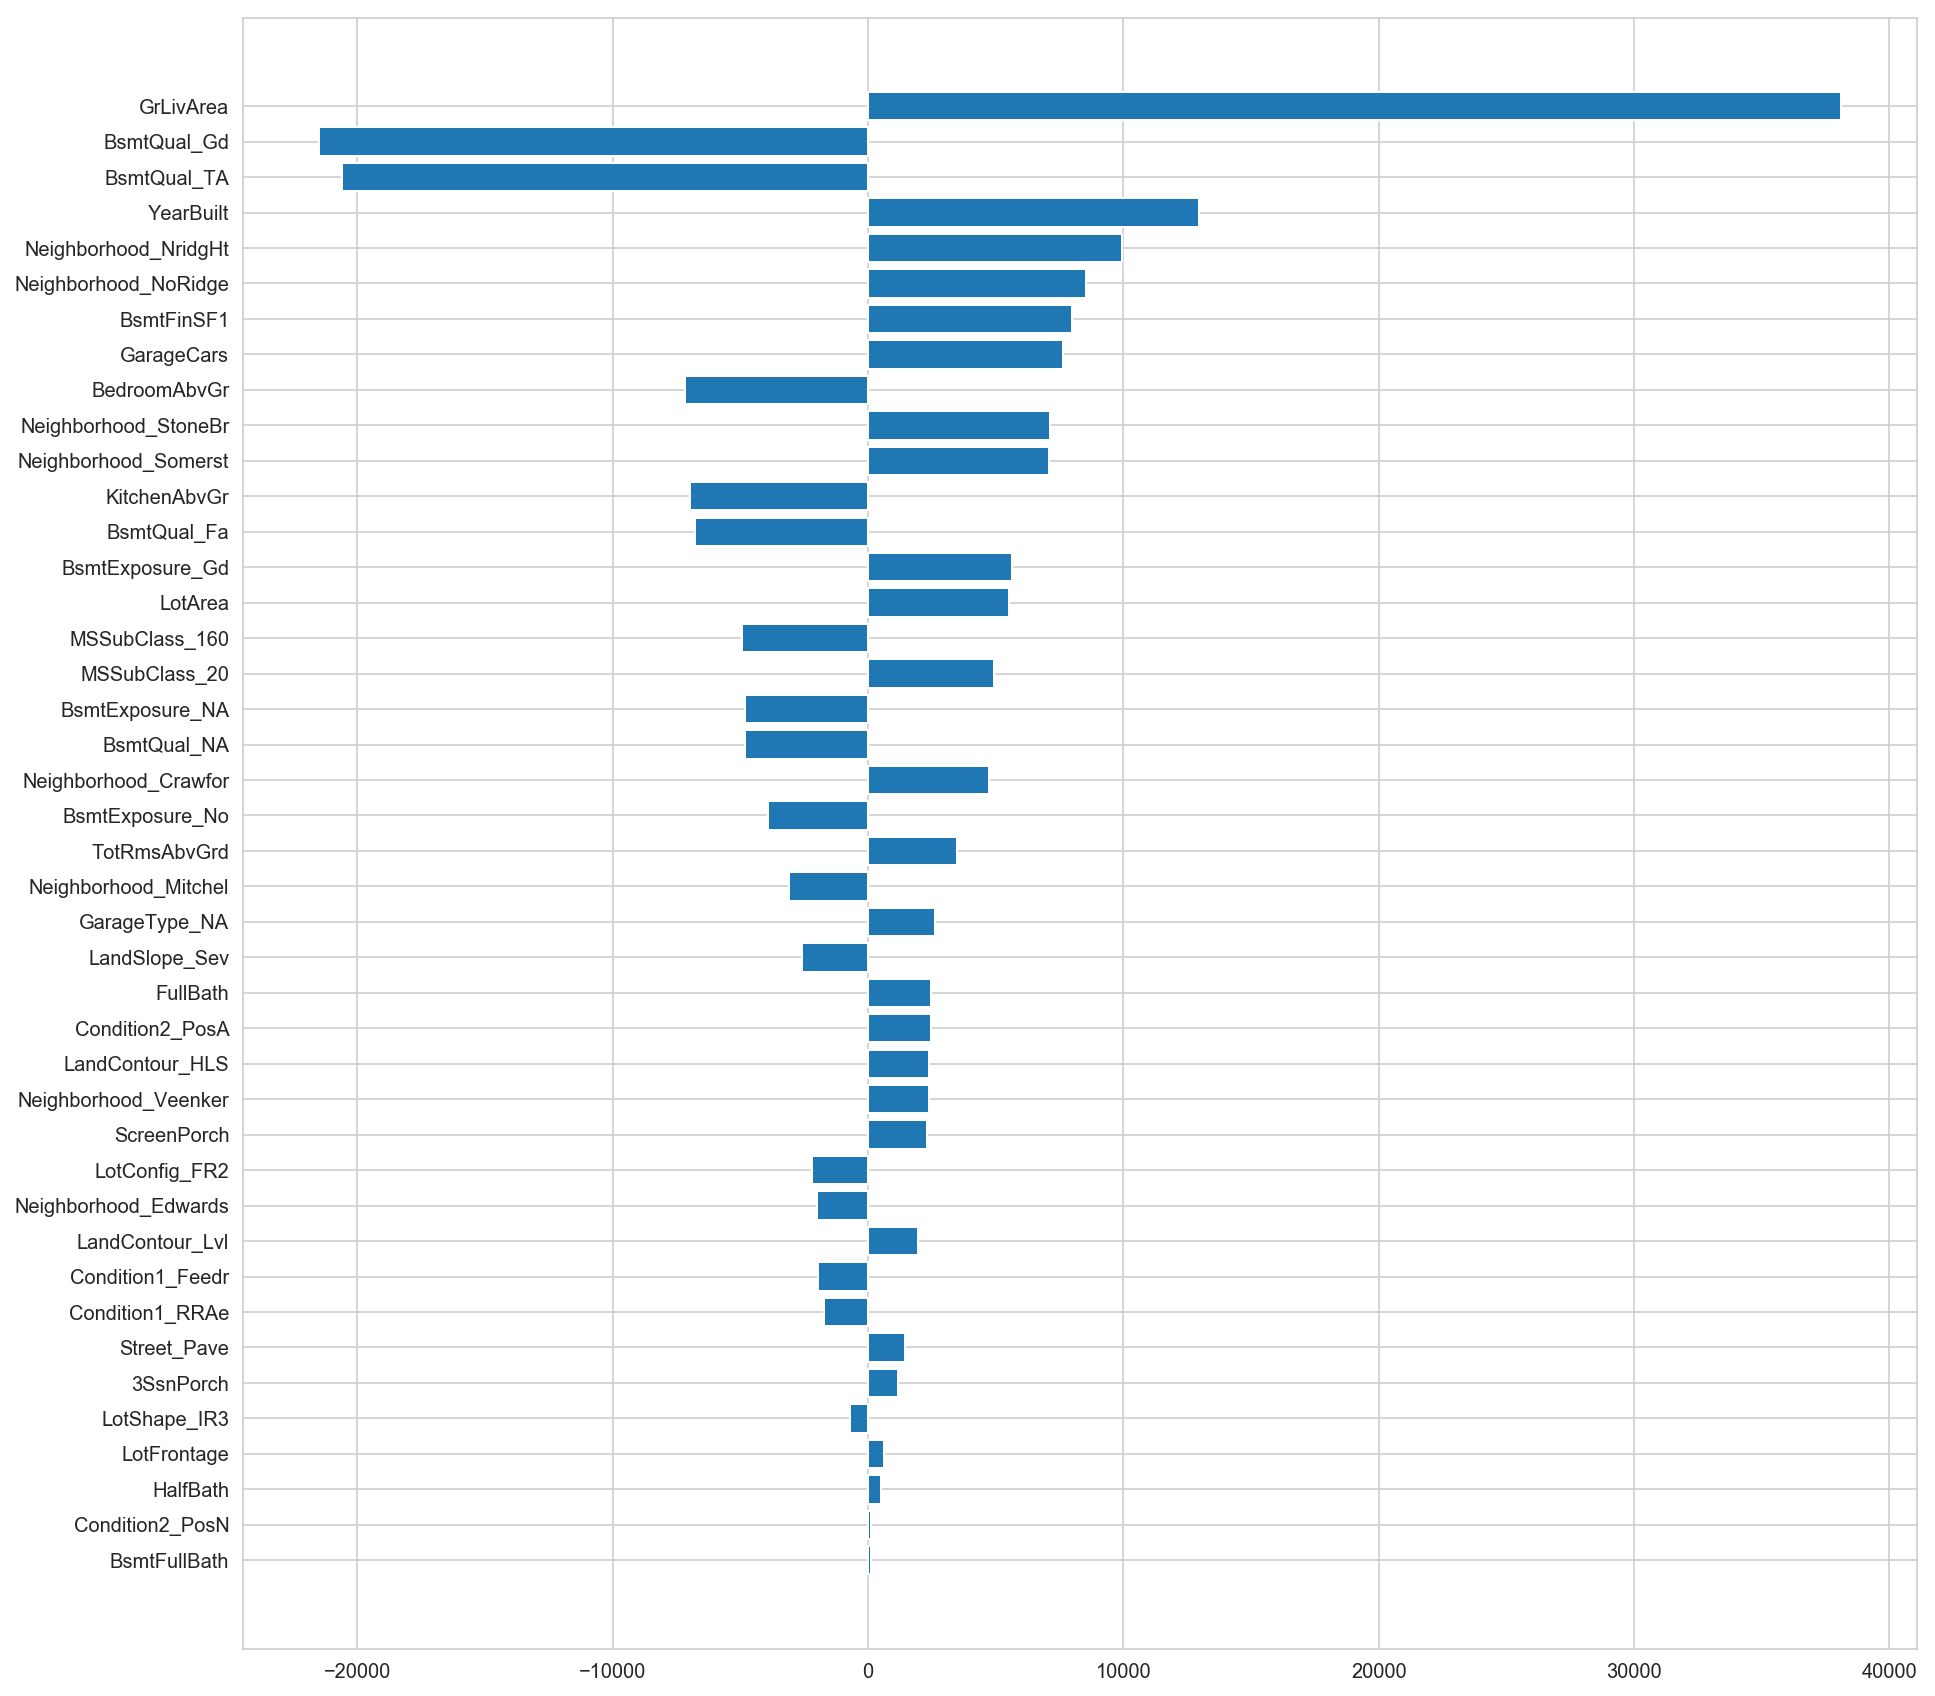

In [81]:
# Plotting the coefficients
df_impt = df_impt.sort_values('Abs Coefficient',ascending=True)

plt.figure(figsize=(15,15))
plt.barh(y=df_impt['Name'], width=df_impt['Coefficient'])
plt.show()

<div class="alert alert-warning">

### What are the best estimates of price?

The top features affecting price are the following features:
   - The amount of living area above ground (GrLivArea)
       - This is intuitive as house prices are dependent on the size of the house in sqft
       
   - The height and size of the basement
       - The amount of basement space and how deep it goes probably affects the price since houses with smaller basements would lead to storage issues etc.
       
   - How old the house is (YearBuilt)
       - This is also intuitive as house prices are affected by how old the house is. The newer the house, the higher the price.
       
   - Neighbourhood
       - This is intuitive as well. The better the neighbourhood, the higher the housing prices. The houses built on prime land due to it's location are normally worth more as compared to those that are built in rural locations.
       
   - The size of the garage (GarageCars)
       - The amount of space in the garage probably affects the house price. The larger the garage space the higher the price.
       
</div>

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [82]:
# Combining the train and test sets to calculate the residuals of the entire dataset
Xs = pd.concat([Xs_train, Xs_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)
print(Xs.shape)
print(y.shape)

(1440, 42)
(1440,)


In [83]:
y_prediction = rfreg.predict(Xs)
fix_residuals = y - y_prediction
resid = pd.DataFrame(list(fix_residuals), columns=['fix_resid'])

<div class="alert alert-warning">
    
## Attempted 2 different ways to obtain a model to answer the questions

### Option 1:
The attempt bounded by the blue markdown portions is attempting to build a model purely based on the renovate-able features. This would then provide a model by which we can estimate the change in price by changing the renovatable features. The renovatable features are then added on to the fixed features and a new model is created, this is to ensure that the features chosen in the previous model for the fixed features are not lost.

The company would be able to apply the first model (M1) which is purely only fixed features and the second model (M2) which is purely on renovate-able features to appropriately buy - sell or buy, renovate - sell.

Via this option, the company would be able to identify which houses are undervalued based on the fixed features from M1 and then be able to compute the upside from renovating the renovate-able features in M2.

### Option 2:
The attempt bounded by the red markdown portions is attempting to build a model without worrying about the previous model. This means we are attempting to build a model by applying all features (fixed and renovate-able). The model created would then be able to predict house price based on both fixed and renovate-able features. However, the fixed features in this model would most probably not be the same as the ones in the previous model.

Using this option, the company would be able to select undervalued houses based on both fixed and renovate-able features. Although the result is similar to Option 1, the difference lies in that the company would not need to bother with the previous model at all.

However, I would prefer Option 2 if it's able to provide a better model as a predictor of sale price. There is no real need to have 2 different models to evaluate housing price based on fixed and renovate-able features. Since houses would definitely have both.

</div>

<div class="alert alert-info">

# Option 1

</div>

In [84]:
# Finding object type columns and apply one-hot encoding via get_dummies
encode_dummy = []
for col in house[reno].columns:
    if house[col].dtype == 'O':
        encode_dummy.append(col)

df_reno = pd.concat([house[reno], pd.get_dummies(house[encode_dummy], drop_first=True), house[['YrSold', 'SalePrice']]], axis=1)
df_reno.drop(columns=encode_dummy, inplace=True)

df_reno.head()

OverallQual  OverallCond  MasVnrArea  Fireplaces  MiscVal  \
0            7            5       196.0           0        0   
1            6            8         0.0           1        0   
2            7            5       162.0           1        0   
3            7            5         0.0           1        0   
4            8            5       350.0           1        0   

   Utilities_NoSeWa  RoofStyle_Gable  RoofStyle_Gambrel  RoofStyle_Hip  \
0                 0                1                  0              0   
1                 0                1                  0              0   
2                 0                1                  0              0   
3                 0                1                  0              0   
4                 0                1                  0              0   

   RoofStyle_Mansard  RoofStyle_Shed  RoofMatl_Membran  RoofMatl_Metal  \
0                  0               0                 0               0   
1                  0               0                 0               0   
2                  0               0                 0               0   
3                  0               0                 0               0   
4                  0               0                 0               0   

   RoofMatl_Roll  RoofMatl_Tar&Grv  RoofMatl_WdShake  RoofMatl_WdShngl  \
0              0                 0                 0                 0   
1              0                 0                 0                 0   
2              0                 0                 0                 0   
3              0                 0                 0                 0   
4              0                 0                 0                 0   

   Exterior1st_AsphShn  Exterior1st_BrkComm  Exterior1st_BrkFace  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   Exterior1st_CBlock  Exterior1st_CemntBd  Exterior1st_HdBoard  \
0                   0                    0                    0   
1                   0                    0                    0   
2                   0                    0                    0   
3                   0                    0                    0   
4                   0                    0                    0   

   Exterior1st_ImStucc  Exterior1st_MetalSd  Exterior1st_Plywood  \
0                    0                    0                    0   
1                    0                    1                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   Exterior1st_Stone  Exterior1st_Stucco  Exterior1st_VinylSd  \
0                  0                   0                    1   
1                  0                   0                    0   
2                  0                   0                    1   
3                  0                   0                    0   
4                  0                   0                    1   

   Exterior1st_Wd Sdng  Exterior1st_WdShing  Exterior2nd_AsphShn  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    1                    0                    0   
4                    0                    0                    0   

   Exterior2nd_Brk Cmn  Exterior2nd_BrkFace  Exterior2nd_CBlock  \
0                    0                    0                   0   
1                    0                    0                   0   
2                    0                    0                  

In [85]:
# Train-Test split based on YrSold of 2010: pre-2010 as train & 2010 as test
y_train = df_reno[df_reno['YrSold'] < 2010]['SalePrice']
y_test = df_reno[df_reno['YrSold'] == 2010]['SalePrice']
X_train = df_reno[df_reno['YrSold'] < 2010].drop(columns=['SalePrice', 'YrSold'])
X_test = df_reno[df_reno['YrSold'] == 2010].drop(columns=['SalePrice', 'YrSold'])

# Converting data to standard scale, only fit to train dataset but scale/transform both train & test
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

Xs_train = pd.DataFrame(Xs_train, columns=X_train.columns)
Xs_test = pd.DataFrame(Xs_test, columns=X_test.columns)

In [86]:
# Applying Linear Regression model with all features
lr = LinearRegression()

scores = cross_val_score(lr, X_train, y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

Cross-validated scores: [0.7233719  0.59426914 0.76837405 0.72786548 0.7709346  0.68466902
 0.64994014 0.66559858 0.66893684 0.72810344]
Mean Cross-validated scores: 0.6982063202654941
Std Cross-validated scores: 0.052778318540772175


In [87]:
model = lr.fit(X_train, y_train)
print("Train score:", model.score(X_train, y_train))
print("Test score:", model.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, model.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, model.predict(X_test)))

Train score: 0.7943608266406055
Test score: 0.7738004075384001
Train Mean Squared Error: 1282973372.6437507
Train Mean Squared Error: 1438041086.032855


In [88]:
# Applying Lasso Regularized Linear Regression model for forced feature selection
# Finding optimal alpha with LassoCV

roptimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
roptimal_lasso.fit(Xs_train, y_train)

print(roptimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

815.7978433453711


..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s finished


In [89]:
rlasso = Lasso(alpha=roptimal_lasso.alpha_)

scores = cross_val_score(rlasso, Xs_train, y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

Cross-validated scores: [0.73368895 0.70672139 0.78807501 0.74876633 0.76925532 0.69244043
 0.71989591 0.68468982 0.67582652 0.79734009]
Mean Cross-validated scores: 0.7316699776565336
Std Cross-validated scores: 0.04102286726917879


In [90]:
model = rlasso.fit(Xs_train, y_train)
print("Train score:", model.score(Xs_train, y_train))
print("Test score:", model.score(Xs_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, model.predict(Xs_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, model.predict(Xs_test)))

Train score: 0.7777174850244787
Test score: 0.7601205002400495
Train Mean Squared Error: 1386810417.777101
Train Mean Squared Error: 1525009716.4095361


In [91]:
# Print the coefficients for the Lasso Regularized Linear Regression Model
df_coef = pd.DataFrame(rlasso.coef_, columns=['coef'])

df_coef['names'] = X_train.columns
df_coef['abs coef'] = np.abs(df_coef['coef'])

df_coef.sort_values('abs coef',ascending=False)

coef                names      abs coef
0    34605.408718          OverallQual  34605.408718
88  -18305.118004       KitchenQual_TA  18305.118004
2    14541.393669           MasVnrArea  14541.393669
87  -13260.481925       KitchenQual_Gd  13260.481925
51  -11982.442323         ExterQual_TA  11982.442323
3    11538.027767           Fireplaces  11538.027767
117  -6963.011533            PoolQC_NA   6963.011533
16    6925.871560     RoofMatl_WdShngl   6925.871560
50   -6105.852751         ExterQual_Gd   6105.852751
46   -5812.611380   MasVnrType_BrkFace   5812.611380
86   -4844.757688       KitchenQual_Fa   4844.757688
61    4752.111413     BsmtFinType1_GLQ   4752.111413
102  -4249.280701     GarageFinish_Unf   4249.280701
6    -3530.770031      RoofStyle_Gable   3530.770031
65   -3173.880404     BsmtFinType1_Unf   3173.880404
115  -2582.044785            PoolQC_Fa   2582.044785
37    2518.527163  Exterior2nd_ImStucc   2518.527163
45   -2273.897824  Exterior2nd_Wd Shng   2273.897824
80   -2251.324550         HeatingQC_TA   2251.324550
19    2141.904299  Exterior1st_BrkFace   2141.904299
78   -1710.775316         HeatingQC_Gd   1710.775316
43    1643.678987  Exterior2nd_VinylSd   1643.678987
100  -1595.655684      GarageFinish_NA   1595.655684
21    1562.307647  Exterior1st_CemntBd   1562.307647
1     1513.873699          OverallCond   1513.873699
89   -1457.961619      Functional_Maj2   1457.961619
5    -1408.603997     Utilities_NoSeWa   1408.603997
116  -1343.466158            PoolQC_Gd   1343.466158
40    1060.471848  Exterior2nd_Plywood   1060.471848
114    982.178003         PavedDrive_Y    982.178003
..            ...                  ...           ...
11       0.000000     RoofMatl_Membran      0.000000
10       0.000000       RoofStyle_Shed      0.000000
9        0.000000    RoofStyle_Mansard      0.000000
8        0.000000        RoofStyle_Hip      0.000000
7        0.000000    RoofStyle_Gambrel      0.000000
4       -0.000000              MiscVal      0.000000
33      -0.000000  Exterior2nd_BrkFace      0.000000
35       0.000000  Exterior2nd_CmentBd      0.000000
76       0.000000         Heating_Wall      0.000000
36      -0.000000  Exterior2nd_HdBoard      0.000000
72      -0.000000         Heating_GasA      0.000000
70      -0.000000     BsmtFinType2_Rec      0.000000
69      -0.000000      BsmtFinType2_NA      0.000000
68       0.000000     BsmtFinType2_LwQ      0.000000
67       0.000000     BsmtFinType2_GLQ      0.000000
66      -0.000000     BsmtFinType2_BLQ      0.000000
64      -0.000000     BsmtFinType1_Rec      0.000000
62      -0.000000     BsmtFinType1_LwQ      0.000000
60       0.000000     BsmtFinType1_BLQ      0.000000
59      -0.000000          BsmtCond_TA      0.000000
58       0.000000          BsmtCond_Po      0.000000
57      -0.000000          BsmtCond_NA      0.000000
55       0.000000         ExterCond_TA      0.000000
54       0.000000         ExterCond_Po      0.000000
53      -0.000000         ExterCond_Gd      0.000000
47       0.000000      MasVnrType_None      0.000000
42      -0.000000   Exterior2nd_Stucco      0.000000
41       0.000000    Exterior2nd_Stone      0.000000
38      -0.000000  Exterior2nd_MetalSd      0.000000
125     -0.000000     MiscFeature_TenC      0.000000

[126 rows x 3 columns]

In [92]:
# Printing out the number of selected features, the percentage of features removed and the selected features
print('Percent features removed:', np.sum((rlasso.coef_ == 0))/float(len(rlasso.coef_)))
reno_features = list(df_coef[df_coef['coef']!=0]['names'])
print('Number of selected features:', len(reno_features))
print()
print(reno_features)

Percent features removed: 0.5317460317460317
Number of selected features: 59

['OverallQual', 'OverallCond', 'MasVnrArea', 'Fireplaces', 'Utilities_NoSeWa', 'RoofStyle_Gable', 'RoofMatl_WdShngl', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CemntBd', 'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_WdShing', 'Exterior2nd_Brk Cmn', 'Exterior2nd_ImStucc', 'Exterior2nd_Other', 'Exterior2nd_Plywood', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'Exterior2nd_Wd Shng', 'MasVnrType_BrkFace', 'MasVnrType_Stone', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'ExterCond_Fa', 'BsmtCond_Gd', 'BsmtFinType1_GLQ', 'BsmtFinType1_Unf', 'BsmtFinType2_Unf', 'Heating_GasW', 'Heating_Grav', 'Heating_OthW', 'HeatingQC_Fa', 'HeatingQC_Gd', 'HeatingQC_TA', 'Electrical_FuseF', 'Electrical_SBrkr', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA', 'Functional_Maj2', 'Functional_Min2', 'Functional_Mod', 'Functional_Sev', 'FireplaceQu_Fa', 'FireplaceQu_Po', 'GarageFinish_NA', 'GarageFin

In [93]:
# Checking summary of the Linear Model of Selected Features using statsmodel
model = sm.OLS(y_train.values, sm.add_constant(Xs_train[reno_features]).values)
model = model.fit()
model.summary(xname=['Constant'] + reno_features)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     77.54
Date:                Wed, 16 Jan 2019   Prob (F-statistic):               0.00
Time:                        16:37:22   Log-Likelihood:                -15115.
No. Observations:                1268   AIC:                         3.035e+04
Df Residuals:                    1209   BIC:                         3.065e+04
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Constant             1.815e+05   1045.620    173.602      0.000    1.79e+05    1.84e+05
OverallQual          3.019e+04   1922.151     15.706      0.000    2.64e+04     3.4e+04
OverallCond          2797.5775   1199.959      2.331      0.020     443.345    5151.810
MasVnrArea           1.544e+04   1511.518     10.214      0.000    1.25e+04    1.84e+04
Fireplaces           1.193e+04   1238.327      9.637      0.000    9504.322    1.44e+04
Utilities_NoSeWa    -2256.0493   1069.451     -2.110      0.035   -4354.236    -157.863
RoofStyle_Gable     -3393.2740   1141.909     -2.972      0.003   -5633.617   -1152.931
RoofMatl_WdShngl     7889.7210   1076.157      7.331      0.000    5778.378       1e+04
Exterior1st_BrkComm -1257.6615   1371.487     -0.917      0.359   -3948.421    1433.098
Exterior1st_BrkFace  2842.1718   1125.681      2.525      0.012     633.666    5050.678
Exterior1st_CemntBd  1351.1719   1173.110      1.152      0.250    -950.386    3652.729
Exterior1st_Stone     914.5428   1068.015      0.856      0.392   -1180.826    3009.911
Exterior1st_Stucco  -1714.6114   1135.790     -1.510      0.131   -3942.949     513.727
Exterior1st_WdShing -1458.8914   1304.173     -1.119      0.264   -4017.585    1099.802
Exterior2nd_Brk Cmn  -448.6530   1305.903     -0.344      0.731   -3010.741    2113.435
Exterior2nd_ImStucc  2494.7062   1099.431      2.269      0.023     337.701    4651.711
Exterior2nd_Other    1828.0925   1051.717      1.738      0.082    -235.301    3891.486
Exterior2nd_Plywood  2488.0116   1188.610      2.093      0.037     156.045    4819.978
Exterior2nd_VinylSd  2785.8525   1486.055      1.875      0.061    -129.680    5701.385
Exterior2nd_Wd Sdng  -643.8739   1219.824     -0.528      0.598   -3037.080    1749.332
Exterior2nd_Wd Shng -1978.2358   1316.482     -1.503      0.133   -4561.079     604.608
MasVnrType_BrkFace  -7290.9623   1507.971     -4.835      0.000   -1.02e+04   -4332.432
MasVnrType_Stone     -307.8455   1292.581     -0.238      0.812   -2843.797    2228.106
ExterQual_Fa        -3164.2586   1358.485     -2.329      0.020   -5829.509    -499.009
ExterQual_Gd         -1.85e+04   3518.573     -5.259      0.000   -2.54e+04   -1.16e+04
ExterQual_TA        -2.391e+04   3983.836     -6.002      0.000   -3.17e+04   -1.61e+04
ExterCond_Fa          -61.5435   1167.958     -0.053      0.958   -2352.992    2229.905
BsmtCond_Gd           990.2149   1072.411      0.923      0.356   -1113.779    3094.208
BsmtFinType1_GLQ     4789.5265   1492.327      3.209      0.001    1861.688    7717.365
BsmtFinType1_Unf    -3156.9203   1398.936     -2.257      0.024   -5901.532    -412.308
BsmtFinType2_Unf     -833.3966   1177.210     -0.708      0.479   -3142.999    1476.206
Heating_GasW         2308.6546   1131.711      2.040      0.042      88.318    4528.991
Hea

In [94]:
# Creating a DataFrame of the features and their respective p-values
df_pvalue = pd.DataFrame(['Constant'] + reno_features, columns=['names'])
df_pvalue['p-value'] = model.pvalues

# Identifying features which have p-value > 0.05 for removal
pvalue_remove = list(df_pvalue[df_pvalue['p-value'] > 0.05]['names'])

pvalue_remove

['Exterior1st_BrkComm',
 'Exterior1st_CemntBd',
 'Exterior1st_Stone',
 'Exterior1st_Stucco',
 'Exterior1st_WdShing',
 'Exterior2nd_Brk Cmn',
 'Exterior2nd_Other',
 'Exterior2nd_VinylSd',
 'Exterior2nd_Wd Sdng',
 'Exterior2nd_Wd Shng',
 'MasVnrType_Stone',
 'ExterCond_Fa',
 'BsmtCond_Gd',
 'BsmtFinType2_Unf',
 'Heating_Grav',
 'Heating_OthW',
 'HeatingQC_Fa',
 'Electrical_FuseF',
 'Electrical_SBrkr',
 'Functional_Min2',
 'Functional_Mod',
 'Functional_Sev',
 'FireplaceQu_Fa',
 'FireplaceQu_Po',
 'GarageFinish_NA',
 'GarageFinish_RFn',
 'GarageQual_Gd',
 'GarageQual_NA',
 'GarageQual_TA',
 'GarageCond_TA',
 'PavedDrive_Y',
 'Fence_NA']

In [95]:
# Removing the features with p-value > 0.05 from the selected features from Lasso
reno_features = list(set(reno_features) - set(pvalue_remove))

reno_features

['MasVnrType_BrkFace',
 'HeatingQC_TA',
 'KitchenQual_TA',
 'PoolQC_Fa',
 'BsmtFinType1_GLQ',
 'Functional_Maj2',
 'Exterior1st_BrkFace',
 'GarageFinish_Unf',
 'HeatingQC_Gd',
 'Heating_GasW',
 'ExterQual_Fa',
 'ExterQual_TA',
 'MasVnrArea',
 'OverallQual',
 'PoolQC_NA',
 'Utilities_NoSeWa',
 'RoofStyle_Gable',
 'ExterQual_Gd',
 'BsmtFinType1_Unf',
 'PoolQC_Gd',
 'Exterior2nd_ImStucc',
 'KitchenQual_Gd',
 'Exterior2nd_Plywood',
 'Fireplaces',
 'OverallCond',
 'RoofMatl_WdShngl',
 'KitchenQual_Fa']

In [96]:
df = pd.concat([df_fix[fix_features], df_reno[reno_features], house[['YrSold', 'SalePrice']]], axis=1)
df.head()

Condition1_Feedr  BsmtExposure_NA  MSSubClass_20  LandContour_Lvl  \
0                 0                0              0                1   
1                 1                0              1                1   
2                 0                0              0                1   
3                 0                0              0                1   
4                 0                0              0                1   

   ScreenPorch  Condition2_PosA  BedroomAbvGr  BsmtQual_TA  GrLivArea  \
0            0                0             3            0       1710   
1            0                0             3            0       1262   
2            0                0             3            0       1786   
3            0                0             3            1       1717   
4            0                0             4            0       2198   

   LotArea  LandSlope_Sev  Neighborhood_Crawfor  KitchenAbvGr  \
0     8450              0                     0             1   
1     9600              0                     0             1   
2    11250              0                     0             1   
3     9550              0                     1             1   
4    14260              0                     0             1   

   LandContour_HLS  Neighborhood_Veenker  FullBath  Condition2_PosN  \
0                0                     0         2                0   
1                0                     1         2                0   
2                0                     0         2                0   
3                0                     0         1                0   
4                0                     0         2                0   

   Neighborhood_NoRidge  YearBuilt  BsmtFullBath  Condition1_RRAe  \
0                     0       2003             1                0   
1                     0       1976             0                0   
2                     0       2001             1                0   
3                     0       1915             1                0   
4                     1       2000             1                0   

   Neighborhood_Mitchel  Neighborhood_Edwards  LotConfig_FR2  Street_Pave  \
0                     0                     0              0            1   
1                     0                     0              1            1   
2                     0                     0              0            1   
3                     0                     0              0            1   
4                     0                     0              1            1   

   BsmtQual_NA  Neighborhood_StoneBr  LotShape_IR3  GarageType_NA  GarageCars  \
0            0                     0             0              0           2   
1            0                     0             0              0           2   
2            0                     0             0              0           2   
3            0                     0             0              0           3   
4            0                     0             0              0           3   

   BsmtFinSF1  3SsnPorch  BsmtQual_Gd  Neighborhood_NridgHt  TotRmsAbvGrd  \
0         706          0            1                     0             8   
1         978          0            1                     0             6   
2         486          0            1                     0             6   
3         216          0            0                     0             7   
4         655          0            1                     0             9   

   HalfBath  LotFrontage  MSSubClass_160  BsmtExposure_No  BsmtQual_Fa  \
0         1         65.0               0                1            0   
1         0         80.0               0                0            0   
2         1         68.0               0                0            0   
3         0         60.0               0                1            0   
4         1         84.0               0                0            0   

   Neighborhood_Somerst  BsmtExposure_Gd

In [97]:
# Train-Test split based on YrSold of 2010: pre-2010 as train & 2010 as test
y_train = df[df['YrSold'] < 2010]['SalePrice']
y_test = df[df['YrSold'] == 2010]['SalePrice']
X_train = df[df['YrSold'] < 2010].drop(columns=['SalePrice', 'YrSold'])
X_test = df[df['YrSold'] == 2010].drop(columns=['SalePrice', 'YrSold'])

# Converting data to standard scale, only fit to train dataset but scale/transform both train & test
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

Xs_train = pd.DataFrame(Xs_train, columns=X_train.columns)
Xs_test = pd.DataFrame(Xs_test, columns=X_test.columns)

In [98]:
scores = cross_val_score(lm, X_train, y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

Cross-validated scores: [ 9.08276234e-01  8.35434116e-01  9.30259450e-01  9.04790480e-01
  9.07103514e-01 -4.89047592e+10  8.92872239e-01  8.70664810e-01
  8.71127470e-01  8.87125907e-01]
Mean Cross-validated scores: -4890475915.075111
Std Cross-validated scores: 14671427747.894548


In [99]:
lm.fit(Xs_train, y_train)

print("Train score:", lm.score(Xs_train, y_train))
print("Test score:", lm.score(Xs_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, lm.predict(Xs_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, lm.predict(Xs_test)))

Train score: 0.9187161078963515
Test score: 0.9158491590908415
Train Mean Squared Error: 507126475.4190104
Train Mean Squared Error: 534980480.4450633


In [100]:
# Finding an optimal value for the ridge regression alpha using RidgeCV
ridge_alphas = np.logspace(-2, 7, 50)

clf = RidgeCV(alphas=ridge_alphas).fit(Xs_train, y_train)

ridge_regf = Ridge()

ridge_regf.set_params(alpha=clf.alpha_)

scores = cross_val_score(ridge_regf, Xs_train, y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

Cross-validated scores: [0.91082908 0.87059997 0.92838427 0.9072986  0.90115835 0.88445076
 0.89851845 0.86757232 0.86824057 0.89321361]
Mean Cross-validated scores: 0.8930265976513999
Std Cross-validated scores: 0.01925063669401663


In [101]:
ridge_regf.fit(Xs_train, y_train)

print("Train score:", ridge_regf.score(Xs_train, y_train))
print("Test score:", ridge_regf.score(Xs_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, ridge_regf.predict(Xs_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, ridge_regf.predict(Xs_test)))

Train score: 0.9171497683293482
Test score: 0.9125712688628935
Train Mean Squared Error: 516898796.1502917
Train Mean Squared Error: 555819336.8373224


In [102]:
# Finding optimal alpha with LassoCV

optimal_lassof = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lassof.fit(Xs_train, y_train)

lassof = Lasso(alpha=optimal_lassof.alpha_)

scores = cross_val_score(lassof, Xs_train, y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Cross-validated scores: [0.91001016 0.87189919 0.92902482 0.91198717 0.89911924 0.87889509
 0.89596892 0.86596456 0.88537673 0.89392062]
Mean Cross-validated scores: 0.8942166505097713
Std Cross-validated scores: 0.01847477349864143


...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished


In [103]:
model = lassof.fit(Xs_train, y_train)
print("Train score:", model.score(Xs_train, y_train))
print("Test score:", model.score(Xs_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, model.predict(Xs_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, model.predict(Xs_test)))

Train score: 0.9163443466133252
Test score: 0.9098851771851482
Train Mean Squared Error: 521923785.30253184
Train Mean Squared Error: 572895893.6578416


In [104]:
# Creating DataFrame of actual y & predicted y to evaluate the model
df = pd.DataFrame({'y': y_test, 'y_pred': ridge_regf.predict(Xs_test)})
df['residuals'] = df['y'] - df['y_pred']
df.head()

y         y_pred     residuals
16  149000  158037.373698  -9037.373698
24  154000  144281.683119   9718.316881
26  134800  122445.698728  12354.301272
27  306000  304078.751240   1921.248760
33  165500  185524.233019 -20024.233019

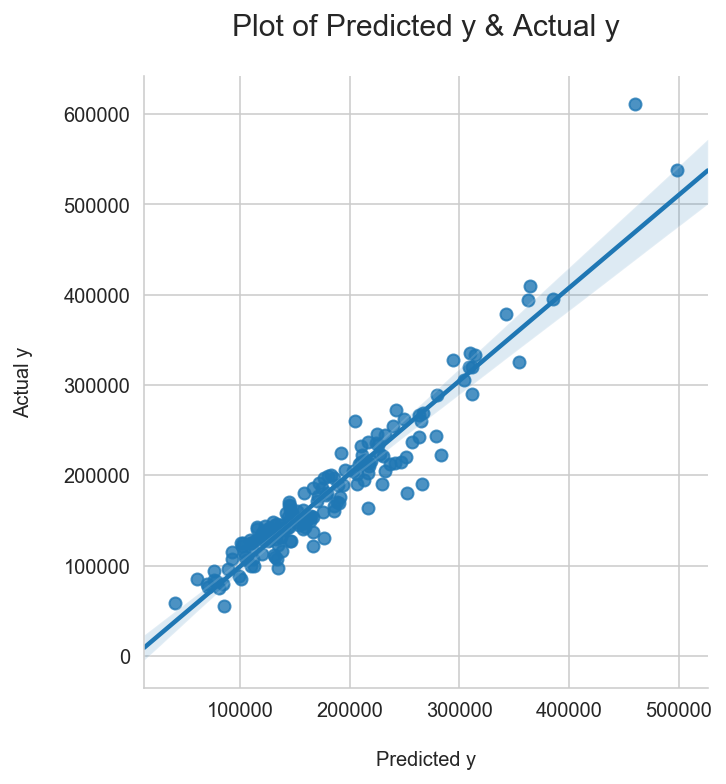

In [105]:
sns.lmplot(x='y_pred', y='y',data=df)
plt.title('Plot of Predicted y & Actual y',fontsize=15, pad=20)
plt.ylabel('Actual y', labelpad=15)
plt.xlabel('Predicted y', labelpad=15)
plt.show()

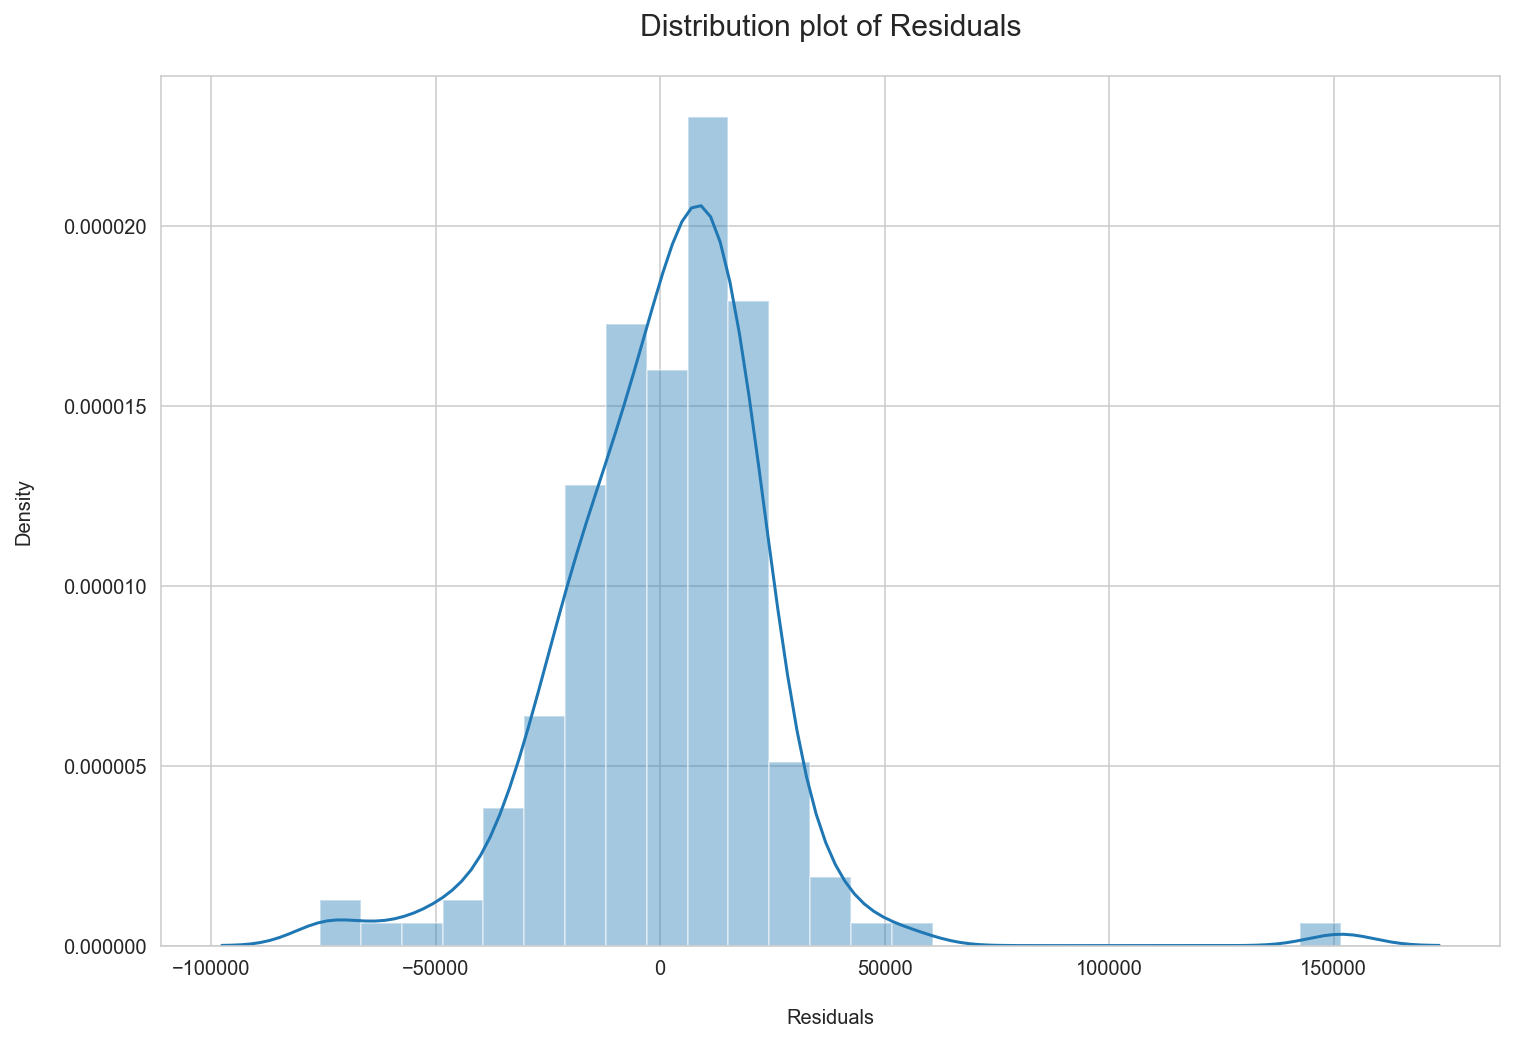

In [106]:
# Plotting the distribution of the residuals
plt.figure(figsize=(12,8))
sns.distplot(df['residuals'])
plt.title('Distribution plot of Residuals',fontsize=15, pad=20)
plt.ylabel('Density', labelpad=15)
plt.xlabel('Residuals', labelpad=15)
plt.show()

In [107]:
Xs = pd.concat([Xs_train, Xs_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

residuals = y - ridge_regf.predict(Xs)
resid['residual'] = list(residuals)

In [108]:
# Printing the absolute residuals of the first and second model

print("Abs Residuals (model w/ fixed features):", np.sum(np.abs(resid['fix_resid'])))
print("Abs Residuals (model w/ fixed & reno)  :", np.sum(np.abs(resid['residual'])))

Abs Residuals (model w/ fixed features): 11850309.601195239
Abs Residuals (model w/ fixed & reno)  : 22278603.29619856


In [109]:
ridge_coef = pd.DataFrame({'feature':Xs.columns, 'coef':ridge_regf.coef_})
ridge_coef.sort_values('coef', ascending=False)

feature          coef
8              GrLivArea  24542.426806
18             YearBuilt  11797.589494
55           OverallQual  11320.994277
30            BsmtFinSF1   7918.044243
17  Neighborhood_NoRidge   6893.372610
66           OverallCond   6855.158663
33  Neighborhood_NridgHt   6366.154586
29            GarageCars   6341.511428
26  Neighborhood_StoneBr   5863.332725
9                LotArea   5336.042780
41       BsmtExposure_Gd   5123.763621
54            MasVnrArea   4581.827773
2          MSSubClass_20   4476.557092
40  Neighborhood_Somerst   4472.694871
34          TotRmsAbvGrd   4171.016242
67      RoofMatl_WdShngl   3898.521222
15              FullBath   3863.959515
11  Neighborhood_Crawfor   3690.239282
48   Exterior1st_BrkFace   2932.889930
28         GarageType_NA   2161.364624
35              HalfBath   2140.134921
65            Fireplaces   1979.914582
46      BsmtFinType1_GLQ   1918.172811
4            ScreenPorch   1700.767361
13       LandContour_HLS   1683.889781
3        LandContour_Lvl   1398.558564
36           LotFrontage   1376.917078
60      BsmtFinType1_Unf   1365.446549
5        Condition2_PosA   1044.774007
14  Neighborhood_Veenker    947.882974
..                   ...           ...
47       Functional_Maj2   -712.481721
61             PoolQC_Gd   -864.412145
57      Utilities_NoSeWa   -956.472397
52          ExterQual_Fa   -977.376654
22  Neighborhood_Edwards  -1053.089349
64   Exterior2nd_Plywood  -1187.509650
20       Condition1_RRAe  -1407.004423
0       Condition1_Feedr  -1573.892835
10         LandSlope_Sev  -1654.603371
23         LotConfig_FR2  -1728.132924
21  Neighborhood_Mitchel  -1935.050409
1        BsmtExposure_NA  -2056.547947
25           BsmtQual_NA  -2056.547947
68        KitchenQual_Fa  -2112.746420
50          HeatingQC_Gd  -2120.228556
43          HeatingQC_TA  -2519.120157
42    MasVnrType_BrkFace  -2917.487348
39           BsmtQual_Fa  -2950.473023
38       BsmtExposure_No  -3102.413971
45             PoolQC_Fa  -3132.893537
6           BedroomAbvGr  -3464.731369
12          KitchenAbvGr  -4155.293302
37        MSSubClass_160  -4182.608895
56             PoolQC_NA  -5328.672328
59          ExterQual_Gd  -7456.977482
63        KitchenQual_Gd  -9212.838829
7            BsmtQual_TA  -9242.172390
44        KitchenQual_TA  -9782.117119
53          ExterQual_TA  -9958.632282
32           BsmtQual_Gd -11179.823099

[69 rows x 2 columns]

<div class="alert alert-info">

# End of Option 1

</div>

<div class="alert alert-warning">
    
Based on Option 1, we are able to see that the residuals from model 1 (488,732) has decreased to 182,641. However, the $R^2$ score for the second model only improved slightly to 0.8930 from 0.8656 in the first model.

The renovate-able features which most impact price are:
- The overall material and finish of the house
    - This is intuitive as the better the finishings and the material used for the house, the higher the price
    
- The overall condition of the house
    - Once again, another intuitive feature since the better the condition the house is in, the higher the price it would fetch
    
- Masonry veneer area
    - This is something the company can use to easily increase the price of the house. If the masonry veneer area of the house is low, this is something they can easily renovate to increase the selling price of the house.
    
- Roof material is wood shingles
    - This is another aspect that the company can use to increase the price of the house. If the house they they buy does not have a wood shingles roof, it is something they can consider as a way to increase the house selling price. Dependent on the increase in price based on the existing roof material and labour costs.
    
</div>

<div class="alert alert-danger">

# Option 2

Up to the next red markdown

</div>

In [110]:
df = pd.concat([df_fix.drop(columns=['YrSold', 'SalePrice']), df_reno], axis=1)
df.head()

Condition1_Feedr  BsmtExposure_NA  MSSubClass_20  LandContour_Lvl  \
0                 0                0              0                1   
1                 1                0              1                1   
2                 0                0              0                1   
3                 0                0              0                1   
4                 0                0              0                1   

   ScreenPorch  Condition2_PosA  BedroomAbvGr  BsmtQual_TA  GrLivArea  \
0            0                0             3            0       1710   
1            0                0             3            0       1262   
2            0                0             3            0       1786   
3            0                0             3            1       1717   
4            0                0             4            0       2198   

   LotArea  LandSlope_Sev  Neighborhood_Crawfor  KitchenAbvGr  \
0     8450              0                     0             1   
1     9600              0                     0             1   
2    11250              0                     0             1   
3     9550              0                     1             1   
4    14260              0                     0             1   

   LandContour_HLS  Neighborhood_Veenker  FullBath  Condition2_PosN  \
0                0                     0         2                0   
1                0                     1         2                0   
2                0                     0         2                0   
3                0                     0         1                0   
4                0                     0         2                0   

   Neighborhood_NoRidge  YearBuilt  BsmtFullBath  Condition1_RRAe  \
0                     0       2003             1                0   
1                     0       1976             0                0   
2                     0       2001             1                0   
3                     0       1915             1                0   
4                     1       2000             1                0   

   Neighborhood_Mitchel  Neighborhood_Edwards  LotConfig_FR2  Street_Pave  \
0                     0                     0              0            1   
1                     0                     0              1            1   
2                     0                     0              0            1   
3                     0                     0              0            1   
4                     0                     0              1            1   

   BsmtQual_NA  Neighborhood_StoneBr  LotShape_IR3  GarageType_NA  GarageCars  \
0            0                     0             0              0           2   
1            0                     0             0              0           2   
2            0                     0             0              0           2   
3            0                     0             0              0           3   
4            0                     0             0              0           3   

   BsmtFinSF1  3SsnPorch  BsmtQual_Gd  Neighborhood_NridgHt  TotRmsAbvGrd  \
0         706          0            1                     0             8   
1         978          0            1                     0             6   
2         486          0            1                     0             6   
3         216          0            0                     0             7   
4         655          0            1                     0             9   

   HalfBath  LotFrontage  MSSubClass_160  BsmtExposure_No  BsmtQual_Fa  \
0         1         65.0               0                1            0   
1         0         80.0               0                0            0   
2         1         68.0               0                0            0   
3         0         60.0               0                1            0   
4         1         84.0               0                0            0   

   Neighborhood_Somerst  BsmtExposure_Gd

In [111]:
# Train-Test split based on YrSold of 2010: pre-2010 as train & 2010 as test
y_train = df[df['YrSold'] < 2010]['SalePrice']
y_test = df[df['YrSold'] == 2010]['SalePrice']
X_train = df[df['YrSold'] < 2010].drop(columns=['SalePrice', 'YrSold'])
X_test = df[df['YrSold'] == 2010].drop(columns=['SalePrice', 'YrSold'])

# Converting data to standard scale, only fit to train dataset but scale/transform both train & test
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

Xs_train = pd.DataFrame(Xs_train, columns=X_train.columns)
Xs_test = pd.DataFrame(Xs_test, columns=X_test.columns)

In [112]:
# Applying Linear Regression model with all features
lreg = LinearRegression()

scores = cross_val_score(lreg, X_train, y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

Cross-validated scores: [-1.96342207e+03  8.02605675e-01  9.19980175e-01  8.88979108e-01
  9.00230597e-01  8.74985700e-01 -5.50530257e+04  8.69024172e-01
  8.55237628e-01 -2.82940650e+03]
Mean Cross-validated scores: -5983.974325203779
Std Cross-validated scores: 16384.800048735535


In [113]:
model = lreg.fit(X_train, y_train)
print("Train score:", model.score(X_train, y_train))
print("Test score:", model.score(X_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, model.predict(X_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, model.predict(X_test)))

Train score: 0.9266619827439808
Test score: 0.9139958681765078
Train Mean Squared Error: 457552526.6166996
Train Mean Squared Error: 546762590.4399596


In [114]:
# Applying Lasso Regularized Linear Regression model for forced feature selection
# Finding optimal alpha with LassoCV

dfoptimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
dfoptimal_lasso.fit(Xs_train, y_train)

print(dfoptimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

443.66328933965974


In [115]:
dflasso = Lasso(alpha=roptimal_lasso.alpha_)

scores = cross_val_score(dflasso, Xs_train, y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

Cross-validated scores: [0.90470169 0.89038679 0.92616856 0.91543879 0.88550628 0.86779356
 0.88651817 0.85764838 0.87692667 0.89737248]
Mean Cross-validated scores: 0.8908461375952411
Std Cross-validated scores: 0.019904176009351248


In [116]:
model = dflasso.fit(Xs_train, y_train)
print("Train score:", model.score(Xs_train, y_train))
print("Test score:", model.score(Xs_test, y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, model.predict(Xs_train)))
print("Train Mean Squared Error:", mean_squared_error(y_test, model.predict(Xs_test)))

Train score: 0.9114872038454135
Test score: 0.896674859473613
Train Mean Squared Error: 552227276.2987198
Train Mean Squared Error: 656879155.6169013


In [117]:
# Print the coefficients for the Lasso Regularized Linear Regression Model
df_coef = pd.DataFrame(dflasso.coef_, columns=['coef'])

df_coef['names'] = X_train.columns
df_coef['abs coef'] = np.abs(df_coef['coef'])

df_coef.sort_values('abs coef',ascending=False)

coef                 names      abs coef
8    33680.643558             GrLivArea  33680.643558
42   15014.533201           OverallQual  15014.533201
18   12802.481796             YearBuilt  12802.481796
30    8458.557652            BsmtFinSF1   8458.557652
32   -7399.893051           BsmtQual_Gd   7399.893051
33    6814.623540  Neighborhood_NridgHt   6814.623540
129  -6372.311070        KitchenQual_Gd   6372.311070
130  -6211.319194        KitchenQual_TA   6211.319194
43    5757.620118           OverallCond   5757.620118
17    5407.432918  Neighborhood_NoRidge   5407.432918
93   -5322.821748          ExterQual_TA   5322.821748
9     5122.848491               LotArea   5122.848491
41    5097.258720       BsmtExposure_Gd   5097.258720
26    5008.180737  Neighborhood_StoneBr   5008.180737
29    4782.747994            GarageCars   4782.747994
7    -4668.230098           BsmtQual_TA   4668.230098
2     3716.758677         MSSubClass_20   3716.758677
12   -3562.109632          KitchenAbvGr   3562.109632
37   -3350.633681        MSSubClass_160   3350.633681
44    3279.838269            MasVnrArea   3279.838269
6    -3216.739315          BedroomAbvGr   3216.739315
40    3072.031566  Neighborhood_Somerst   3072.031566
136   3016.915113        Functional_Typ   3016.915113
58    2951.686501      RoofMatl_WdShngl   2951.686501
11    2589.409352  Neighborhood_Crawfor   2589.409352
38   -2056.955113       BsmtExposure_No   2056.955113
159  -2031.773868             PoolQC_NA   2031.773868
61    2019.325744   Exterior1st_BrkFace   2019.325744
88   -1945.593635    MasVnrType_BrkFace   1945.593635
92   -1677.818328          ExterQual_Gd   1677.818328
..            ...                   ...           ...
62      -0.000000    Exterior1st_CBlock      0.000000
54       0.000000        RoofMatl_Metal      0.000000
60      -0.000000   Exterior1st_BrkComm      0.000000
59       0.000000   Exterior1st_AsphShn      0.000000
81      -0.000000     Exterior2nd_Other      0.000000
49       0.000000     RoofStyle_Gambrel      0.000000
27      -0.000000          LotShape_IR3      0.000000
86      -0.000000   Exterior2nd_Wd Sdng      0.000000
116     -0.000000          Heating_Grav      0.000000
115     -0.000000          Heating_GasW      0.000000
114      0.000000          Heating_GasA      0.000000
113      0.000000      BsmtFinType2_Unf      0.000000
55      -0.000000         RoofMatl_Roll      0.000000
108     -0.000000      BsmtFinType2_BLQ      0.000000
107      0.000000      BsmtFinType1_Unf      0.000000
28       0.000000         GarageType_NA      0.000000
104     -0.000000      BsmtFinType1_LwQ      0.000000
31       0.000000             3SsnPorch      0.000000
102      0.000000      BsmtFinType1_BLQ      0.000000
34       0.000000          TotRmsAbvGrd      0.000000
100      0.000000           BsmtCond_Po      0.000000
98       0.000000           BsmtCond_Gd      0.000000
97       0.000000          ExterCond_TA      0.000000
96       0.000000          ExterCond_Po      0.000000
94      -0.000000          ExterCond_Fa      0.000000
35       0.000000              HalfBath      0.000000
46      -0.000000               MiscVal      0.000000
91      -0.000000          ExterQual_Fa      0.000000
89       0.000000       MasVnrType_None      0.000000
84       0.000000    Exterior2nd_Stucco      0.000000

[168 rows x 3 columns]

In [118]:
# Printing out the number of selected features, the percentage of features removed and the selected features
print('Percent features removed:', np.sum((dflasso.coef_ == 0))/float(len(dflasso.coef_)))
df_features = list(df_coef[df_coef['coef']!=0]['names'])
print('Number of selected features:', len(df_features))
print()
print(df_features)

Percent features removed: 0.5476190476190477
Number of selected features: 76

['Condition1_Feedr', 'BsmtExposure_NA', 'MSSubClass_20', 'ScreenPorch', 'Condition2_PosA', 'BedroomAbvGr', 'BsmtQual_TA', 'GrLivArea', 'LotArea', 'LandSlope_Sev', 'Neighborhood_Crawfor', 'KitchenAbvGr', 'LandContour_HLS', 'Neighborhood_Veenker', 'FullBath', 'Neighborhood_NoRidge', 'YearBuilt', 'Condition1_RRAe', 'Neighborhood_Mitchel', 'LotConfig_FR2', 'Neighborhood_StoneBr', 'GarageCars', 'BsmtFinSF1', 'BsmtQual_Gd', 'Neighborhood_NridgHt', 'LotFrontage', 'MSSubClass_160', 'BsmtExposure_No', 'BsmtQual_Fa', 'Neighborhood_Somerst', 'BsmtExposure_Gd', 'OverallQual', 'OverallCond', 'MasVnrArea', 'Fireplaces', 'Utilities_NoSeWa', 'RoofStyle_Gable', 'RoofMatl_Membran', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_BrkFace', 'Exterior1st_CemntBd', 'Exterior1st_Plywood', 'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_Plywood', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Shng', 'MasV

In [119]:
# Checking summary of the Linear Model of Selected Features using statsmodel
model = sm.OLS(y_train.values, sm.add_constant(Xs_train[df_features]).values)
model = model.fit()
model.summary(xname=['Constant'] + df_features)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     191.5
Date:                Wed, 16 Jan 2019   Prob (F-statistic):               0.00
Time:                        16:37:26   Log-Likelihood:                -14487.
No. Observations:                1268   AIC:                         2.912e+04
Df Residuals:                    1194   BIC:                         2.950e+04
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Constant              1.815e+05    641.176    283.107      0.000     1.8e+05    1.83e+05
Condition1_Feedr     -1620.1046    680.282     -2.382      0.017   -2954.785    -285.424
BsmtExposure_NA      -1146.3975    251.901     -4.551      0.000   -1640.615    -652.180
MSSubClass_20         4459.7608    826.122      5.398      0.000    2838.949    6080.573
ScreenPorch           1692.5712    698.815      2.422      0.016     321.528    3063.614
Condition2_PosA        728.9972    695.026      1.049      0.294    -634.610    2092.605
BedroomAbvGr         -3655.1903    937.091     -3.901      0.000   -5493.719   -1816.661
BsmtQual_TA           -1.15e+04   1969.512     -5.841      0.000   -1.54e+04   -7639.880
GrLivArea             3.341e+04   1434.586     23.291      0.000    3.06e+04    3.62e+04
LotArea               5275.3289    861.491      6.123      0.000    3585.124    6965.533
LandSlope_Sev        -2078.4384    749.627     -2.773      0.006   -3549.172    -607.705
Neighborhood_Crawfor  3685.6765    725.751      5.078      0.000    2261.788    5109.565
KitchenAbvGr         -4206.8443    757.161     -5.556      0.000   -5692.358   -2721.330
LandContour_HLS        851.7363    698.385      1.220      0.223    -518.462    2221.935
Neighborhood_Veenker  1063.3772    702.808      1.513      0.131    -315.498    2442.253
FullBath              2649.4525   1052.894      2.516      0.012     583.724    4715.181
Neighborhood_NoRidge  6686.0475    784.400      8.524      0.000    5147.092    8225.003
YearBuilt             1.295e+04   1476.143      8.772      0.000    1.01e+04    1.58e+04
Condition1_RRAe      -1053.1872    658.910     -1.598      0.110   -2345.938     239.564
Neighborhood_Mitchel -2064.0551    694.747     -2.971      0.003   -3427.115    -700.995
LotConfig_FR2        -1675.1882    671.092     -2.496      0.013   -2991.840    -358.537
Neighborhood_StoneBr  5663.0014    703.575      8.049      0.000    4282.621    7043.382
GarageCars            4784.3460    938.370      5.099      0.000    2943.309    6625.383
BsmtFinSF1            7479.0899    931.848      8.026      0.000    5650.848    9307.332
BsmtQual_Gd          -1.296e+04   1617.258     -8.011      0.000   -1.61e+04   -9783.183
Neighborhood_NridgHt  5586.1251    878.220      6.361      0.000    3863.100    7309.150
LotFrontage           1100.3071    849.606      1.295      0.196    -566.580    2767.195
MSSubClass_160       -3947.9494    790.524     -4.994      0.000   -5498.920   -2396.979
BsmtExposure_No      -2580.7430    805.833     -3.203      0.001   -4161.749    -999.737
BsmtQual_Fa          -3539.2769    930.338     -3.804      0.000   -5364.555   -1713.998
Neighborhood_Somerst  4345.9284    788.387      5.512      0.000    2799.150    5892.707
BsmtExposure_Gd       5222.5157    803.763      6.498    

In [120]:
# Creating a DataFrame of the features and their respective p-values
df_pvalue = pd.DataFrame(['Constant'] + df_features, columns=['names'])
df_pvalue['p-value'] = model.pvalues

# Identifying features which have p-value > 0.05 for removal
pvalue_remove = list(df_pvalue[df_pvalue['p-value'] > 0.05]['names'])

pvalue_remove

['Condition2_PosA',
 'LandContour_HLS',
 'Neighborhood_Veenker',
 'Condition1_RRAe',
 'LotFrontage',
 'Fireplaces',
 'Utilities_NoSeWa',
 'RoofStyle_Gable',
 'RoofMatl_Tar&Grv',
 'RoofMatl_WdShake',
 'Exterior1st_CemntBd',
 'Exterior1st_Plywood',
 'Exterior2nd_HdBoard',
 'Exterior2nd_ImStucc',
 'Exterior2nd_Plywood',
 'Exterior2nd_VinylSd',
 'Exterior2nd_Wd Shng',
 'MasVnrType_Stone',
 'ExterCond_Gd',
 'BsmtCond_TA',
 'BsmtFinType1_GLQ',
 'BsmtFinType1_Rec',
 'BsmtFinType2_GLQ',
 'BsmtFinType2_LwQ',
 'FireplaceQu_Gd',
 'GarageFinish_RFn',
 'GarageQual_Gd',
 'PoolQC_Fa',
 'MiscFeature_TenC']

In [121]:
# Removing the features with p-value > 0.05 from the selected features from Lasso
df_features = list(set(df_features) - set(pvalue_remove))

df_features

['Condition1_Feedr',
 'BsmtExposure_NA',
 'MasVnrType_BrkFace',
 'HeatingQC_TA',
 'KitchenQual_TA',
 'MSSubClass_20',
 'ScreenPorch',
 'BedroomAbvGr',
 'BsmtQual_TA',
 'GrLivArea',
 'LotArea',
 'LandSlope_Sev',
 'Neighborhood_Crawfor',
 'KitchenAbvGr',
 'Heating_OthW',
 'FullBath',
 'Exterior1st_BrkFace',
 'Neighborhood_NoRidge',
 'HeatingQC_Gd',
 'YearBuilt',
 'ExterQual_TA',
 'MasVnrArea',
 'OverallQual',
 'RoofMatl_Membran',
 'Functional_Typ',
 'PoolQC_NA',
 'Neighborhood_Mitchel',
 'LotConfig_FR2',
 'ExterQual_Gd',
 'BsmtFinType1_NA',
 'Neighborhood_StoneBr',
 'GarageCars',
 'BsmtFinSF1',
 'BsmtQual_Gd',
 'KitchenQual_Gd',
 'Neighborhood_NridgHt',
 'Functional_Sev',
 'OverallCond',
 'Neighborhood_Somerst',
 'BsmtCond_NA',
 'MSSubClass_160',
 'BsmtExposure_No',
 'BsmtQual_Fa',
 'BsmtFinType2_NA',
 'RoofMatl_WdShngl',
 'BsmtExposure_Gd',
 'KitchenQual_Fa']

In [122]:
# Applying Linear Regression model with selected features
lreg = LinearRegression()

scores = cross_val_score(lreg, X_train[df_features], y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

Cross-validated scores: [0.90914232 0.91119076 0.93039048 0.91367344 0.91159534 0.88252317
 0.89829833 0.87979101 0.89998769 0.88842593]
Mean Cross-validated scores: 0.902501848459815
Std Cross-validated scores: 0.014973032309560439


In [123]:
model = lreg.fit(X_train[df_features], y_train)
print("Train score:", model.score(X_train[df_features], y_train))
print("Test score:", model.score(X_test[df_features], y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, model.predict(X_train[df_features])))
print("Train Mean Squared Error:", mean_squared_error(y_test, model.predict(X_test[df_features])))

Train score: 0.9182212084665197
Test score: 0.9099232363247166
Train Mean Squared Error: 510214130.26724905
Train Mean Squared Error: 572653936.518119


In [124]:
# Applying Lasso Regularized Linear Regression model on selected features
# Finding optimal alpha with LassoCV

dfoptimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
dfoptimal_lasso.fit(Xs_train[df_features], y_train)

print(dfoptimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

63.002546560972206


................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished


In [125]:
dflasso = Lasso(alpha=roptimal_lasso.alpha_)

scores = cross_val_score(dflasso, Xs_train[df_features], y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

Cross-validated scores: [0.90724971 0.90377617 0.92574174 0.91693966 0.88979449 0.86867808
 0.89051434 0.85814963 0.88331337 0.89960721]
Mean Cross-validated scores: 0.8943764404064201
Std Cross-validated scores: 0.01976210288503692


In [126]:
model = dflasso.fit(Xs_train[df_features], y_train)
print("Train score:", model.score(Xs_train[df_features], y_train))
print("Test score:", model.score(Xs_test[df_features], y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, model.predict(Xs_train[df_features])))
print("Train Mean Squared Error:", mean_squared_error(y_test, model.predict(Xs_test[df_features])))

Train score: 0.910041119736726
Test score: 0.8983593816726451
Train Mean Squared Error: 561249328.7400941
Train Mean Squared Error: 646169975.7011425


In [127]:
# Applying Ridge Regularized Linear Regression with the selected features

# Finding an optimal value for the ridge regression alpha using RidgeCV
ridge_alphas = np.logspace(-2, 7, 50)

clf = RidgeCV(alphas=ridge_alphas).fit(Xs_train[df_features], y_train)

dfridge_reg = Ridge()

dfridge_reg.set_params(alpha=clf.alpha_)

scores = cross_val_score(dfridge_reg, Xs_train[df_features], y_train, cv=10)

print("Cross-validated scores:", scores)
print("Mean Cross-validated scores:", np.mean(scores))
print("Std Cross-validated scores:", np.std(scores))

Cross-validated scores: [0.91016783 0.91150469 0.93004414 0.91382958 0.91138648 0.88243902
 0.89955413 0.87904542 0.89831396 0.89068923]
Mean Cross-validated scores: 0.902697448017778
Std Cross-validated scores: 0.014912258312768848


In [128]:
model = dfridge_reg.fit(Xs_train[df_features], y_train)
print("Train score:", model.score(Xs_train[df_features], y_train))
print("Test score:", model.score(Xs_test[df_features], y_test))
print("Train Mean Squared Error:", mean_squared_error(y_train, model.predict(Xs_train[df_features])))
print("Train Mean Squared Error:", mean_squared_error(y_test, model.predict(Xs_test[df_features])))

Train score: 0.9181543591498874
Test score: 0.9095709407359075
Train Mean Squared Error: 510631200.0882249
Train Mean Squared Error: 574893620.178122


In [129]:
# Creating DataFrame of actual y & predicted y to evaluate the model
df = pd.DataFrame({'y': y_test, 'y_pred': dfridge_reg.predict(Xs_test[df_features])})
df['residuals'] = df['y'] - df['y_pred']
df.head()

y         y_pred     residuals
16  149000  154997.422903  -5997.422903
24  154000  144035.616646   9964.383354
26  134800  121650.802108  13149.197892
27  306000  300555.142206   5444.857794
33  165500  190667.436499 -25167.436499

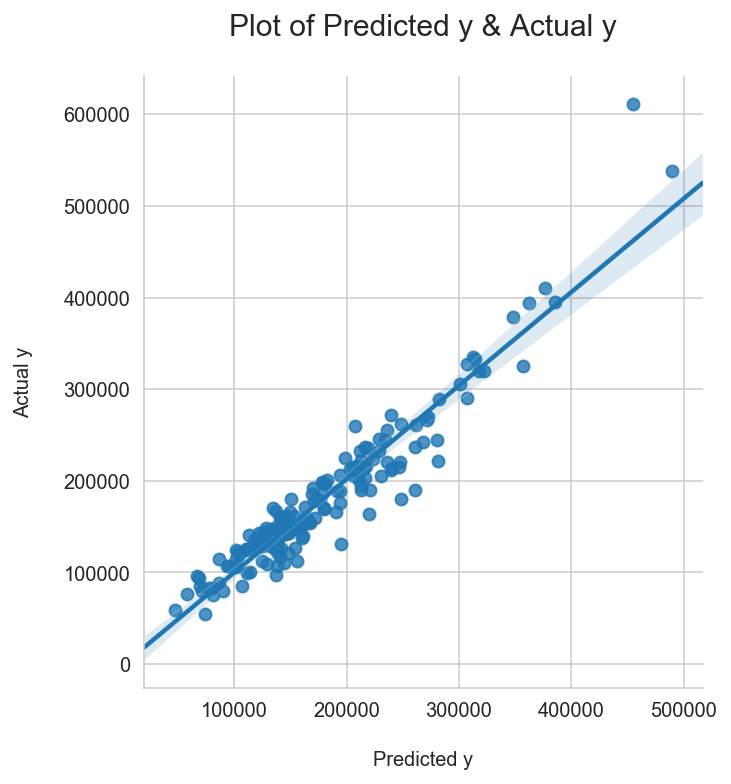

In [130]:
sns.lmplot(x='y_pred', y='y',data=df)
plt.title('Plot of Predicted y & Actual y',fontsize=15, pad=20)
plt.ylabel('Actual y', labelpad=15)
plt.xlabel('Predicted y', labelpad=15)
plt.show()

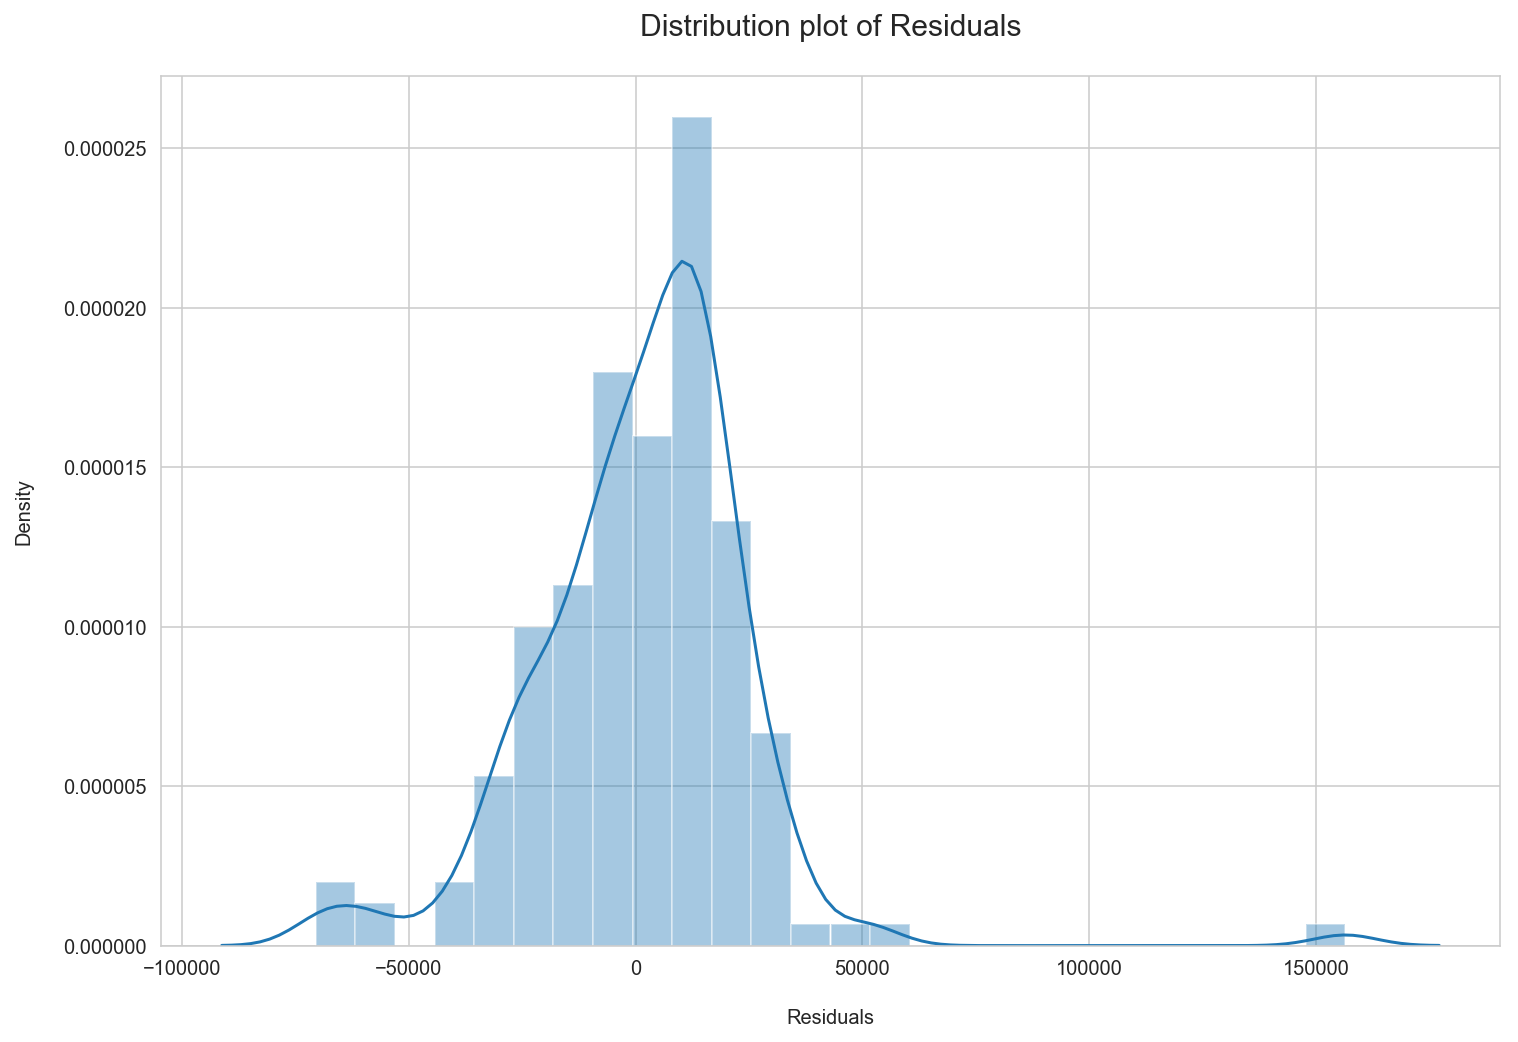

In [131]:
# Plotting the distribution of the residuals
plt.figure(figsize=(12,8))
sns.distplot(df['residuals'])
plt.title('Distribution plot of Residuals',fontsize=15, pad=20)
plt.ylabel('Density', labelpad=15)
plt.xlabel('Residuals', labelpad=15)
plt.show()

In [132]:
# Printing the absolute residuals of the model
print("Abs Residuals of the model:", np.sum(np.abs(df['residuals'])))

Abs Residuals of the model: 2934783.022683991


In [133]:
# Creating DatFrame of the coefficients of the features from the Ridge Regression Model

df_ = pd.DataFrame(df_features, columns=['Name'])
df_['Coefficient'] = [round(num,4) for num in dfridge_reg.coef_]
df_['Abs Coefficient'] = np.abs(df_['Coefficient'])

df_.sort_values('Abs Coefficient',ascending=False)

Name  Coefficient  Abs Coefficient
9              GrLivArea   33505.8570       33505.8570
33           BsmtQual_Gd  -13330.6465       13330.6465
19             YearBuilt   12899.4089       12899.4089
20          ExterQual_TA  -12163.2475       12163.2475
8            BsmtQual_TA  -11856.2037       11856.2037
4         KitchenQual_TA  -11508.8837       11508.8837
34        KitchenQual_Gd  -11336.8399       11336.8399
22           OverallQual   10814.1814       10814.1814
28          ExterQual_Gd   -9342.0433        9342.0433
32            BsmtFinSF1    7783.8363        7783.8363
17  Neighborhood_NoRidge    6837.2598        6837.2598
37           OverallCond    6664.8987        6664.8987
35  Neighborhood_NridgHt    5601.4849        5601.4849
30  Neighborhood_StoneBr    5536.1718        5536.1718
45       BsmtExposure_Gd    5312.0374        5312.0374
10               LotArea    5232.9700        5232.9700
31            GarageCars    5083.7575        5083.7575
40        MSSubClass_160   -4299.8981        4299.8981
5          MSSubClass_20    4186.5462        4186.5462
38  Neighborhood_Somerst    4155.7150        4155.7150
13          KitchenAbvGr   -4118.4199        4118.4199
12  Neighborhood_Crawfor    3908.7620        3908.7620
7           BedroomAbvGr   -3807.3210        3807.3210
24        Functional_Typ    3777.9192        3777.9192
21            MasVnrArea    3761.2107        3761.2107
42           BsmtQual_Fa   -3704.9592        3704.9592
44      RoofMatl_WdShngl    3414.0990        3414.0990
2     MasVnrType_BrkFace   -3323.7791        3323.7791
16   Exterior1st_BrkFace    3045.5554        3045.5554
46        KitchenQual_Fa   -2907.0446        2907.0446
41       BsmtExposure_No   -2897.1370        2897.1370
25             PoolQC_NA   -2726.1040        2726.1040
15              FullBath    2530.8383        2530.8383
11         LandSlope_Sev   -2446.6977        2446.6977
3           HeatingQC_TA   -2317.2298        2317.2298
36        Functional_Sev   -2128.5311        2128.5311
26  Neighborhood_Mitchel   -1942.1848        1942.1848
14          Heating_OthW   -1773.1805        1773.1805
23      RoofMatl_Membran    1772.2237        1772.2237
18          HeatingQC_Gd   -1681.5164        1681.5164
0       Condition1_Feedr   -1507.6188        1507.6188
27         LotConfig_FR2   -1477.0671        1477.0671
39           BsmtCond_NA   -1292.0293        1292.0293
29       BsmtFinType1_NA   -1292.0293        1292.0293
1        BsmtExposure_NA   -1292.0293        1292.0293
43       BsmtFinType2_NA   -1292.0293        1292.0293
6            ScreenPorch    1133.8713        1133.8713

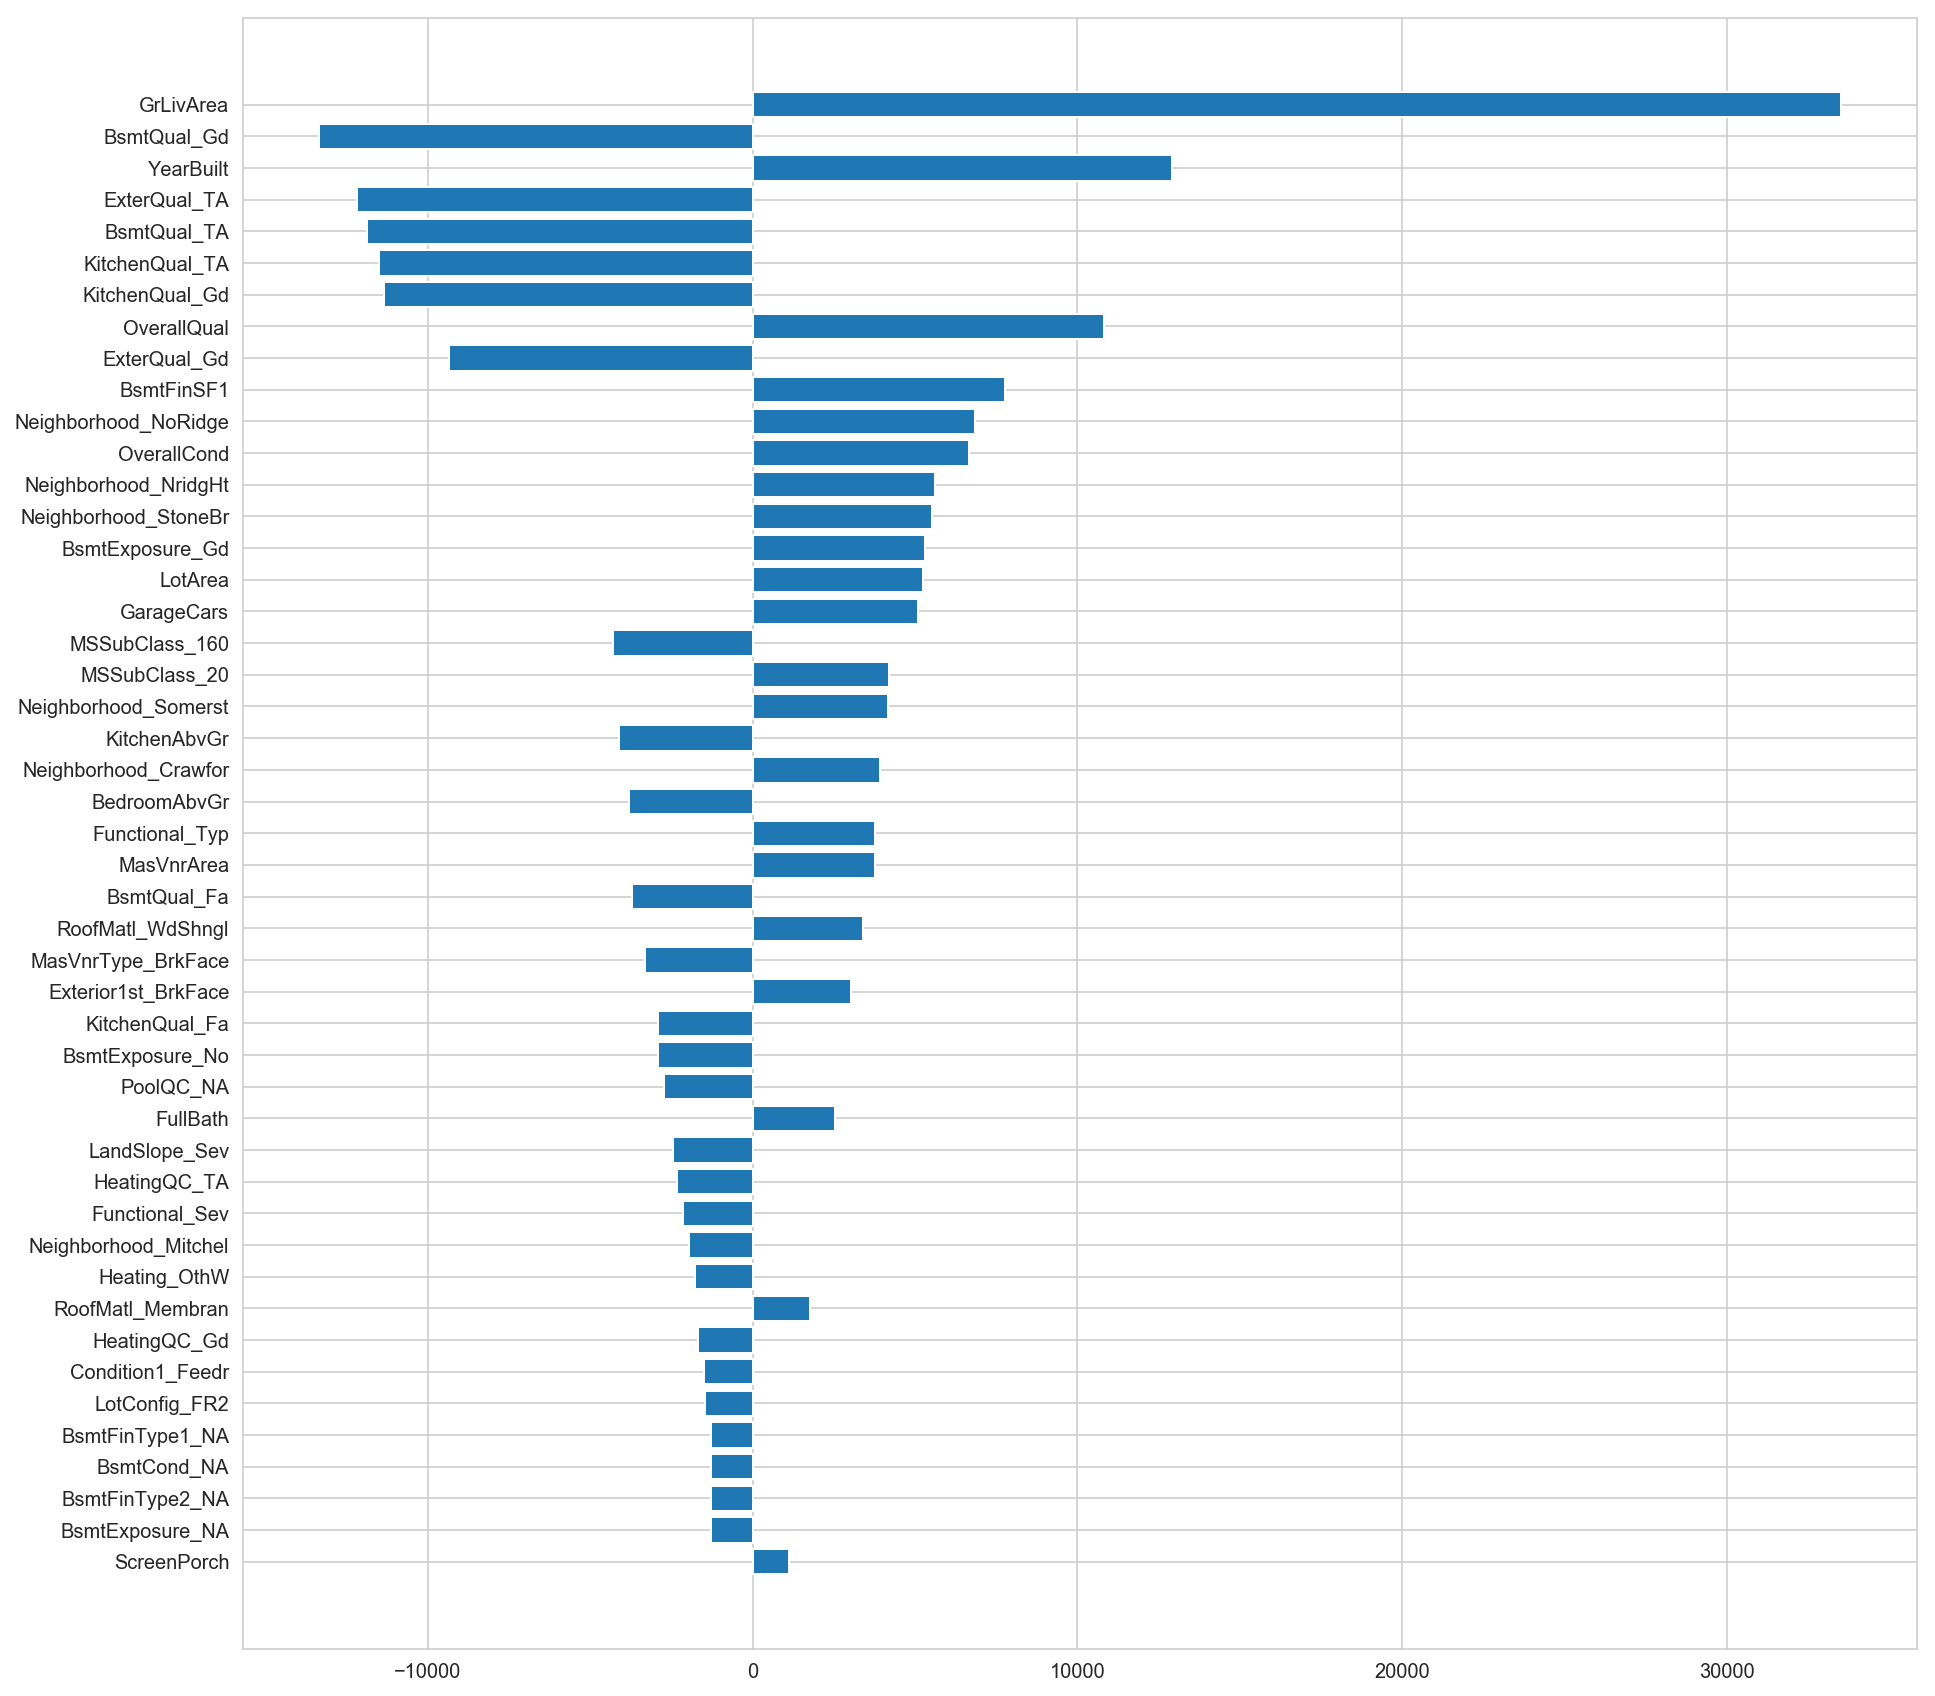

In [134]:
# Plotting the coefficients
df_ = df_.sort_values('Abs Coefficient',ascending=True)

plt.figure(figsize=(15,15))
plt.barh(y=df_['Name'], width=df_['Coefficient'])
plt.show()

<div class="alert alert-danger">

# End of Option 2

</div>

<div class="alert alert-warning">

Ridge Linear Regression was chosen as the final model, since it's easier to interpret the features and it's coefficients. The cross-validated $R^2$ score for this model is 0.9027 with a standard deviation of 0.0149, which is better than the model for Question 1 (CV Mean $R^2$: 0.8656, Std Dev: 0.0194). 
    
Applying this model, the company would be able to buy houses that are undervalued based on the fixed features identified in this model:
- The amount of living area above ground (GrLivArea)
- The year the house was built (YearBuilt)
- Size of basement (BsmtFinSF1)
- Neighbourhood
- Size of the lot (LotArea)

In terms of renovate-able features, the company would be able to renovate the:
- Kitchen
    - To improve kitchen quality, depending on the condition of the existing house
- House Exterior
    - Depending on the quality of the material used on the exterior of the house could be relatively easily renovated (ie, painting, etc.)

</div>

<div class="alert alert-warning">
    
### Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

The model can be trusted to an extent. However, further tuning is required to ensure that the model is more robust. In addition, this model does not include other factors that could be important in when it comes to evaluating and buying properties to fix up and sell.

Some of the factors are:
- Current trend of house prices in the market
    - Housing market follows cycles of highs and lows, it's important to understand the timing of which the company is purchasing the house and also for it to be aware of how long they might have to hold the property before selling it
    
- Annual seasonality of housing sale
    - This model does not include how house prices are influenced by the month that the house is sold. There could potentially be seasonality in housing sales. An example would be extremely low housing sales in Singapore during the Hungry Ghost Festival months
    
- Non-housing features

Sometimes there are factors which could impact the price of the house that are not visible purely based on the fixed or renovate-able features of the house. 

    - An example would be rumours of the house being haunted or someone having been murdered in the house, etc. Thus, the house might be bought at an undervalued price based on the model, but the sale price would also be impacted by such things.
    
    - Ammenities that are available in the neighbourhood. Examples would be community centres, public pools, proximity to prestigious schools, malls, etc.
    
    - Accessibility of the house. Examples would be promiximity to highways, ease of commute via public transportation, etc.

Thus, I would not recommend the company to rely purely on the model to evaluate which properties to buy, fix-up and sell. There are many other factors that need to be taken into account that has not been accounted for in the model.

</div>

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

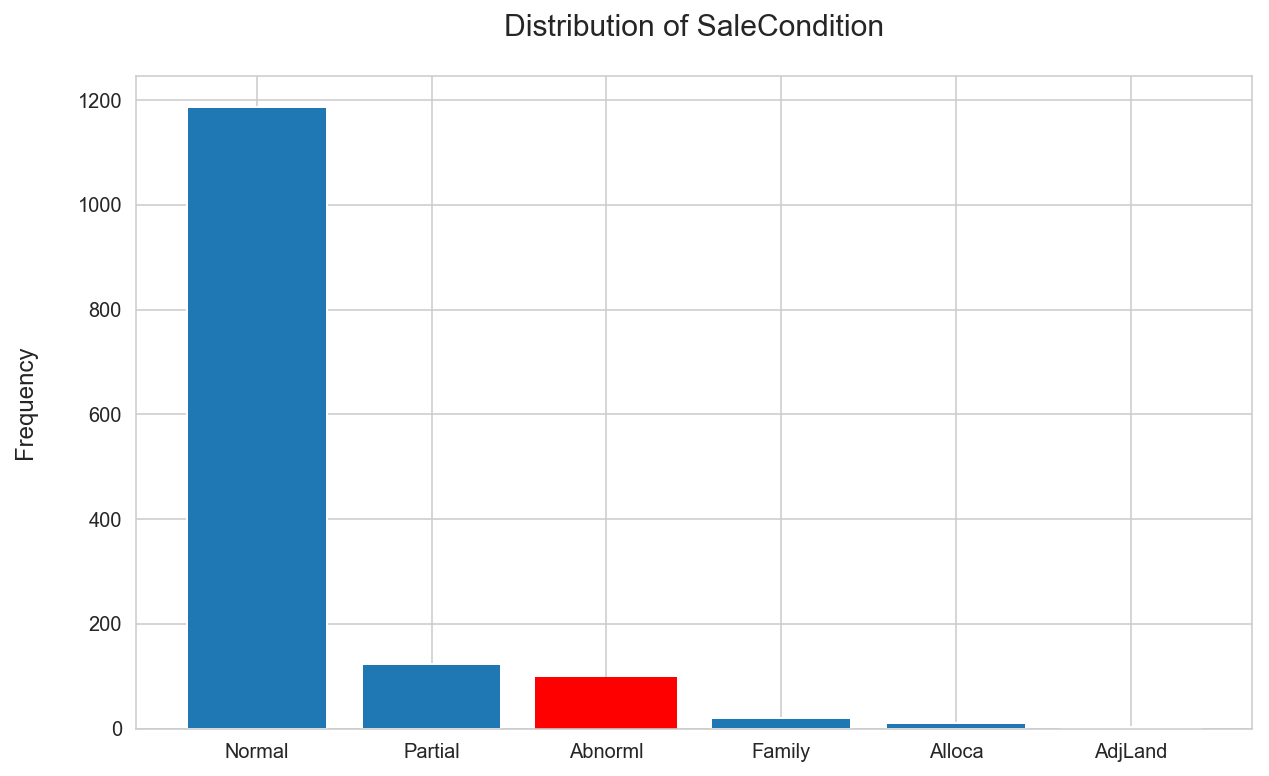

In [135]:
# Plotting distribution of the various SaleCondition
plt.figure(figsize=(10,6))
graph = plt.bar(x=list(house['SaleCondition'].value_counts().index), height=list(house['SaleCondition'].value_counts()))
plt.title('Distribution of SaleCondition', fontsize=15, pad=20)
plt.ylabel('Frequency', fontsize=12, labelpad=20)
graph[2].set_color('r')
plt.show()

In [136]:
# Creating the Target and Predictor Matrix
df_classification = pd.concat([df_fix.drop(columns=['YrSold', 'SalePrice']), df_reno, house['SaleCondition']], axis=1)

# Encode target variable into 0 and 1 (1 = Abnormal SaleCondition)
df_classification['Abnormal_sale'] = df_classification['SaleCondition'].apply(lambda x: 1 if x=='Abnorml' else 0)

# Train-Test split based on YrSold of 2010: pre-2010 as train & 2010 as test
y_train = df_classification[df_classification['YrSold'] < 2010]['Abnormal_sale']
y_test = df_classification[df_classification['YrSold'] == 2010]['Abnormal_sale']
X_train = df_classification[df_classification['YrSold'] < 2010].drop(columns=['SalePrice', 'YrSold', 'Abnormal_sale', 'SaleCondition'])
X_test = df_classification[df_classification['YrSold'] == 2010].drop(columns=['SalePrice', 'YrSold', 'Abnormal_sale', 'SaleCondition'])

# Converting data to standard scale, only fit to train dataset but scale/transform both train & test
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

Xs_train = pd.DataFrame(Xs_train, columns=X_train.columns)
Xs_test = pd.DataFrame(Xs_test, columns=X_test.columns)

In [137]:
# Calculating the baseline for the model (The baseline accuracy is the proportion of the majority class)
# Applying baseline = 1. - np.mean(y) as np.mean(y) is < 0.5

baseline = 1 - np.mean(y_train)
print('Baseline:', baseline)

Baseline: 0.9313880126182965


In [138]:
# Applying Logistic Regression using GridSearchCV to find optimum parameters

logr_parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.linspace(1, 25, 25)
}

logr_gridsearcher = GridSearchCV(LogisticRegression(), logr_parameters, verbose=1)
logr_result = logr_gridsearcher.fit(Xs_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   48.1s finished


In [139]:
print('Best mean cross-validated score achieved:', logr_result.best_score_)
print('Best parameters:', logr_result.best_params_)

Best mean cross-validated score achieved: 0.917192429022082
Best parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}


In [140]:
logrbest = logr_result.best_estimator_
print('Logistic Regression Classification score:', logrbest.score(Xs_test, y_test))
print('Baseline:', baseline)

Logistic Regression Classification score: 0.9418604651162791
Baseline: 0.9313880126182965


In [141]:
confusion_matrix(y_test, logrbest.predict(Xs_test))

array([[162,   1],
       [  9,   0]])

In [142]:
print(classification_report(y_test, logrbest.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       163
           1       0.00      0.00      0.00         9

   micro avg       0.94      0.94      0.94       172
   macro avg       0.47      0.50      0.49       172
weighted avg       0.90      0.94      0.92       172



In [143]:
fpr, tpr, _ = roc_curve(y_test, logrbest.predict(Xs_test))
roc_auc = auc(fpr, tpr)

print('Logistic Regression Classification AUC:', roc_auc)

Logistic Regression Classification AUC: 0.49693251533742333


In [144]:
# Applying KNNClassifier using GridSearchCV to find optimum parameters

knn_parameters = {
    'n_neighbors':list(range(1, 49 + 1, 2)),
    'weights':['uniform','distance']
}

knn_gridsearcher = GridSearchCV(KNeighborsClassifier(), knn_parameters, verbose=1)
knn_result = knn_gridsearcher.fit(Xs_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   33.6s finished


In [145]:
print('Best mean cross-validated score achieved:', knn_result.best_score_)
print('Best parameters:', knn_result.best_params_)

Best mean cross-validated score achieved: 0.9313880126182965
Best parameters: {'n_neighbors': 11, 'weights': 'uniform'}


In [146]:
knnbest = knn_result.best_estimator_
print('KNN Classification score:', knnbest.score(Xs_test, y_test))
print('Baseline:', baseline)

KNN Classification score: 0.9476744186046512
Baseline: 0.9313880126182965


In [147]:
confusion_matrix(y_test, knnbest.predict(Xs_test))

array([[163,   0],
       [  9,   0]])

In [148]:
print(classification_report(y_test, knnbest.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       163
           1       0.00      0.00      0.00         9

   micro avg       0.95      0.95      0.95       172
   macro avg       0.47      0.50      0.49       172
weighted avg       0.90      0.95      0.92       172



In [149]:
fpr, tpr, _ = roc_curve(y_test, knnbest.predict(Xs_test))
roc_auc = auc(fpr, tpr)

print('KNN Classification AUC:', roc_auc)

KNN Classification AUC: 0.5


In [150]:
# Applying Random Forest Classifier using GridSearchCV to find optimum parameters

ranf_parameters = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

ranf_gridsearcher = GridSearchCV(RandomForestClassifier(), ranf_parameters, verbose=1)
ranf_result = knn_gridsearcher.fit(Xs_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   33.4s finished


In [151]:
print('Best mean cross-validated score achieved:', ranf_result.best_score_)
print('Best parameters:', ranf_result.best_params_)

Best mean cross-validated score achieved: 0.9313880126182965
Best parameters: {'n_neighbors': 11, 'weights': 'uniform'}


In [152]:
ranfbest = ranf_result.best_estimator_
print('Random Forest Classification score:', ranfbest.score(Xs_test, y_test))
print('Baseline:', baseline)

Random Forest Classification score: 0.9476744186046512
Baseline: 0.9313880126182965


In [153]:
confusion_matrix(y_test, ranfbest.predict(Xs_test))

array([[163,   0],
       [  9,   0]])

In [154]:
print(classification_report(y_test, ranfbest.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       163
           1       0.00      0.00      0.00         9

   micro avg       0.95      0.95      0.95       172
   macro avg       0.47      0.50      0.49       172
weighted avg       0.90      0.95      0.92       172



In [155]:
fpr, tpr, _ = roc_curve(y_test, ranfbest.predict(Xs_test))
roc_auc = auc(fpr, tpr)

print('Random Forest Classification AUC:', roc_auc)

Random Forest Classification AUC: 0.5


<div class="alert alert-warning">

### Due to the class imbalance of the data:

Across all the classification models, they do not perform much better than the baseline or a coin flip. Thus, we will attempt to apply class weights in our logistic regression and to try resampling techniques to obtain better results.

</div>

In [156]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss, CondensedNearestNeighbour
from imblearn.under_sampling import EditedNearestNeighbours, RepeatedEditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [157]:
# Applying Logistic Regression with class weights using GridSearchCV to find optimum parameters

logrw_parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.linspace(1, 25, 25),
    'class_weight': ['balanced']
}

logrw_gridsearcher = GridSearchCV(LogisticRegression(), logrw_parameters, verbose=1)
logrw_result = logrw_gridsearcher.fit(Xs_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.2min finished


In [158]:
print('Best mean cross-validated score achieved:', logrw_result.best_score_)
print('Best parameters:', logrw_result.best_params_)

Best mean cross-validated score achieved: 0.7563091482649842
Best parameters: {'C': 12.0, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}


In [159]:
logrwbest = logrw_result.best_estimator_
print('Logistic Regression Classification score:', logrwbest.score(Xs_test, y_test))
print('Baseline:', baseline)

Logistic Regression Classification score: 0.6569767441860465
Baseline: 0.9313880126182965


In [160]:
confusion_matrix(y_test, logrwbest.predict(Xs_test))

array([[112,  51],
       [  8,   1]])

In [161]:
print(classification_report(y_test, logrwbest.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.93      0.69      0.79       163
           1       0.02      0.11      0.03         9

   micro avg       0.66      0.66      0.66       172
   macro avg       0.48      0.40      0.41       172
weighted avg       0.89      0.66      0.75       172



In [162]:
fpr, tpr, _ = roc_curve(y_test, logrwbest.predict(Xs_test))
roc_auc = auc(fpr, tpr)

print('Logistic Regression Classification with class weights AUC:', roc_auc)

Logistic Regression Classification with class weights AUC: 0.39911383776414455


In [163]:
# Applying random undersampling of the majority class (abnormal_sale = 0)

us = RandomUnderSampler(ratio=0.5, random_state=1)
Xs_train_res, y_train_res = us.fit_sample(Xs_train, y_train)

In [164]:
# Applying Logistic Regression using GridSearchCV to find optimum parameters

logr_parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.linspace(1, 25, 25)
}

logr_gridsearcher = GridSearchCV(LogisticRegression(), logr_parameters, verbose=1)
logr_result = logr_gridsearcher.fit(Xs_train_res, y_train_res)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    4.1s finished


In [165]:
print('Best mean cross-validated score achieved:', logr_result.best_score_)
print('Best parameters:', logr_result.best_params_)
logrbest = logr_result.best_estimator_
print('Logistic Regression Classification score:', logrbest.score(Xs_test, y_test))
print('Baseline:', baseline)

Best mean cross-validated score achieved: 0.5747126436781609
Best parameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression Classification score: 0.5872093023255814
Baseline: 0.9313880126182965


In [166]:
confusion_matrix(y_test, logrbest.predict(Xs_test))

array([[98, 65],
       [ 6,  3]])

In [167]:
print(classification_report(y_test, logrbest.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.94      0.60      0.73       163
           1       0.04      0.33      0.08         9

   micro avg       0.59      0.59      0.59       172
   macro avg       0.49      0.47      0.41       172
weighted avg       0.90      0.59      0.70       172



In [168]:
fpr, tpr, _ = roc_curve(y_test, logrbest.predict(Xs_test))
roc_auc = auc(fpr, tpr)

print('Logistic Regression Classification AUC:', roc_auc)

Logistic Regression Classification AUC: 0.467280163599182


In [169]:
# Applying KNNClassifier using GridSearchCV to find optimum parameters

knn_parameters = {
    'n_neighbors':list(range(1, 49 + 1, 2)),
    'weights':['uniform','distance']
}

knn_gridsearcher = GridSearchCV(KNeighborsClassifier(), knn_parameters, verbose=1)
knn_result = knn_gridsearcher.fit(Xs_train_res, y_train_res)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.8s finished


In [170]:
print('Best mean cross-validated score achieved:', knn_result.best_score_)
print('Best parameters:', knn_result.best_params_)

Best mean cross-validated score achieved: 0.6819923371647509
Best parameters: {'n_neighbors': 37, 'weights': 'uniform'}


In [171]:
knnbest = knn_result.best_estimator_
print('KNN Classification score:', knnbest.score(Xs_test, y_test))
print('Baseline:', baseline)

KNN Classification score: 0.8895348837209303
Baseline: 0.9313880126182965


In [172]:
confusion_matrix(y_test, knnbest.predict(Xs_test))

array([[153,  10],
       [  9,   0]])

In [173]:
print(classification_report(y_test, knnbest.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       163
           1       0.00      0.00      0.00         9

   micro avg       0.89      0.89      0.89       172
   macro avg       0.47      0.47      0.47       172
weighted avg       0.90      0.89      0.89       172



In [174]:
fpr, tpr, _ = roc_curve(y_test, knnbest.predict(Xs_test))
roc_auc = auc(fpr, tpr)

print('KNN Classification AUC:', roc_auc)

KNN Classification AUC: 0.46932515337423314


In [175]:
# Applying random undersampling of the majority class (abnormal_sale = 0) & Random Forest Classifier

us = RandomUnderSampler(ratio=0.5, random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)

In [176]:
# Using GridSearchCV to find optimum parameters for Random Forest Classifier

ranf_parameters = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [177]:
ranf_gridsearcher = GridSearchCV(RandomForestClassifier(), ranf_parameters, verbose=1)
ranf_result = knn_gridsearcher.fit(X_train_res, y_train_res)
print('Best mean cross-validated score achieved:', ranf_result.best_score_)
print('Best parameters:', ranf_result.best_params_)
ranfbest = ranf_result.best_estimator_
print('Random Forest Classification score:', ranfbest.score(X_test, y_test))
print('Baseline:', baseline)
confusion_matrix(y_test, ranfbest.predict(X_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best mean cross-validated score achieved: 0.6743295019157088
Best parameters: {'n_neighbors': 15, 'weights': 'distance'}
Random Forest Classification score: 0.7848837209302325
Baseline: 0.9313880126182965


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.1s finished


array([[133,  30],
       [  7,   2]])

In [178]:
print(classification_report(y_test, ranfbest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88       163
           1       0.06      0.22      0.10         9

   micro avg       0.78      0.78      0.78       172
   macro avg       0.51      0.52      0.49       172
weighted avg       0.90      0.78      0.84       172



In [179]:
fpr, tpr, _ = roc_curve(y_test, ranfbest.predict(X_test))
roc_auc = auc(fpr, tpr)

print('Random Forest Classification AUC:', roc_auc)

Random Forest Classification AUC: 0.5190865712338105


In [180]:
# Applying NearMiss 1
us = NearMiss(ratio=0.5, n_neighbors=3, version=1, random_state=1)
Xs_train_res, y_train_res = us.fit_sample(Xs_train, y_train)

In [181]:
# Applying Logistic Regression using GridSearchCV to find optimum parameters

logr_parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.linspace(1, 25, 25)
}

logr_gridsearcher = GridSearchCV(LogisticRegression(), logr_parameters, verbose=1)
logr_result = logr_gridsearcher.fit(Xs_train_res, y_train_res)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    2.2s finished


In [182]:
print('Best mean cross-validated score achieved:', logr_result.best_score_)
print('Best parameters:', logr_result.best_params_)
logrbest = logr_result.best_estimator_
print('Logistic Regression Classification score:', logrbest.score(Xs_test, y_test))
print('Baseline:', baseline)

Best mean cross-validated score achieved: 0.7279693486590039
Best parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Classification score: 0.46511627906976744
Baseline: 0.9313880126182965


In [183]:
confusion_matrix(y_test, logrbest.predict(Xs_test))

array([[74, 89],
       [ 3,  6]])

In [184]:
print(classification_report(y_test, logrbest.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.96      0.45      0.62       163
           1       0.06      0.67      0.12         9

   micro avg       0.47      0.47      0.47       172
   macro avg       0.51      0.56      0.37       172
weighted avg       0.91      0.47      0.59       172



In [185]:
fpr, tpr, _ = roc_curve(y_test, logrbest.predict(Xs_test))
roc_auc = auc(fpr, tpr)

print('Logistic Regression Classification AUC:', roc_auc)

Logistic Regression Classification AUC: 0.5603271983640081


In [186]:
# Applying NearMiss 1 with Random Forest Classifier
us = NearMiss(ratio=0.5, n_neighbors=3, version=1, random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)

In [187]:
# Using GridSearchCV to find optimum parameters for Random Forest Classifier

ranf_parameters = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [188]:
ranf_gridsearcher = GridSearchCV(RandomForestClassifier(), ranf_parameters, verbose=1)
ranf_result = knn_gridsearcher.fit(X_train_res, y_train_res)
print('Best mean cross-validated score achieved:', ranf_result.best_score_)
print('Best parameters:', ranf_result.best_params_)
ranfbest = ranf_result.best_estimator_
print('Random Forest Classification score:', ranfbest.score(X_test, y_test))
print('Baseline:', baseline)
confusion_matrix(y_test, ranfbest.predict(X_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best mean cross-validated score achieved: 0.7509578544061303
Best parameters: {'n_neighbors': 13, 'weights': 'uniform'}
Random Forest Classification score: 0.5930232558139535
Baseline: 0.9313880126182965


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.1s finished


array([[99, 64],
       [ 6,  3]])

In [189]:
print(classification_report(y_test, ranfbest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.61      0.74       163
           1       0.04      0.33      0.08         9

   micro avg       0.59      0.59      0.59       172
   macro avg       0.49      0.47      0.41       172
weighted avg       0.90      0.59      0.70       172



In [190]:
fpr, tpr, _ = roc_curve(y_test, ranfbest.predict(X_test))
roc_auc = auc(fpr, tpr)

print('Random Forest Classification AUC:', roc_auc)

Random Forest Classification AUC: 0.4703476482617587


In [191]:
# Applying NearMiss 2
us = NearMiss(ratio=0.5, n_neighbors=3, version=2, random_state=1)
Xs_train_res, y_train_res = us.fit_sample(Xs_train, y_train)

In [192]:
# Applying Logistic Regression using GridSearchCV to find optimum parameters

logr_parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.linspace(1, 25, 25)
}

logr_gridsearcher = GridSearchCV(LogisticRegression(), logr_parameters, verbose=1)
logr_result = logr_gridsearcher.fit(Xs_train_res, y_train_res)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    2.1s finished


In [193]:
print('Best mean cross-validated score achieved:', logr_result.best_score_)
print('Best parameters:', logr_result.best_params_)
logrbest = logr_result.best_estimator_
print('Logistic Regression Classification score:', logrbest.score(Xs_test, y_test))
print('Baseline:', baseline)

Best mean cross-validated score achieved: 0.8045977011494253
Best parameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression Classification score: 0.4011627906976744
Baseline: 0.9313880126182965


In [194]:
confusion_matrix(y_test, logrbest.predict(Xs_test))

array([[64, 99],
       [ 4,  5]])

In [195]:
print(classification_report(y_test, logrbest.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.94      0.39      0.55       163
           1       0.05      0.56      0.09         9

   micro avg       0.40      0.40      0.40       172
   macro avg       0.49      0.47      0.32       172
weighted avg       0.89      0.40      0.53       172



In [196]:
fpr, tpr, _ = roc_curve(y_test, logrbest.predict(Xs_test))
roc_auc = auc(fpr, tpr)

print('Logistic Regression Classification AUC:', roc_auc)

Logistic Regression Classification AUC: 0.47409679618268574


In [197]:
# Applying NearMiss 1 with Random Forest Classifier
us = NearMiss(ratio=0.5, n_neighbors=3, version=2, random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)

In [198]:
# Using GridSearchCV to find optimum parameters for Random Forest Classifier

ranf_parameters = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [199]:
ranf_gridsearcher = GridSearchCV(RandomForestClassifier(), ranf_parameters, verbose=1)
ranf_result = knn_gridsearcher.fit(X_train_res, y_train_res)
print('Best mean cross-validated score achieved:', ranf_result.best_score_)
print('Best parameters:', ranf_result.best_params_)
ranfbest = ranf_result.best_estimator_
print('Random Forest Classification score:', ranfbest.score(X_test, y_test))
print('Baseline:', baseline)
confusion_matrix(y_test, ranfbest.predict(X_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best mean cross-validated score achieved: 0.9425287356321839
Best parameters: {'n_neighbors': 7, 'weights': 'distance'}
Random Forest Classification score: 0.22093023255813954
Baseline: 0.9313880126182965


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.2s finished


array([[ 30, 133],
       [  1,   8]])

In [200]:
print(classification_report(y_test, ranfbest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.18      0.31       163
           1       0.06      0.89      0.11         9

   micro avg       0.22      0.22      0.22       172
   macro avg       0.51      0.54      0.21       172
weighted avg       0.92      0.22      0.30       172



In [201]:
fpr, tpr, _ = roc_curve(y_test, ranfbest.predict(X_test))
roc_auc = auc(fpr, tpr)

print('Random Forest Classification AUC:', roc_auc)

Random Forest Classification AUC: 0.5364689843217451


In [202]:
# Applying NearMiss 3
us = NearMiss(ratio=0.5, n_neighbors=3, n_neighbors_ver3=3, version=3, random_state=1)
Xs_train_res, y_train_res = us.fit_sample(Xs_train, y_train)

In [203]:
# Applying Logistic Regression using GridSearchCV to find optimum parameters

logr_parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.linspace(1, 25, 25)
}

logr_gridsearcher = GridSearchCV(LogisticRegression(), logr_parameters, verbose=1)
logr_result = logr_gridsearcher.fit(Xs_train_res, y_train_res)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    6.7s finished


In [204]:
print('Best mean cross-validated score achieved:', logr_result.best_score_)
print('Best parameters:', logr_result.best_params_)
logrbest = logr_result.best_estimator_
print('Logistic Regression Classification score:', logrbest.score(Xs_test, y_test))
print('Baseline:', baseline)

Best mean cross-validated score achieved: 0.3946360153256705
Best parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Classification score: 0.6337209302325582
Baseline: 0.9313880126182965


In [205]:
confusion_matrix(y_test, logrbest.predict(Xs_test))

array([[107,  56],
       [  7,   2]])

In [206]:
print(classification_report(y_test, logrbest.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.94      0.66      0.77       163
           1       0.03      0.22      0.06         9

   micro avg       0.63      0.63      0.63       172
   macro avg       0.49      0.44      0.42       172
weighted avg       0.89      0.63      0.74       172



In [207]:
fpr, tpr, _ = roc_curve(y_test, logrbest.predict(Xs_test))
roc_auc = auc(fpr, tpr)

print('Logistic Regression Classification AUC:', roc_auc)

Logistic Regression Classification AUC: 0.4393319700068167


In [208]:
# Applying NearMiss 3 with Random Forest Classifier
us = NearMiss(ratio=0.5, n_neighbors=3, n_neighbors_ver3=3, version=3, random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)

In [209]:
# Using GridSearchCV to find optimum parameters for Random Forest Classifier

ranf_parameters = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [210]:
ranf_gridsearcher = GridSearchCV(RandomForestClassifier(), ranf_parameters, verbose=1)
ranf_result = knn_gridsearcher.fit(X_train_res, y_train_res)
print('Best mean cross-validated score achieved:', ranf_result.best_score_)
print('Best parameters:', ranf_result.best_params_)
ranfbest = ranf_result.best_estimator_
print('Random Forest Classification score:', ranfbest.score(X_test, y_test))
print('Baseline:', baseline)
confusion_matrix(y_test, ranfbest.predict(X_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best mean cross-validated score achieved: 0.6053639846743295
Best parameters: {'n_neighbors': 39, 'weights': 'uniform'}
Random Forest Classification score: 0.9244186046511628
Baseline: 0.9313880126182965


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.1s finished


array([[159,   4],
       [  9,   0]])

In [211]:
print(classification_report(y_test, ranfbest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       163
           1       0.00      0.00      0.00         9

   micro avg       0.92      0.92      0.92       172
   macro avg       0.47      0.49      0.48       172
weighted avg       0.90      0.92      0.91       172



In [212]:
fpr, tpr, _ = roc_curve(y_test, ranfbest.predict(X_test))
roc_auc = auc(fpr, tpr)

print('Random Forest Classification AUC:', roc_auc)

Random Forest Classification AUC: 0.48773006134969327


In [213]:
# Applying Condensed Nearest Neighbour
us = CondensedNearestNeighbour(random_state=1)
Xs_train_res, y_train_res = us.fit_sample(Xs_train, y_train)

In [214]:
# Applying Logistic Regression using GridSearchCV to find optimum parameters

logr_parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.linspace(1, 25, 25)
}

logr_gridsearcher = GridSearchCV(LogisticRegression(), logr_parameters, verbose=1)
logr_result = logr_gridsearcher.fit(Xs_train_res, y_train_res)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   16.2s finished


In [215]:
print('Best mean cross-validated score achieved:', logr_result.best_score_)
print('Best parameters:', logr_result.best_params_)
logrbest = logr_result.best_estimator_
print('Logistic Regression Classification score:', logrbest.score(Xs_test, y_test))
print('Baseline:', baseline)

Best mean cross-validated score achieved: 0.6497326203208557
Best parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Classification score: 0.8488372093023255
Baseline: 0.9313880126182965


In [216]:
confusion_matrix(y_test, logrbest.predict(Xs_test))

array([[146,  17],
       [  9,   0]])

In [217]:
print(classification_report(y_test, logrbest.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       163
           1       0.00      0.00      0.00         9

   micro avg       0.85      0.85      0.85       172
   macro avg       0.47      0.45      0.46       172
weighted avg       0.89      0.85      0.87       172



In [218]:
fpr, tpr, _ = roc_curve(y_test, logrbest.predict(Xs_test))
roc_auc = auc(fpr, tpr)

print('Logistic Regression Classification AUC:', roc_auc)

Logistic Regression Classification AUC: 0.44785276073619634


In [219]:
# Applying Condensed Nearest Neighbour with Random Forest Classifer
us = CondensedNearestNeighbour(random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)

In [220]:
# Using GridSearchCV to find optimum parameters for Random Forest Classifier

ranf_parameters = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [221]:
ranf_gridsearcher = GridSearchCV(RandomForestClassifier(), ranf_parameters, verbose=1)
ranf_result = knn_gridsearcher.fit(X_train_res, y_train_res)
print('Best mean cross-validated score achieved:', ranf_result.best_score_)
print('Best parameters:', ranf_result.best_params_)
ranfbest = ranf_result.best_estimator_
print('Random Forest Classification score:', ranfbest.score(X_test, y_test))
print('Baseline:', baseline)
confusion_matrix(y_test, ranfbest.predict(X_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best mean cross-validated score achieved: 0.7528409090909091
Best parameters: {'n_neighbors': 23, 'weights': 'uniform'}
Random Forest Classification score: 0.9476744186046512
Baseline: 0.9313880126182965


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.5s finished


array([[163,   0],
       [  9,   0]])

In [222]:
print(classification_report(y_test, ranfbest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       163
           1       0.00      0.00      0.00         9

   micro avg       0.95      0.95      0.95       172
   macro avg       0.47      0.50      0.49       172
weighted avg       0.90      0.95      0.92       172



In [223]:
fpr, tpr, _ = roc_curve(y_test, ranfbest.predict(X_test))
roc_auc = auc(fpr, tpr)

print('Random Forest Classification AUC:', roc_auc)

Random Forest Classification AUC: 0.5


In [224]:
# Applying Edited Nearest Neighbour
us = EditedNearestNeighbours(n_neighbors=5, random_state=1)
Xs_train_res, y_train_res = us.fit_sample(Xs_train, y_train)

In [225]:
# Applying Logistic Regression using GridSearchCV to find optimum parameters

logr_parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.linspace(1, 25, 25)
}

logr_gridsearcher = GridSearchCV(LogisticRegression(), logr_parameters, verbose=1)
logr_result = logr_gridsearcher.fit(Xs_train_res, y_train_res)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   24.6s finished


In [226]:
print('Best mean cross-validated score achieved:', logr_result.best_score_)
print('Best parameters:', logr_result.best_params_)
logrbest = logr_result.best_estimator_
print('Logistic Regression Classification score:', logrbest.score(Xs_test, y_test))
print('Baseline:', baseline)

Best mean cross-validated score achieved: 0.8843457943925234
Best parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Classification score: 0.8197674418604651
Baseline: 0.9313880126182965


In [227]:
confusion_matrix(y_test, logrbest.predict(Xs_test))

array([[141,  22],
       [  9,   0]])

In [228]:
print(classification_report(y_test, logrbest.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.94      0.87      0.90       163
           1       0.00      0.00      0.00         9

   micro avg       0.82      0.82      0.82       172
   macro avg       0.47      0.43      0.45       172
weighted avg       0.89      0.82      0.85       172



In [229]:
fpr, tpr, _ = roc_curve(y_test, logrbest.predict(Xs_test))
roc_auc = auc(fpr, tpr)

print('Logistic Regression Classification AUC:', roc_auc)

Logistic Regression Classification AUC: 0.4325153374233129


In [230]:
# Applying Edited Nearest Neighbour with Random Forest Classifier
us = EditedNearestNeighbours(n_neighbors=5, random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)

In [231]:
# Using GridSearchCV to find optimum parameters for Random Forest Classifier

ranf_parameters = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [232]:
ranf_gridsearcher = GridSearchCV(RandomForestClassifier(), ranf_parameters, verbose=1)
ranf_result = knn_gridsearcher.fit(X_train_res, y_train_res)
print('Best mean cross-validated score achieved:', ranf_result.best_score_)
print('Best parameters:', ranf_result.best_params_)
ranfbest = ranf_result.best_estimator_
print('Random Forest Classification score:', ranfbest.score(X_test, y_test))
print('Baseline:', baseline)
confusion_matrix(y_test, ranfbest.predict(X_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best mean cross-validated score achieved: 0.9260823653643083
Best parameters: {'n_neighbors': 1, 'weights': 'uniform'}
Random Forest Classification score: 0.8081395348837209
Baseline: 0.9313880126182965


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    5.8s finished


array([[135,  28],
       [  5,   4]])

In [233]:
print(classification_report(y_test, ranfbest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89       163
           1       0.12      0.44      0.20         9

   micro avg       0.81      0.81      0.81       172
   macro avg       0.54      0.64      0.54       172
weighted avg       0.92      0.81      0.85       172



In [234]:
fpr, tpr, _ = roc_curve(y_test, ranfbest.predict(X_test))
roc_auc = auc(fpr, tpr)

print('Random Forest Classification AUC:', roc_auc)

Random Forest Classification AUC: 0.636332651670075


In [235]:
# Applying Repeated Edited Nearest Neighbour
us = RepeatedEditedNearestNeighbours(n_neighbors=5, random_state=1)
Xs_train_res, y_train_res = us.fit_sample(Xs_train, y_train)

In [236]:
# Applying Logistic Regression using GridSearchCV to find optimum parameters

logr_parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.linspace(1, 25, 25)
}

logr_gridsearcher = GridSearchCV(LogisticRegression(), logr_parameters, verbose=1)
logr_result = logr_gridsearcher.fit(Xs_train_res, y_train_res)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    2.8s finished


In [237]:
print('Best mean cross-validated score achieved:', logr_result.best_score_)
print('Best parameters:', logr_result.best_params_)
logrbest = logr_result.best_estimator_
print('Logistic Regression Classification score:', logrbest.score(Xs_test, y_test))
print('Baseline:', baseline)

Best mean cross-validated score achieved: 0.9001814882032668
Best parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Classification score: 0.45930232558139533
Baseline: 0.9313880126182965


In [238]:
confusion_matrix(y_test, logrbest.predict(Xs_test))

array([[74, 89],
       [ 4,  5]])

In [239]:
print(classification_report(y_test, logrbest.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.95      0.45      0.61       163
           1       0.05      0.56      0.10         9

   micro avg       0.46      0.46      0.46       172
   macro avg       0.50      0.50      0.36       172
weighted avg       0.90      0.46      0.59       172



In [240]:
fpr, tpr, _ = roc_curve(y_test, logrbest.predict(Xs_test))
roc_auc = auc(fpr, tpr)

print('Logistic Regression Classification AUC:', roc_auc)

Logistic Regression Classification AUC: 0.5047716428084527


In [241]:
# Applying Repeated Edited Nearest Neighbour with Random Forest Classifier
us = RepeatedEditedNearestNeighbours(n_neighbors=5, random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)

In [242]:
# Using GridSearchCV to find optimum parameters for Random Forest Classifier

ranf_parameters = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [243]:
ranf_gridsearcher = GridSearchCV(RandomForestClassifier(), ranf_parameters, verbose=1)
ranf_result = knn_gridsearcher.fit(X_train_res, y_train_res)
print('Best mean cross-validated score achieved:', ranf_result.best_score_)
print('Best parameters:', ranf_result.best_params_)
ranfbest = ranf_result.best_estimator_
print('Random Forest Classification score:', ranfbest.score(X_test, y_test))
print('Baseline:', baseline)
confusion_matrix(y_test, ranfbest.predict(X_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best mean cross-validated score achieved: 0.9248956884561892
Best parameters: {'n_neighbors': 1, 'weights': 'uniform'}
Random Forest Classification score: 0.7267441860465116
Baseline: 0.9313880126182965


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    3.8s finished


array([[121,  42],
       [  5,   4]])

In [244]:
print(classification_report(y_test, ranfbest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.74      0.84       163
           1       0.09      0.44      0.15         9

   micro avg       0.73      0.73      0.73       172
   macro avg       0.52      0.59      0.49       172
weighted avg       0.91      0.73      0.80       172



In [245]:
fpr, tpr, _ = roc_curve(y_test, ranfbest.predict(X_test))
roc_auc = auc(fpr, tpr)

print('Random Forest Classification AUC:', roc_auc)

Random Forest Classification AUC: 0.5933878663940013


In [246]:
# Applying Tomek Link Removal
us = TomekLinks(random_state=1)
Xs_train_res, y_train_res = us.fit_sample(Xs_train, y_train)

In [247]:
# Applying Logistic Regression using GridSearchCV to find optimum parameters

logr_parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.linspace(1, 25, 25)
}

logr_gridsearcher = GridSearchCV(LogisticRegression(), logr_parameters, verbose=1)
logr_result = logr_gridsearcher.fit(Xs_train_res, y_train_res)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   39.6s finished


In [248]:
print('Best mean cross-validated score achieved:', logr_result.best_score_)
print('Best parameters:', logr_result.best_params_)
logrbest = logr_result.best_estimator_
print('Logistic Regression Classification score:', logrbest.score(Xs_test, y_test))
print('Baseline:', baseline)

Best mean cross-validated score achieved: 0.9121951219512195
Best parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Classification score: 0.936046511627907
Baseline: 0.9313880126182965


In [249]:
confusion_matrix(y_test, logrbest.predict(Xs_test))

array([[161,   2],
       [  9,   0]])

In [250]:
print(classification_report(y_test, logrbest.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       163
           1       0.00      0.00      0.00         9

   micro avg       0.94      0.94      0.94       172
   macro avg       0.47      0.49      0.48       172
weighted avg       0.90      0.94      0.92       172



In [251]:
fpr, tpr, _ = roc_curve(y_test, logrbest.predict(Xs_test))
roc_auc = auc(fpr, tpr)

print('Logistic Regression Classification AUC:', roc_auc)

Logistic Regression Classification AUC: 0.4938650306748466


In [252]:
# Applying KNNClassifier using GridSearchCV to find optimum parameters

knn_parameters = {
    'n_neighbors':list(range(1, 49 + 1, 2)),
    'weights':['uniform','distance']
}

knn_gridsearcher = GridSearchCV(KNeighborsClassifier(), knn_parameters, verbose=1)
knn_result = knn_gridsearcher.fit(Xs_train_res, y_train_res)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   31.3s finished


In [253]:
print('Best mean cross-validated score achieved:', knn_result.best_score_)
print('Best parameters:', knn_result.best_params_)
knnbest = knn_result.best_estimator_
print('KNN Classification score:', knnbest.score(Xs_test, y_test))
print('Baseline:', baseline)

Best mean cross-validated score achieved: 0.9292682926829269
Best parameters: {'n_neighbors': 11, 'weights': 'uniform'}
KNN Classification score: 0.9476744186046512
Baseline: 0.9313880126182965


In [254]:
confusion_matrix(y_test, knnbest.predict(Xs_test))

array([[163,   0],
       [  9,   0]])

In [255]:
print(classification_report(y_test, knnbest.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       163
           1       0.00      0.00      0.00         9

   micro avg       0.95      0.95      0.95       172
   macro avg       0.47      0.50      0.49       172
weighted avg       0.90      0.95      0.92       172



In [256]:
fpr, tpr, _ = roc_curve(y_test, knnbest.predict(Xs_test))
roc_auc = auc(fpr, tpr)

print('KNN Classification AUC:', roc_auc)

KNN Classification AUC: 0.5


In [257]:
# Applying Tomek Link Removal with Random Forest Classifier
us = TomekLinks(random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)

In [258]:
# Using GridSearchCV to find optimum parameters for Random Forest Classifier

ranf_parameters = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [259]:
ranf_gridsearcher = GridSearchCV(RandomForestClassifier(), ranf_parameters, verbose=1)
ranf_result = knn_gridsearcher.fit(X_train_res, y_train_res)
print('Best mean cross-validated score achieved:', ranf_result.best_score_)
print('Best parameters:', ranf_result.best_params_)
ranfbest = ranf_result.best_estimator_
print('Random Forest Classification score:', ranfbest.score(X_test, y_test))
print('Baseline:', baseline)
confusion_matrix(y_test, ranfbest.predict(X_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best mean cross-validated score achieved: 0.9290375203915171
Best parameters: {'n_neighbors': 7, 'weights': 'distance'}
Random Forest Classification score: 0.936046511627907
Baseline: 0.9313880126182965


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    8.4s finished


array([[161,   2],
       [  9,   0]])

In [260]:
print(classification_report(y_test, ranfbest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       163
           1       0.00      0.00      0.00         9

   micro avg       0.94      0.94      0.94       172
   macro avg       0.47      0.49      0.48       172
weighted avg       0.90      0.94      0.92       172



In [261]:
fpr, tpr, _ = roc_curve(y_test, ranfbest.predict(X_test))
roc_auc = auc(fpr, tpr)

print('Random Forest Classification AUC:', roc_auc)

Random Forest Classification AUC: 0.4938650306748466


In [262]:
# Applying random oversampling of the majority class (abnormal_sale = 1)

os = RandomOverSampler(ratio=0.5, random_state=1)
Xs_train_res, y_train_res = os.fit_sample(Xs_train, y_train)

In [263]:
# Applying Logistic Regression using GridSearchCV to find optimum parameters

logr_parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.linspace(1, 25, 25)
}

logr_gridsearcher = GridSearchCV(LogisticRegression(), logr_parameters, verbose=1)
logr_result = logr_gridsearcher.fit(Xs_train_res, y_train_res)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.4min finished


In [264]:
print('Best mean cross-validated score achieved:', logr_result.best_score_)
print('Best parameters:', logr_result.best_params_)
logrbest = logr_result.best_estimator_
print('Logistic Regression Classification score:', logrbest.score(Xs_test, y_test))
print('Baseline:', baseline)

Best mean cross-validated score achieved: 0.7905138339920948
Best parameters: {'C': 4.0, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Classification score: 0.7441860465116279
Baseline: 0.9313880126182965


In [265]:
confusion_matrix(y_test, logrbest.predict(Xs_test))

array([[128,  35],
       [  9,   0]])

In [266]:
print(classification_report(y_test, logrbest.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.93      0.79      0.85       163
           1       0.00      0.00      0.00         9

   micro avg       0.74      0.74      0.74       172
   macro avg       0.47      0.39      0.43       172
weighted avg       0.89      0.74      0.81       172



In [267]:
fpr, tpr, _ = roc_curve(y_test, logrbest.predict(Xs_test))
roc_auc = auc(fpr, tpr)

print('Logistic Regression Classification AUC:', roc_auc)

Logistic Regression Classification AUC: 0.39263803680981596


In [268]:
# Applying KNNClassifier using GridSearchCV to find optimum parameters

knn_parameters = {
    'n_neighbors':list(range(1, 49 + 1, 2)),
    'weights':['uniform','distance']
}

knn_gridsearcher = GridSearchCV(KNeighborsClassifier(), knn_parameters, verbose=1)
knn_result = knn_gridsearcher.fit(Xs_train_res, y_train_res)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.1min finished


In [269]:
print('Best mean cross-validated score achieved:', knn_result.best_score_)
print('Best parameters:', knn_result.best_params_)
knnbest = knn_result.best_estimator_
print('KNN Classification score:', knnbest.score(Xs_test, y_test))
print('Baseline:', baseline)

Best mean cross-validated score achieved: 0.9153020892151327
Best parameters: {'n_neighbors': 1, 'weights': 'uniform'}
KNN Classification score: 0.8313953488372093
Baseline: 0.9313880126182965


In [270]:
confusion_matrix(y_test, knnbest.predict(Xs_test))

array([[143,  20],
       [  9,   0]])

In [271]:
print(classification_report(y_test, knnbest.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       163
           1       0.00      0.00      0.00         9

   micro avg       0.83      0.83      0.83       172
   macro avg       0.47      0.44      0.45       172
weighted avg       0.89      0.83      0.86       172



In [272]:
fpr, tpr, _ = roc_curve(y_test, knnbest.predict(Xs_test))
roc_auc = auc(fpr, tpr)

print('KNN Classification AUC:', roc_auc)

KNN Classification AUC: 0.4386503067484663


In [273]:
# Applying random oversampling of the majority class (abnormal_sale = 1) with Random Forest Classifier

os = RandomOverSampler(ratio=0.5, random_state=1)
X_train_res, y_train_res = os.fit_sample(X_train, y_train)

In [274]:
# Using GridSearchCV to find optimum parameters for Random Forest Classifier

ranf_parameters = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [275]:
ranf_gridsearcher = GridSearchCV(RandomForestClassifier(), ranf_parameters, verbose=1)
ranf_result = knn_gridsearcher.fit(X_train_res, y_train_res)
print('Best mean cross-validated score achieved:', ranf_result.best_score_)
print('Best parameters:', ranf_result.best_params_)
ranfbest = ranf_result.best_estimator_
print('Random Forest Classification score:', ranfbest.score(X_test, y_test))
print('Baseline:', baseline)
confusion_matrix(y_test, ranfbest.predict(X_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best mean cross-validated score achieved: 0.9514398644833427
Best parameters: {'n_neighbors': 47, 'weights': 'distance'}
Random Forest Classification score: 0.8488372093023255
Baseline: 0.9313880126182965


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   13.7s finished


array([[143,  20],
       [  6,   3]])

In [276]:
print(classification_report(y_test, ranfbest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       163
           1       0.13      0.33      0.19         9

   micro avg       0.85      0.85      0.85       172
   macro avg       0.55      0.61      0.55       172
weighted avg       0.92      0.85      0.88       172



In [277]:
fpr, tpr, _ = roc_curve(y_test, ranfbest.predict(X_test))
roc_auc = auc(fpr, tpr)

print('Random Forest Classification AUC:', roc_auc)

Random Forest Classification AUC: 0.6053169734151329


In [278]:
# Applying Synthetic Minority Oversampling Technique (SMOTE)

os = SMOTE(ratio=0.5, k_neighbors=5, random_state=1)
Xs_train_res, y_train_res = os.fit_sample(Xs_train, y_train)

In [279]:
# Applying Logistic Regression using GridSearchCV to find optimum parameters

logr_parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.linspace(1, 25, 25)
}

logr_gridsearcher = GridSearchCV(LogisticRegression(), logr_parameters, verbose=1)
logr_result = logr_gridsearcher.fit(Xs_train_res, y_train_res)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  6.4min finished


In [280]:
print('Best mean cross-validated score achieved:', logr_result.best_score_)
print('Best parameters:', logr_result.best_params_)
logrbest = logr_result.best_estimator_
print('Logistic Regression Classification score:', logrbest.score(Xs_test, y_test))
print('Baseline:', baseline)

Best mean cross-validated score achieved: 0.7831733483907397
Best parameters: {'C': 3.0, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Classification score: 0.7267441860465116
Baseline: 0.9313880126182965


In [281]:
confusion_matrix(y_test, logrbest.predict(Xs_test))

array([[125,  38],
       [  9,   0]])

In [282]:
print(classification_report(y_test, logrbest.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.93      0.77      0.84       163
           1       0.00      0.00      0.00         9

   micro avg       0.73      0.73      0.73       172
   macro avg       0.47      0.38      0.42       172
weighted avg       0.88      0.73      0.80       172



In [283]:
fpr, tpr, _ = roc_curve(y_test, logrbest.predict(Xs_test))
roc_auc = auc(fpr, tpr)

print('Logistic Regression Classification AUC:', roc_auc)

Logistic Regression Classification AUC: 0.3834355828220859


In [284]:
# Applying KNNClassifier using GridSearchCV to find optimum parameters

knn_parameters = {
    'n_neighbors':list(range(1, 49 + 1, 2)),
    'weights':['uniform','distance']
}

knn_gridsearcher = GridSearchCV(KNeighborsClassifier(), knn_parameters, verbose=1)
knn_result = knn_gridsearcher.fit(Xs_train_res, y_train_res)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.1min finished


In [285]:
print('Best mean cross-validated score achieved:', knn_result.best_score_)
print('Best parameters:', knn_result.best_params_)
knnbest = knn_result.best_estimator_
print('KNN Classification score:', knnbest.score(Xs_test, y_test))
print('Baseline:', baseline)

Best mean cross-validated score achieved: 0.857707509881423
Best parameters: {'n_neighbors': 1, 'weights': 'uniform'}
KNN Classification score: 0.7674418604651163
Baseline: 0.9313880126182965


In [286]:
confusion_matrix(y_test, knnbest.predict(Xs_test))

array([[130,  33],
       [  7,   2]])

In [287]:
print(classification_report(y_test, knnbest.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87       163
           1       0.06      0.22      0.09         9

   micro avg       0.77      0.77      0.77       172
   macro avg       0.50      0.51      0.48       172
weighted avg       0.90      0.77      0.83       172



In [288]:
fpr, tpr, _ = roc_curve(y_test, knnbest.predict(Xs_test))
roc_auc = auc(fpr, tpr)

print('KNN Classification AUC:', roc_auc)

KNN Classification AUC: 0.5098841172460805


In [289]:
# Applying Synthetic Minority Oversampling Technique (SMOTE) with Random Forest Classfier

os = SMOTE(ratio=0.5, k_neighbors=5, random_state=1)
X_train_res, y_train_res = os.fit_sample(X_train, y_train)

In [290]:
# Using GridSearchCV to find optimum parameters for Random Forest Classifier

ranf_parameters = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [291]:
ranf_gridsearcher = GridSearchCV(RandomForestClassifier(), ranf_parameters, verbose=1)
ranf_result = knn_gridsearcher.fit(X_train_res, y_train_res)
print('Best mean cross-validated score achieved:', ranf_result.best_score_)
print('Best parameters:', ranf_result.best_params_)
ranfbest = ranf_result.best_estimator_
print('Random Forest Classification score:', ranfbest.score(X_test, y_test))
print('Baseline:', baseline)
confusion_matrix(y_test, ranfbest.predict(X_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best mean cross-validated score achieved: 0.8283455674760023
Best parameters: {'n_neighbors': 1, 'weights': 'uniform'}
Random Forest Classification score: 0.8023255813953488
Baseline: 0.9313880126182965


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   13.8s finished


array([[135,  28],
       [  6,   3]])

In [292]:
print(classification_report(y_test, ranfbest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89       163
           1       0.10      0.33      0.15         9

   micro avg       0.80      0.80      0.80       172
   macro avg       0.53      0.58      0.52       172
weighted avg       0.91      0.80      0.85       172



In [293]:
fpr, tpr, _ = roc_curve(y_test, ranfbest.predict(X_test))
roc_auc = auc(fpr, tpr)

print('Random Forest Classification AUC:', roc_auc)

Random Forest Classification AUC: 0.5807770961145193


<div class="alert alert-warning">
    
After applying resampling techniques, the best results was from using edited nearest neighbour resampling on a random forest classifier model. However, the score is still not better than the baseline which means that cannot be trusted to accurately predict abnormal sale condition.

| Abnormal_Sale | precision | recall | f1-score |
| --- | --- | --- | --- |
| 0 | 0.96 | 0.83 | 0.89 |
| 1 | 0.12 | 0.44 | 0.20 |


Random Forest Classification AUC: 0.636332651670075

</div>